**Tunning dos hiperparâmetros**
- Será realizado o tunning para os seguintes casos:
    1) sem informações do WHOQOL na base
    2) com todas as respostas do WHOQOL
    3) só com o índice final do WHOQOL
    4) só com os índices dos domínios do WHOQOL

- Para os seguintes modelos:
    1) Random Forest
    2) SVM
    3) MLP
    4) XGBoost

**Workflow:**
Para cada caso:
1. Importar dados
2. Separar em treino, teste e validação.
3. Definir os parâmetros a serem testados
4. Realizar o tunning
5. Salvar os resultados graficamente
6. Salvar o melhor modelo
7. Aplicar o Random Under-Sampling no treino (Voltar para o passo 3).


## SETUP
(Executar apenas uma vez)

In [1]:
# Instalando bibliotecas
!pip install -U pandas
!pip install -U numpy
!pip install -U scipy
!pip install -U scikit-learn
!pip install -U imbalanced-learn
!pip install -U xgboost
!pip install -U mlxtend
!pip install -U joblib
!pip install -U seaborn
!pip install -U matplotlib


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ----------- ---------------------------- 0.4/1.4 MB 6.3 MB/s eta 0:00:01
   -------------------------------- ------- 1.2/1.4 MB 9.4 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 10.3 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.23.0
    Uninstalling mlxtend-0.23.0:
      Successfully uninstalled mlxtend-0.23.0


## Inicialização
(Executar sempre que reiniciar o kernel)

### Importando as bibliotecas

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
from sklearn.model_selection import KFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Importando modelo Dummy:
from sklearn.dummy import DummyClassifier
import pickle
import time
import multiprocessing
n_cpus = multiprocessing.cpu_count()
from sklearn.model_selection import RandomizedSearchCV

# import warnings
# warnings.filterwarnings('ignore')

np.random.seed(15) # Para reproduzir os resultados

### Definindo a função

In [3]:
def plot_model_performance(model_accuracies, base_name):
    # Create a DataFrame with the results
    df_resultado = pd.DataFrame({'Modelo': list(model_accuracies.keys()), 'Acurácia': list(model_accuracies.values())})

    # Sort the DataFrame by accuracy
    df_resultado = df_resultado.sort_values(by='Acurácia', ascending=False)

    # Define a color dictionary for each model
    model_colors = {
        'Random Forest': 'blue',
        'SVM': 'green',
        'MLP': 'orange',
        'XGBoost': 'purple',
        'KNN': 'brown',
        'ADA': 'pink',
        'NVB': 'red',
        'LR': 'cyan',
        'DT': 'olive',
        'EXT': 'black'
    }

    # Plot the bar chart, which ranges from 0 to 1
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])
    plt.xlim(0, 1)

    # Add values on the bars
    for index, value in enumerate(df_resultado['Acurácia']):
        ax.text(value + 0.01, index, f'{value:.4f}', va='center', fontsize=8, color='black')

    plt.title('Desempenho dos modelos')
    plt.tight_layout()
    plt.show()


In [4]:
def perform_random_model_tuning(models, param_grids, base_name, data=None, target=None, x_train = None, y_train=None):
    
    if data is not None and target is not None:
        # Dividir os dados em treinamento e teste
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    elif x_train is not None and y_train is not None:
        X_train = x_train
        y_train = y_train
    else:
        raise ValueError("Parâmetros inválidos. É necessário passar os dados e os rótulos ou os conjuntos de treino e teste.")

    start_tunning = time.time()
    
    best_models = {}  # Dicionário para armazenar o melhor modelo de cada tipo
    model_accuracies = {}  # Dicionário para armazenar as acurácias de cada modelo
    current_dir = os.getcwd()
    for model_name, model, param_grid_entry in zip(models.keys(), models.values(), param_grids):
        print(f"\nTuning do modelo {model_name} iniciado...")

        # Acessar o dicionário de parâmetros correspondente ao modelo atual
        param_grid = param_grid_entry['params']
        
        print("Paramêtros sendo testados:")
        #Imprime os parametros que serão testados
        for param in param_grid.keys():
            print(f"{param} | {param_grid[param]}")

        try:
            # Realizar a busca aleatória para encontrar os melhores parâmetros
            grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=True, n_jobs=n_cpus, n_iter=100, random_state=13, error_score='raise')

            # Iniciar a contagem do tempo
            start = time.time()

            grid_search.fit(X_train, y_train)

            # Finalizar a contagem do tempo
            end = time.time()

                        
            # cv_results = grid_search.cv_results_
            # best_index = grid_search.best_index_
            # best_f1_weighted = cv_results['mean_test_f1_weighted'][best_index]
            # print(f"Tempo de execução: {end - start:.2f}s | Modelo: {model_name} | Acurácia: {grid_search.best_score_} | F1: {best_f1_weighted}")
            
            print(f"Tempo de execução: {end - start:.2f}s | Modelo: {model_name} | Acurácia: {grid_search.best_score_}")
            # Melhor modelo encontrado
            best_model = grid_search.best_estimator_

            # Calcular a acurácia do modelo
            accuracy = grid_search.best_score_
            model_accuracies[model_name] = accuracy



            # Imprimir parâmetros selecionados do modelo
            print(f"Parâmetros selecionados: {grid_search.best_params_}")

            # Salvar o melhor modelo
            best_models[model_name] = best_model

        except Exception as e:
            print(f"Modelo {model_name} não convergiu. Detalhes: {str(e)}")

    #Imprime a acuracia de cada modelo e o seu respectivo nome
    for model_name in model_accuracies.keys():
        print(f"\nModelo: {model_name} | Acurácia: {model_accuracies[model_name]}")

    # # Plotar gráfico de desempenho comparativo
    plot_model_performance(model_accuracies, base_name)

    end_tunning = time.time()

    #Pickle the single best model, verifying the best and saving from best_models dict, se tiver mais algo salvo com o mesmo nome, adiciona mais um.
    best_model = max(model_accuracies, key=model_accuracies.get)
    print(f"\n\nMelhor modelo: {best_model} | Acurácia: {model_accuracies[best_model]}")
    print(f"\nTempo de execução total :{end_tunning - start_tunning:.2f}s")
    best_model = best_models[best_model]
    
    if os.path.exists(f"{base_name}_best_model.pkl"):
        i = 1
        while os.path.exists(f"{base_name}_best_model_{i}.pkl"):
            i += 1
        pickle.dump(best_model, open(f"{base_name}_best_model_{i}.pkl", "wb"))
    else:
        pickle.dump(best_model, open(f"{base_name}_best_model.pkl", "wb"))

    # Salvar tabela com NOME DO MODELO, ACURÁCIA, PARAMETROS
    table_filename = f"{base_name}_acuracy.csv"
    results_df = pd.DataFrame(columns=['Modelo', 'Acurácia', 'Parâmetros'])

    # #Agora pega o nome de um modelo, confere sua acuracia pelo nome na variavel ´model_accuracies´ e pega os parametros do mesmo modelo no dicionario ´best_models´
    # for model_name in model_accuracies.keys():
    #     results_df.append([model_name, model_accuracies[model_name], best_models[model_name].get_params()])

    # Agora pega o nome de um modelo, confere sua acuracia pelo nome na variavel ´model_accuracies´ e pega os parametros do mesmo modelo no dicionario ´best_models´
    for model_name in model_accuracies.keys():
        row = {'Modelo': model_name, 'Acurácia': model_accuracies[model_name], 'Parâmetros': best_models[model_name].get_params()}
        results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

    table_path = os.path.join(current_dir, table_filename)
    #Ordena os resultados pela acuracia
    results_df.sort_values(by=['Acurácia'], ascending=False)
    results_df.to_csv(table_path, index=False)



    # # Salvar tabela com os valores de acurácia
    # table_filename = f"{base_name}_acuracy.csv"
    # accuracies_df = pd.DataFrame.from_dict(model_accuracies, orient='index', columns=['Acurácia'])
    # table_path = os.path.join(current_dir, table_filename)
    # accuracies_df.to_csv(table_path, index=False)

    return best_models, best_model

In [5]:
def perform_model_tuning(models, param_grids, base_name, data=None, target=None, x_train = None, y_train=None, x_test=None,  y_test=None):
    
    if data is not None and target is not None:
        # Dividir os dados em treinamento e teste
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    elif x_train is not None and x_test is not None and y_train is not None and y_test is not None:
        X_train = x_train
        X_test = x_test
        y_train = y_train
        y_test = y_test
    else:
        raise ValueError("Parâmetros inválidos. É necessário passar os dados e os rótulos ou os conjuntos de treino e teste.")

    start_tunning = time.time()
    
    best_models = {}  # Dicionário para armazenar o melhor modelo de cada tipo
    model_accuracies = {}  # Dicionário para armazenar as acurácias de cada modelo
    current_dir = os.getcwd()
    for model_name, model, param_grid_entry in zip(models.keys(), models.values(), param_grids):
        print(f"\nTuning do modelo {model_name} iniciado...")

        # Acessar o dicionário de parâmetros correspondente ao modelo atual
        param_grid = param_grid_entry['params']
        
        print("Paramêtros sendo testados:")
        #Imprime os parametros que serão testados
        for param in param_grid.keys():
            print(f"{param} | {param_grid[param]}")

        # Realizar a busca em grid para encontrar os melhores parâmetros
        grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', verbose=True, n_jobs=n_cpus, error_score='raise')
        
        # Iniciar a contagem do tempo
        start = time.time()
        
        grid_search.fit(X_train, y_train)
        
        # Finalizar a contagem do tempo
        end = time.time()
        print(f"Tempo de execução: {end - start:.2f}s | Modelo: {model_name}")
        # Melhor modelo encontrado
        best_model = grid_search.best_estimator_

        # # Fazer previsões no conjunto de teste
        # y_pred = best_model.predict(X_test)

        # Calcular a acurácia do modelo
        # accuracy = accuracy_score(y_test, y_pred)
        accuracy = grid_search.best_score_
        model_accuracies[model_name] = accuracy

        print(f"Acurácia do modelo {model_name}: {accuracy:.4f}")

        #Imprimindo parametros selecionados do modelo
        print(f"Parâmetros selecionados: {grid_search.best_params_}")

        # Salvar o melhor modelo
        best_models[model_name] = best_model

    

    #Imprime a acuracia de cada modelo e o seu respectivo nome
    for model_name in model_accuracies.keys():
        print(f"\nModelo: {model_name} | Acurácia: {model_accuracies[model_name]}")


    end_tunning = time.time()

    #Pickle the single best model, verifying the best and saving from best_models dict, se tiver mais algo salvo com o mesmo nome, adiciona mais um.
    best_model = max(model_accuracies, key=model_accuracies.get)
    print(f"\n\nMelhor modelo: {best_model} | Acurácia: {model_accuracies[best_model]}")
    print(f"\nTempo de execução total :{end_tunning - start_tunning:.2f}s")
    best_model = best_models[best_model]
    
    if os.path.exists(f"{base_name}_best_model.pkl"):
        i = 1
        while os.path.exists(f"{base_name}_best_model_{i}.pkl"):
            i += 1
        pickle.dump(best_model, open(f"{base_name}_best_model_{i}.pkl", "wb"))
    else:
        pickle.dump(best_model, open(f"{base_name}_best_model.pkl", "wb"))

    # Salvar tabela com NOME DO MODELO, ACURÁCIA, PARAMETROS
    table_filename = f"{base_name}_acuracy.csv"
    results_df = pd.Dataframe(collumns=['Modelo', 'Acurácia', 'Parâmetros'])

    #Agora pega o nome de um modelo, confere sua acuracia pelo nome na variavel ´model_accuracies´ e pega os parametros do mesmo modelo no dicionario ´best_models´
    for model_name in model_accuracies.keys():
        results_df.append([model_name, model_accuracies[model_name], best_models[model_name].get_params()])

    table_path = os.path.join(current_dir, table_filename)
    #Ordena os resultados pela acuracia
    results_df.sort_values(by=['Acurácia'], ascending=False)
    results_df.to_csv(table_path, index=False)



    # # Salvar tabela com os valores de acurácia
    # table_filename = f"{base_name}_acuracy.csv"
    # accuracies_df = pd.DataFrame.from_dict(model_accuracies, orient='index', columns=['Acurácia'])
    # table_path = os.path.join(current_dir, table_filename)
    # accuracies_df.to_csv(table_path, index=False)

    return best_models

In [6]:
def ler_arquivo_txt(nome_arquivo):
    with open(nome_arquivo, 'r') as arquivo:
        vetor_strings = []
        for linha in arquivo:
            valores = linha.strip().replace('(', '').replace(')', '').replace("'", '').split(', ')
            vetor_strings.append(valores)
    return vetor_strings

In [7]:
def avalia_modelo_cv(model, X_input, y_input, n, resultados_individuais=False):
    kf = KFold(n_splits=n, shuffle=True, random_state=13)
    reports = []
    y_true = []
    y_pred_list = []
    X_array = X_input.values
    accuracy_list = []
    model_name = type(model).__name__
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_input)):
        X_input, X_test = X_array[train_index], X_array[test_index]
        y_train, y_test = y_input[train_index], y_input[test_index]
        model.fit(X_input, y_train)
        y_pred = model.predict(X_test)
        y_true.extend(y_test)
        y_pred_list.append(y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)
        reports.append(report)
        accuracy_list.append(accuracy_score(y_test, y_pred))
        if resultados_individuais:
            print(f"Classification Report for fold {fold_idx + 1}:\n{report}\n")
    y_pred_total = np.concatenate(y_pred_list)
    print("-" * 45)
    print("model_name: ", model_name)
    print("Average Classification Report:")
    avg_report = classification_report(y_true, y_pred_total, zero_division=0)
    print(avg_report)
    #Retorna a acuracia media
    return accuracy_score(y_true, y_pred_total)


# Função que chama os 4 modelos e retorna o resultado de cada um usando a função avalia_modelo_cv e imprime o resultado de cada um.

def avalia_dif_modelos_cv(X_train, y_test, cv):
    # Criando os modelos
    dummy_av = DummyClassifier(strategy='most_frequent',random_state=13)
    rf_av = RandomForestClassifier(n_jobs=n_cpus, random_state=13)
    svm_av = SVC(random_state=23, max_iter=-1)
    mlp_av = MLPClassifier(max_iter=2000,random_state=13)
    xgb_av = XGBClassifier(n_jobs=n_cpus, random_state=13)
    knn_av = KNeighborsClassifier(n_jobs=n_cpus)
    ada_av = AdaBoostClassifier(random_state=13)
    nvb_av = GaussianNB()
    lr_av = LogisticRegression(random_state=13, n_jobs=n_cpus, max_iter=1000)
    dt_av = DecisionTreeClassifier(random_state=13)
    ext_av = ExtraTreesClassifier(random_state=13, n_jobs=n_cpus)
    

    # Aplicando a função de avaliação
    dummy_fun_av = avalia_modelo_cv(dummy_av, X_train, y_test, cv)
    rf_fun_av = avalia_modelo_cv(rf_av, X_train, y_test, cv)
    svm_fun_av = avalia_modelo_cv(svm_av, X_train, y_test, cv)
    mlp_fun_av = avalia_modelo_cv(mlp_av, X_train, y_test, cv)
    #Passa de numpy para cupy
    xgb_fun_av = avalia_modelo_cv(xgb_av, X_train, y_test, cv)
    knn_fun_av = avalia_modelo_cv(knn_av, X_train, y_test, cv)
    ada_fun_av = avalia_modelo_cv(ada_av, X_train, y_test, cv)
    nvb_fun_av = avalia_modelo_cv(nvb_av, X_train, y_test, cv)
    lr_fun_av = avalia_modelo_cv(lr_av, X_train, y_test, cv)
    dt_fun_av = avalia_modelo_cv(dt_av, X_train, y_test, cv)
    ext_fun_av = avalia_modelo_cv(ext_av, X_train, y_test, cv)
    

    # Criando o dataframe com os resultados
    df_resultado = pd.DataFrame({'Modelo': ['Dummy', 'RF', 'SVM', 'MLP', 'XGB', 'KNN', 'ADA', 'NVB', 'LR', 'DT', 'EXT'],
                                 'Acurácia': [dummy_fun_av, rf_fun_av, svm_fun_av, mlp_fun_av, xgb_fun_av, knn_fun_av, ada_fun_av, nvb_fun_av, lr_fun_av, dt_fun_av, ext_fun_av]})


    # Ordenando o dataframe pela acurácia
    df_resultado = df_resultado.sort_values(by='Acurácia', ascending=False)

    # Define a color dictionary for each model
    model_colors = {
        'Dummy': 'gray',
        'RF': 'blue',
        'SVM': 'green',
        'MLP': 'orange',
        'XGB': 'purple',
        'KNN': 'brown',
        'ADA': 'pink',
        'NVB': 'red',
        'LR': 'cyan',
        'DT': 'olive',
        'EXT': 'black'
    }

    # Plotando o gráfico de barras, que vai de 0 a 1
    ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])
    plt.xlim(0, 1)

    # Adicionando os valores nas barras
    for index, value in enumerate(df_resultado['Acurácia']):
        ax.text(value + 0.01, index, f'{value:.4f}', va='center', fontsize=8, color='black')

    plt.show("Desempenho dos modelos")
    #%matplotlib inline

    return df_resultado

In [8]:
# def perform_cross_validation(model, X, y, cv, verbose=True):
#     reports = []
#     predictions = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

#     for fold in range(cv):
#         start = fold * len(X) // cv
#         end = (fold + 1) * len(X) // cv
#         report = classification_report(y[start:end], predictions[start:end], output_dict=True)
#         reports.append(report)

#         if verbose:
#             print(f"Fold {fold + 1} Classification Report:")
#             print(classification_report(y[start:end], predictions[start:end]))
#             print("-" * 50)

#     avg_report = {
#         'precision': np.mean([report['weighted avg']['precision'] for report in reports]),
#         'recall': np.mean([report['weighted avg']['recall'] for report in reports]),
#         'f1-score': np.mean([report['weighted avg']['f1-score'] for report in reports]),
#         'support': np.mean([report['weighted avg']['support'] for report in reports])
#     }

#     accuracy = accuracy_score(y, predictions)

#     if verbose or not verbose:
#         print("Average Classification Report:")
#         print(classification_report(y, predictions))
#         print("-" * 50)
#         print(f"Accuracy: {accuracy:.8f}")

#     return None


# from sklearn.model_selection import cross_validate
# from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score

# def perform_cross_validation(model, X, y, cv, verbose=True):
#     scoring = {
#         'precision': make_scorer(precision_score, average='weighted'),
#         'recall': make_scorer(recall_score, average='weighted'),
#         'f1_score': make_scorer(f1_score, average='weighted'),
#         'accuracy': make_scorer(accuracy_score)
#     }

#     scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

#     if verbose:
#         print("Cross Validation Scores:")
#         for metric, values in scores.items():
#             print(f"{metric}: {values.mean():.4f} (+/- {values.std() * 2:.4f})")

#     return scores


from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import cross_validate
import numpy as np

def perform_cross_validation(model, X, y, cv, verbose=True):
    scores = cross_validate(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1, return_train_score=False)

    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred, average=None)

    if verbose:
        print("Cross Validation Scores:")
        print(f"Accuracy: {scores['test_score'].mean():.4f} (+/- {scores['test_score'].std() * 2:.4f})")

        for i, (prec, rec, f1_, support) in enumerate(zip(precision, recall, f1, np.unique(y))):
            print(f"Class {int(support)} - Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1_:.4f}")

    return scores


In [9]:
# Função para aplicar SBFS e SFFS com cross validation e salvar tabela com resultado.
def perform_feature_selection(data, target, model, best_model, method, cv):
    n_cpus = multiprocessing.cpu_count()
    # Criando o objeto de seleção de features
    if method == 'SBFS':
        sfs = SFS(model,
                  k_features="best",
                  forward=False,
                  floating=True,
                  verbose=2,
                  scoring='accuracy',
                  cv=cv,
                  n_jobs=n_cpus)
    elif method == 'SFFS':
        sfs = SFS(model,
                  k_features="best",
                  forward=True,
                  floating=True,
                  verbose=2,
                  scoring='accuracy',
                  cv=cv,
                  n_jobs=n_cpus)
    # Aplicando o método de seleção de features
    sfs = sfs.fit(data, target)
    # Salvando o resultado em um dataframe
    df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

    # Definindo nome do arquivo para salvar as features selecionadas em formato CSV
    if os.path.exists(f"results/{method}_{best_model}.csv"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.csv"):
            i += 1
        file_name_csv = f"results/{method}_{best_model}_{i}.csv"
    else:
        file_name_csv = f"results/{method}_{best_model}.csv"

    # Salvando o dataframe em um arquivo CSV
    df.to_csv(file_name_csv, index=False)

    # Definindo nome do arquivo para salvar as features selecionadas em formato TXT
    if os.path.exists(f"results/{method}_{best_model}.txt"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.txt"):
            i += 1
        file_name_txt = f"results/{method}_{best_model}_{i}.txt"
    else:
        file_name_txt = f"results/{method}_{best_model}.txt"

    # Salvando as features selecionadas e o score em um arquivo TXT
    with open(file_name_txt, 'w') as file:
        file.write(f"Selected Features: {', '.join(sfs.k_feature_names_)}\n")
        file.write(f"Score: {sfs.k_score_}")

    # Plotando o desempenho do modelo para cada combinação de atributos
    fig, ax = plt.subplots()
    ax.plot(range(1, len(df) + 1), df['avg_score'], marker='o')
    ax.set_xlabel('Number of Features')
    ax.set_ylabel('Average Score')
    ax.set_title('Performance of Model with Feature Selection')
    plt.xticks(range(1, len(df) + 1))
    plt.grid(True)

    # Definindo nome do arquivo para salvar o gráfico
    if os.path.exists(f"results/{method}_{best_model}.png"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.png"):
            i += 1
        file_name_plot = f"results/{method}_{best_model}_{i}.png"
    else:
        file_name_plot = f"results/{method}_{best_model}.png"

    # Salvando o gráfico em um arquivo PNG
    plt.savefig(file_name_plot)

    # Retornando as features selecionadas e o score
    return sfs.k_feature_names_, sfs.k_score_

In [10]:
def updt_maxfeature(modelo):
    try:
        if modelo.get_params()['max_features'] == 'auto':
            modelo.max_features = 'sqrt'
            print(modelo)
        if modelo.get_params()['device'] == 'cuda':
            modelo.device = 'gpu'
            print(modelo)
    except:
        pass


### Importando os dados

In [11]:
# Sem WHOQOL:
base1 = pd.read_csv('Datasets/dataframe_socioeconomico_Niveis.csv')
data1 = base1.drop('Nivel_MHI', axis=1)
target1 = base1['Nivel_MHI']
le = LabelEncoder()
target1 = le.fit_transform(target1)

# Dividir os dados em treino e teste
X_train1, X_test1, y_train1, y_test1 = train_test_split(data1, target1, test_size=0.2, random_state=13, stratify=target1)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)
X_train1_re, y_train1_re = sampler.fit_resample(X_train1, y_train1)

# Normalizar os dados
scaler = StandardScaler()
X_train1_norm = pd.DataFrame(scaler.fit_transform(X_train1), columns=X_train1.columns)
X_test1_norm = pd.DataFrame(scaler.transform(X_test1), columns=X_test1.columns)


In [12]:
# Com todas as respostas do WHOQOL
base2 = pd.read_csv('Datasets/df_social_whoqol_tratado_1.csv')
data2 = base2.drop('Nivel_MHI', axis=1)
target2 = base2['Nivel_MHI']
target2 = le.fit_transform(target2)

# Dividir os dados em treino e teste
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, target2, test_size=0.2, random_state=13, stratify=target2)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)
X_train2_re, y_train2_re = sampler.fit_resample(X_train2, y_train2)

# Normalizar os dados
scaler = StandardScaler()

X_train2_norm = pd.DataFrame(scaler.fit_transform(X_train2), columns=X_train2.columns)
X_test2_norm = pd.DataFrame(scaler.transform(X_test2), columns=X_test2.columns)


In [13]:
# Só com o indice dos dominiosdo WHOQOL, concatenar base1 com final da base2
data3 = pd.concat([data1, base2.loc[:,['CR','CS','CT','CU']]], axis=1)
target3 = base2['Nivel_MHI']
target3 = le.fit_transform(target3)

# Dividir os dados em treino e teste
X_train3, X_test3, y_train3, y_test3 = train_test_split(data3, target3, test_size=0.2, random_state=13, stratify=target3)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)
X_train3_re, y_train3_re = sampler.fit_resample(X_train3, y_train3)

# Normalizar os dados
scaler = StandardScaler()

X_train3_norm = pd.DataFrame(scaler.fit_transform(X_train3), columns=X_train3.columns)
X_test3_norm = pd.DataFrame(scaler.transform(X_test3), columns=X_test3.columns)

In [14]:
# Só com a qualidade de vida do WHOQOL
data4 = pd.concat([data1, base2['BR']], axis=1)
target4 = base2['Nivel_MHI']
target4 = le.fit_transform(target4)

# Dividir os dados em treino e teste
X_train4, X_test4, y_train4, y_test4 = train_test_split(data4, target4, test_size=0.2, random_state=13, stratify=target4)

sampler = RandomUnderSampler(random_state=13)
X_train4_re, y_train4_re = sampler.fit_resample(X_train4, y_train4)

# Normalizar os dados
scaler = StandardScaler()

X_train4_norm = pd.DataFrame(scaler.fit_transform(X_train4), columns=X_train4.columns)
X_test4_norm = pd.DataFrame(scaler.transform(X_test4), columns=X_test4.columns)

In [15]:
# Qualidade de Vida Geral ( Media das duas primeiras questões do WHOQOL)
# Pegar a média das duas primeiras colunas da base2, pelo indice
data5 = pd.concat([data1, base2.loc[:,['BR','BS']].mean(axis=1)], axis=1)
target5 = base2['Nivel_MHI']
target5 = le.fit_transform(target5)

# Dividir os dados em treino e teste
X_train5, X_test5, y_train5, y_test5 = train_test_split(data5, target5, test_size=0.2, random_state=13, stratify=target5)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)
X_train5.columns = X_train5.columns.astype(str)
X_test5.columns = X_test5.columns.astype(str)

X_train5_re, y_train5_re = sampler.fit_resample(X_train5, y_train5)

# Normalizar os dados
scaler = StandardScaler()

X_train5_norm = pd.DataFrame(scaler.fit_transform(X_train5), columns=X_train5.columns)
X_test5_norm = pd.DataFrame(scaler.transform(X_test5), columns=X_test5.columns)


In [16]:
# Media de todos os dominios do WHOQOL
data6 = pd.concat([data1, base2.loc[:,['CR','CS','CT','CU']].mean(axis=1)], axis=1)
target6 = base2['Nivel_MHI']
target6 = le.fit_transform(target6)

# Dividir os dados em treino e teste
X_train6, X_test6, y_train6, y_test6 = train_test_split(data6, target6, test_size=0.2, random_state=13, stratify=target6)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)

# Como string
X_train6.columns = X_train6.columns.astype(str)
X_test6.columns = X_test6.columns.astype(str)

X_train6_re, y_train6_re = sampler.fit_resample(X_train6, y_train6)

# Normalizar os dados
scaler = StandardScaler()

X_train6_norm = pd.DataFrame(scaler.fit_transform(X_train6), columns=X_train6.columns)
X_test6_norm = pd.DataFrame(scaler.transform(X_test6), columns=X_test6.columns)

## Analise exploratória dos dados
- Ver numero de linhas e colunas de cada base, com e sem Random Under-Sampling. 
- Ver como ficou divisão de treino e teste.
- Ver como ficou a divisão de treino e validação.
- Ver como ficou a divisão de treino e teste com o Random Under-Sampling.

### Verificando o tamanho das bases

In [44]:
# Verificando o tamanho das bases 
print("Tamanho das bases:")
print(f"Base 1: {data1.shape}")
print(f"Base 2: {data2.shape}")
print(f"Base 3: {data3.shape}")
print(f"Base 4: {data4.shape}")
print(f"Base 5: {data5.shape}")
print(f"Base 6: {data6.shape}")


Tamanho das bases:
Base 1: (872, 54)
Base 2: (872, 84)
Base 3: (872, 58)
Base 4: (872, 55)
Base 5: (872, 55)
Base 6: (872, 55)


In [45]:
# Verificando o tamanho das bases de treino e teste
print("Tamanho das bases de treino e teste:")
print(f"Base 1: {X_train1.shape}, {X_test1.shape}")
print(f"Base 2: {X_train2.shape}, {X_test2.shape}")
print(f"Base 3: {X_train3.shape}, {X_test3.shape}")
print(f"Base 4: {X_train4.shape}, {X_test4.shape}")
print(f"Base 5: {X_train5.shape}, {X_test5.shape}")
print(f"Base 6: {X_train6.shape}, {X_test6.shape}")

Tamanho das bases de treino e teste:
Base 1: (697, 54), (175, 54)
Base 2: (697, 84), (175, 84)
Base 3: (697, 58), (175, 58)
Base 4: (697, 55), (175, 55)
Base 5: (697, 55), (175, 55)
Base 6: (697, 55), (175, 55)


In [46]:
# Verificando o tamanho das bases com Random Under-Sampling
print("Tamanho das bases com Random Under-Sampling:")
print(f"Base 1: Treino {X_train1_re.shape} {y_train1_re.shape} | Teste: {X_test1.shape} {y_test1.shape}")
print(f"Base 2: Treino {X_train2_re.shape} {y_train2_re.shape} | Teste: {X_test2.shape} {y_test2.shape}")
print(f"Base 3: Treino {X_train3_re.shape} {y_train3_re.shape} | Teste: {X_test3.shape} {y_test3.shape}")
print(f"Base 4: Treino {X_train4_re.shape} {y_train4_re.shape} | Teste: {X_test4.shape} {y_test4.shape}")
print(f"Base 5: Treino {X_train5_re.shape} {y_train5_re.shape} | Teste: {X_test5.shape} {y_test5.shape}")
print(f"Base 6: Treino {X_train6_re.shape} {y_train6_re.shape} | Teste: {X_test6.shape} {y_test6.shape}")

Tamanho das bases com Random Under-Sampling:
Base 1: Treino (357, 54) (357,) | Teste: (175, 54) (175,)
Base 2: Treino (357, 84) (357,) | Teste: (175, 84) (175,)
Base 3: Treino (357, 58) (357,) | Teste: (175, 58) (175,)
Base 4: Treino (357, 55) (357,) | Teste: (175, 55) (175,)
Base 5: Treino (357, 55) (357,) | Teste: (175, 55) (175,)
Base 6: Treino (357, 55) (357,) | Teste: (175, 55) (175,)


### Verificando a distribuição das classes

In [47]:
# Verificando a distribuição das classes
print("Distribuição das classes:")
print(f"Base 1: {np.unique(target1, return_counts=True)}")
print(f"Base 2: {np.unique(target2, return_counts=True)}")
print(f"Base 3: {np.unique(target3, return_counts=True)}")
print(f"Base 4: {np.unique(target4, return_counts=True)}")
print(f"Base 5: {np.unique(target5, return_counts=True)}")
print(f"Base 6: {np.unique(target6, return_counts=True)}")

Distribuição das classes:
Base 1: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))
Base 2: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))
Base 3: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))
Base 4: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))
Base 5: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))
Base 6: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))


In [48]:
# Verificando a distribuição das classes com Random Under-Sampling
print("Distribuição das classes com Random Under-Sampling:")
print(f"Base 1: {np.unique(y_train1_re, return_counts=True)}")
print(f"Base 2: {np.unique(y_train2_re, return_counts=True)}")
print(f"Base 3: {np.unique(y_train3_re, return_counts=True)}")
print(f"Base 4: {np.unique(y_train4_re, return_counts=True)}")
print(f"Base 5: {np.unique(y_train5_re, return_counts=True)}")
print(f"Base 6: {np.unique(y_train6_re, return_counts=True)}")

Distribuição das classes com Random Under-Sampling:
Base 1: (array([0, 1, 2]), array([119, 119, 119], dtype=int64))
Base 2: (array([0, 1, 2]), array([119, 119, 119], dtype=int64))
Base 3: (array([0, 1, 2]), array([119, 119, 119], dtype=int64))
Base 4: (array([0, 1, 2]), array([119, 119, 119], dtype=int64))
Base 5: (array([0, 1, 2]), array([119, 119, 119], dtype=int64))
Base 6: (array([0, 1, 2]), array([119, 119, 119], dtype=int64))


## Avaliando modelos sem Under-Sampling

### Base 1 - Sem WHOQOL

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.03      0.05       119
           1       0.10      0.01      0.02       119
           2       0.65      0.97      0.78       459

    accuracy                           0.64       697
   macro avg       0.36      0.33      0.28       697
weighted avg       0.51      0.64      0.52       697

-------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


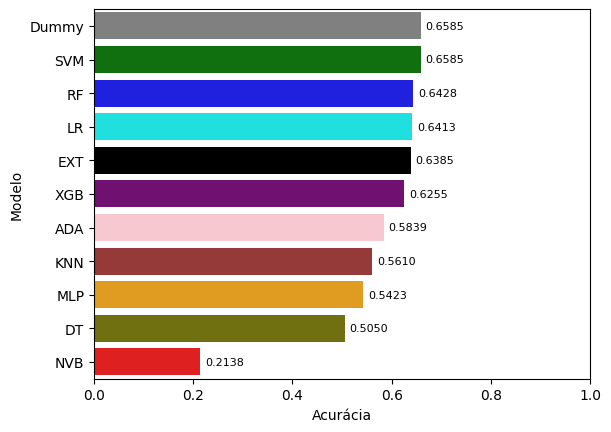

Modelo  Acurácia
0   Dummy  0.658537
2     SVM  0.658537
1      RF  0.642755
8      LR  0.641320
10    EXT  0.638451
4     XGB  0.625538
6     ADA  0.583931
5     KNN  0.560976
3     MLP  0.542324
9      DT  0.505022
7     NVB  0.213773

In [49]:
avalia_dif_modelos_cv(X_train1, y_train1, 5)

### Base 2 - Com WHOQOL Completo

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.50      0.61       119
           1       0.83      0.60      0.69       119
           2       0.80      0.93      0.86       459

    accuracy                           0.80       697
   macro avg       0.80      0.68      0.72       697
weighted avg       0.80      0.80      0.79       697

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       119
           1       0.88      0.35      0.50       119
           2       0.70      0.99      0.82       459

    accuracy                           0.71       697
   macro avg       0.86      0.45      0.45       697
weighted avg       0.78      0.71      0.63       697

-------------------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


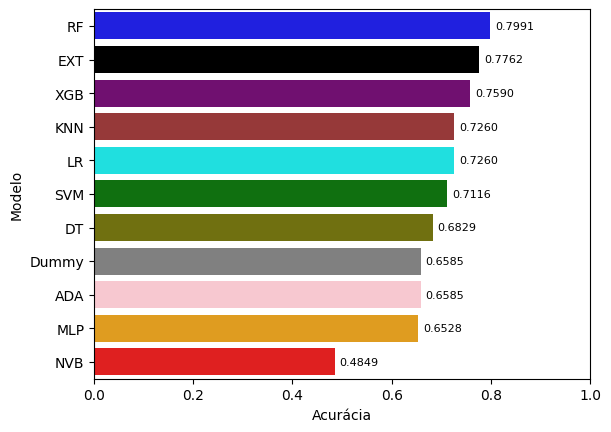

Modelo  Acurácia
1      RF  0.799139
10    EXT  0.776184
4     XGB  0.758967
5     KNN  0.725968
8      LR  0.725968
2     SVM  0.711621
9      DT  0.682927
0   Dummy  0.658537
6     ADA  0.658537
3     MLP  0.652798
7     NVB  0.484935

In [50]:
avalia_dif_modelos_cv(X_train2, y_train2, 5)

### Base 3 - Com WHOQOL Domínios

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.34      0.45       119
           1       0.79      0.50      0.62       119
           2       0.76      0.93      0.83       459

    accuracy                           0.75       697
   macro avg       0.75      0.59      0.63       697
weighted avg       0.75      0.75      0.73       697

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697

-------------------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


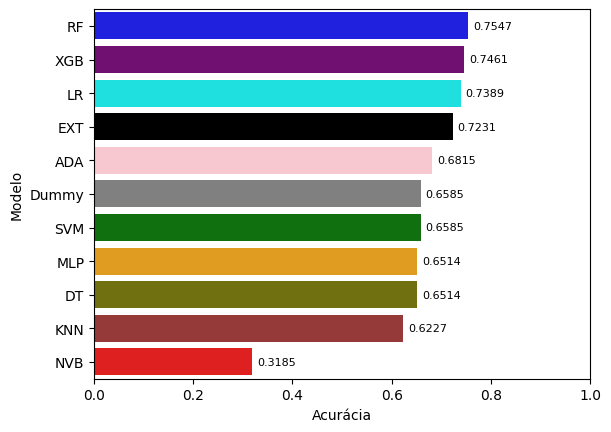

Modelo  Acurácia
1      RF  0.754663
4     XGB  0.746055
8      LR  0.738881
10    EXT  0.723099
6     ADA  0.681492
0   Dummy  0.658537
2     SVM  0.658537
3     MLP  0.651363
9      DT  0.651363
5     KNN  0.622669
7     NVB  0.318508

In [51]:
avalia_dif_modelos_cv(X_train3, y_train3, 5)

### Base 4 - Qualidade de Vida

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.06      0.11       119
           1       0.56      0.16      0.25       119
           2       0.67      0.95      0.79       459

    accuracy                           0.67       697
   macro avg       0.59      0.39      0.38       697
weighted avg       0.63      0.67      0.58       697

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697

-------------------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


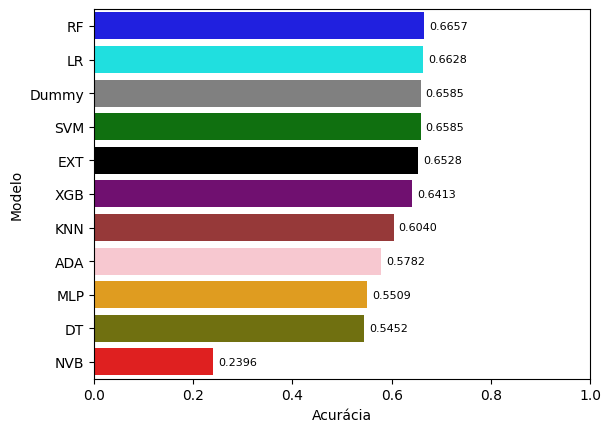

Modelo  Acurácia
1      RF  0.665710
8      LR  0.662841
0   Dummy  0.658537
2     SVM  0.658537
10    EXT  0.652798
4     XGB  0.641320
5     KNN  0.604017
6     ADA  0.578192
3     MLP  0.550933
9      DT  0.545194
7     NVB  0.239598

In [52]:
avalia_dif_modelos_cv(X_train4, y_train4, 5)

### Base 5 - Qualidade de Vida Geral

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.04      0.08       119
           1       0.61      0.18      0.28       119
           2       0.68      0.96      0.79       459

    accuracy                           0.67       697
   macro avg       0.60      0.40      0.38       697
weighted avg       0.63      0.67      0.58       697

-------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


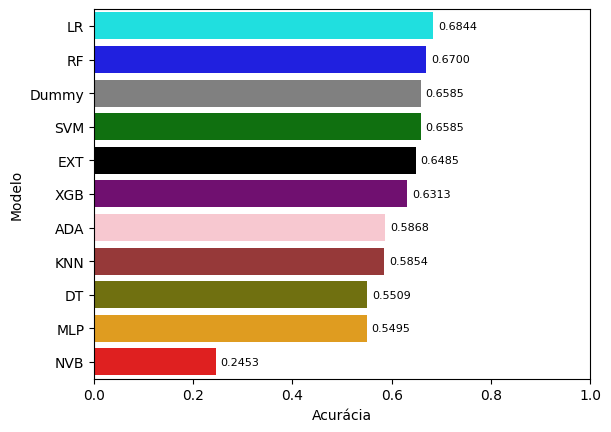

Modelo  Acurácia
8      LR  0.684362
1      RF  0.670014
0   Dummy  0.658537
2     SVM  0.658537
10    EXT  0.648494
4     XGB  0.631277
6     ADA  0.586801
5     KNN  0.585366
9      DT  0.550933
3     MLP  0.549498
7     NVB  0.245337

In [53]:
avalia_dif_modelos_cv(X_train5, y_train5, 5)

### Base 6 - Media dos Domínios

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.17      0.26       119
           1       0.78      0.27      0.40       119
           2       0.70      0.94      0.80       459

    accuracy                           0.70       697
   macro avg       0.67      0.46      0.49       697
weighted avg       0.69      0.70      0.64       697

-------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


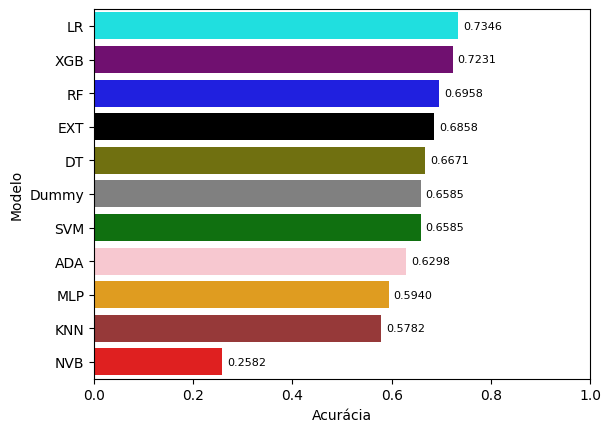

Modelo  Acurácia
8      LR  0.734577
4     XGB  0.723099
1      RF  0.695839
10    EXT  0.685796
9      DT  0.667145
0   Dummy  0.658537
2     SVM  0.658537
6     ADA  0.629842
3     MLP  0.593974
5     KNN  0.578192
7     NVB  0.258250

In [54]:
avalia_dif_modelos_cv(X_train6, y_train6, 5)

## Avaliando modelos com Under-Sampling

### Base 1 - Sem WHOQOL

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.28      0.25       119
           1       0.28      0.34      0.31       119
           2       0.31      0.18      0.23       119

    accuracy                           0.27       357
   macro avg       0.27      0.27      0.26       357
weighted avg       0.27      0.27      0.26       357



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.39      0.39       119
           1       0.54      0.56      0.55       119
           2       0.32      0.29      0.30       119

    accuracy                           0.41       357
   macro avg       0.41      0.41      0.41       357
weighted avg       0.41      0.41      0.41       357

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.24      0.27       119
           1       0.42      0.61      0.50       119
           2       0.28      0.22      0.25       119

    accuracy                           0.36       357
   macro avg       0.34      0.36      0.34       357
weighted avg       0.34      0.36      0.34       357

-------------------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


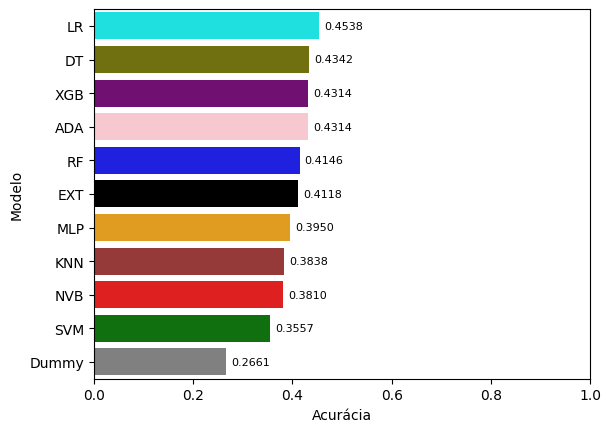

Modelo  Acurácia
8      LR  0.453782
9      DT  0.434174
4     XGB  0.431373
6     ADA  0.431373
1      RF  0.414566
10    EXT  0.411765
3     MLP  0.394958
5     KNN  0.383754
7     NVB  0.380952
2     SVM  0.355742
0   Dummy  0.266106

In [55]:
# Avaliando os modelos para cada dado com o treino
avalia_dif_modelos_cv(X_train1_re, y_train1_re, 5)

### Base 2 - Com WHOQOL Completo

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.28      0.25       119
           1       0.28      0.34      0.31       119
           2       0.31      0.18      0.23       119

    accuracy                           0.27       357
   macro avg       0.27      0.27      0.26       357
weighted avg       0.27      0.27      0.26       357



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79       119
           1       0.85      0.89      0.87       119
           2       0.67      0.65      0.66       119

    accuracy                           0.78       357
   macro avg       0.77      0.78      0.77       357
weighted avg       0.77      0.78      0.77       357

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       119
           1       0.90      0.88      0.89       119
           2       0.65      0.62      0.64       119

    accuracy                           0.76       357
   macro avg       0.76      0.76      0.76       357
weighted avg       0.76      0.76      0.76       357

-------------------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


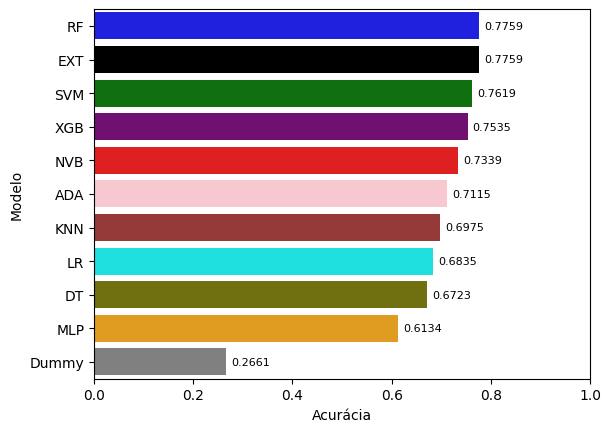

Modelo  Acurácia
1      RF  0.775910
10    EXT  0.775910
2     SVM  0.761905
4     XGB  0.753501
7     NVB  0.733894
6     ADA  0.711485
5     KNN  0.697479
8      LR  0.683473
9      DT  0.672269
3     MLP  0.613445
0   Dummy  0.266106

In [56]:
avalia_dif_modelos_cv(X_train2_re, y_train2_re, 5)

### Base 3 - Com WHOQOL Domínios

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.28      0.25       119
           1       0.28      0.34      0.31       119
           2       0.31      0.18      0.23       119

    accuracy                           0.27       357
   macro avg       0.27      0.27      0.26       357
weighted avg       0.27      0.27      0.26       357

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       119
           1       0.86      0.87      0.86       119
           2       0.64      0.62      0.63       119

    accuracy                           0.76       357
   macro avg       0.75      0.76      0.76       357
weighted avg       0.75      0.76      0.76       357

-------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


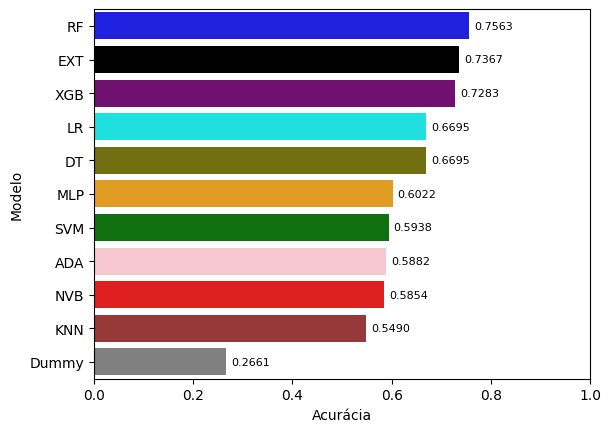

Modelo  Acurácia
1      RF  0.756303
10    EXT  0.736695
4     XGB  0.728291
8      LR  0.669468
9      DT  0.669468
3     MLP  0.602241
2     SVM  0.593838
6     ADA  0.588235
7     NVB  0.585434
5     KNN  0.549020
0   Dummy  0.266106

In [57]:
avalia_dif_modelos_cv(X_train3_re, y_train3_re, 5)

### Base 4 - Qualidade de Vida

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.28      0.25       119
           1       0.28      0.34      0.31       119
           2       0.31      0.18      0.23       119

    accuracy                           0.27       357
   macro avg       0.27      0.27      0.26       357
weighted avg       0.27      0.27      0.26       357



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.66      0.63       119
           1       0.64      0.71      0.67       119
           2       0.36      0.28      0.31       119

    accuracy                           0.55       357
   macro avg       0.53      0.55      0.54       357
weighted avg       0.53      0.55      0.54       357

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.32      0.35       119
           1       0.53      0.61      0.57       119
           2       0.31      0.32      0.32       119

    accuracy                           0.41       357
   macro avg       0.41      0.41      0.41       357
weighted avg       0.41      0.41      0.41       357

-------------------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


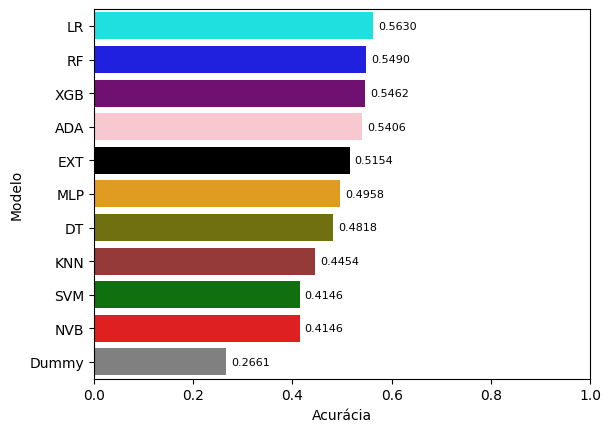

Modelo  Acurácia
8      LR  0.563025
1      RF  0.549020
4     XGB  0.546218
6     ADA  0.540616
10    EXT  0.515406
3     MLP  0.495798
9      DT  0.481793
5     KNN  0.445378
2     SVM  0.414566
7     NVB  0.414566
0   Dummy  0.266106

In [58]:
avalia_dif_modelos_cv(X_train4_re, y_train4_re, 5)

### Base 5 - Qualidade de Vida Geral

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.28      0.25       119
           1       0.28      0.34      0.31       119
           2       0.31      0.18      0.23       119

    accuracy                           0.27       357
   macro avg       0.27      0.27      0.26       357
weighted avg       0.27      0.27      0.26       357

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.64      0.61       119
           1       0.70      0.76      0.73       119
           2       0.41      0.34      0.38       119

    accuracy                           0.58       357
   macro avg       0.57      0.58      0.57       357
weighted avg       0.57      0.58      0.57       357

-------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


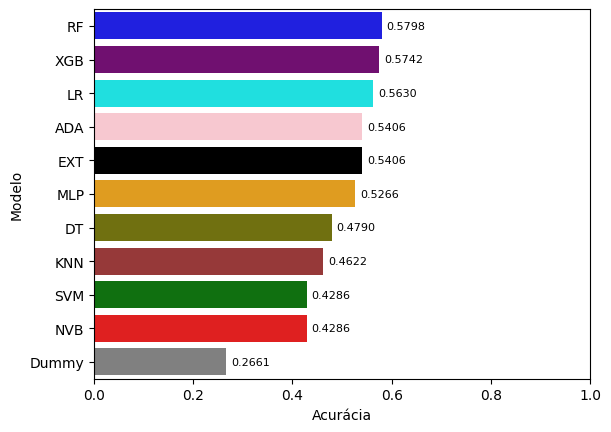

Modelo  Acurácia
1      RF  0.579832
4     XGB  0.574230
8      LR  0.563025
6     ADA  0.540616
10    EXT  0.540616
3     MLP  0.526611
9      DT  0.478992
5     KNN  0.462185
2     SVM  0.428571
7     NVB  0.428571
0   Dummy  0.266106

In [59]:
avalia_dif_modelos_cv(X_train5_re, y_train5_re, 5)

### Base 5 - Media dos Domínios

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.28      0.25       119
           1       0.28      0.34      0.31       119
           2       0.31      0.18      0.23       119

    accuracy                           0.27       357
   macro avg       0.27      0.27      0.26       357
weighted avg       0.27      0.27      0.26       357



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       119
           1       0.80      0.86      0.83       119
           2       0.55      0.50      0.52       119

    accuracy                           0.68       357
   macro avg       0.67      0.68      0.68       357
weighted avg       0.67      0.68      0.68       357

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.29      0.33       119
           1       0.55      0.63      0.59       119
           2       0.29      0.32      0.31       119

    accuracy                           0.41       357
   macro avg       0.41      0.41      0.41       357
weighted avg       0.41      0.41      0.41       357

-------------------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


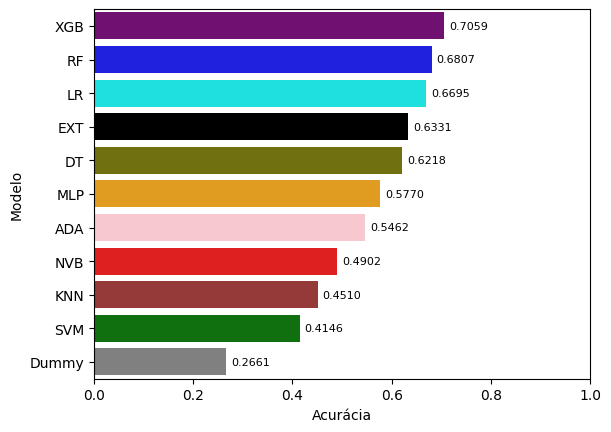

Modelo  Acurácia
4     XGB  0.705882
1      RF  0.680672
8      LR  0.669468
10    EXT  0.633053
9      DT  0.621849
3     MLP  0.577031
6     ADA  0.546218
7     NVB  0.490196
5     KNN  0.450980
2     SVM  0.414566
0   Dummy  0.266106

In [60]:
avalia_dif_modelos_cv(X_train6_re, y_train6_re, 5)

## Avaliando modelos com base Normalizada

### Base 1 - Sem WHOQOL

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.03      0.05       119
           1       0.09      0.01      0.02       119
           2       0.65      0.97      0.78       459

    accuracy                           0.64       697
   macro avg       0.37      0.33      0.28       697
weighted avg       0.51      0.64      0.53       697

-------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


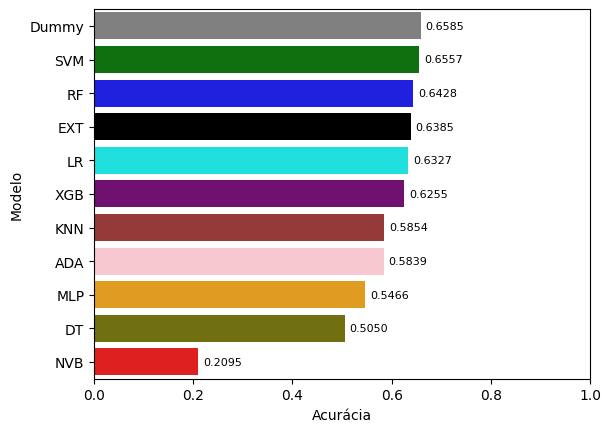

Modelo  Acurácia
0   Dummy  0.658537
2     SVM  0.655667
1      RF  0.642755
10    EXT  0.638451
8      LR  0.632712
4     XGB  0.625538
5     KNN  0.585366
6     ADA  0.583931
3     MLP  0.546628
9      DT  0.505022
7     NVB  0.209469

In [61]:
avalia_dif_modelos_cv(X_train1_norm, y_train1, 5)

### Base 2 - Com WHOQOL Completo

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.52      0.62       119
           1       0.83      0.60      0.69       119
           2       0.80      0.92      0.86       459

    accuracy                           0.80       697
   macro avg       0.79      0.68      0.72       697
weighted avg       0.80      0.80      0.79       697

-------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


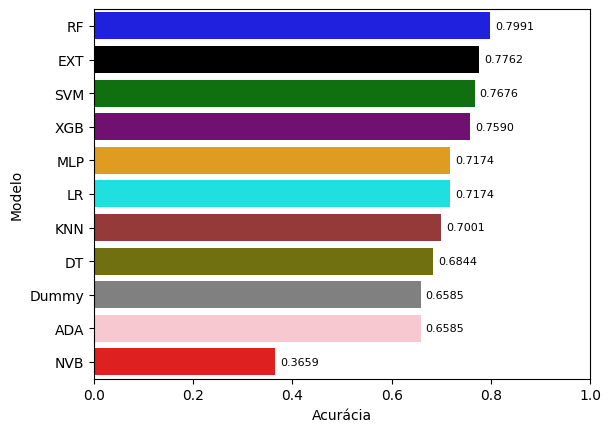

Modelo  Acurácia
1      RF  0.799139
10    EXT  0.776184
2     SVM  0.767575
4     XGB  0.758967
3     MLP  0.717360
8      LR  0.717360
5     KNN  0.700143
9      DT  0.684362
0   Dummy  0.658537
6     ADA  0.658537
7     NVB  0.365854

In [62]:
avalia_dif_modelos_cv(X_train2_norm, y_train2, 5)

### Base 3 - Com WHOQOL Domínios

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.33      0.45       119
           1       0.79      0.50      0.62       119
           2       0.75      0.93      0.83       459

    accuracy                           0.75       697
   macro avg       0.75      0.59      0.63       697
weighted avg       0.75      0.75      0.73       697

-------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


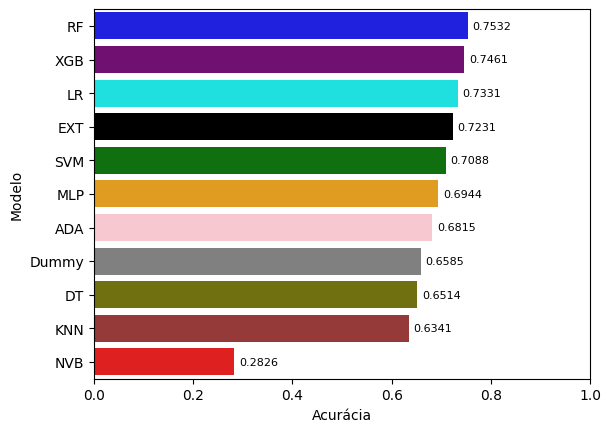

Modelo  Acurácia
1      RF  0.753228
4     XGB  0.746055
8      LR  0.733142
10    EXT  0.723099
2     SVM  0.708752
3     MLP  0.694405
6     ADA  0.681492
0   Dummy  0.658537
9      DT  0.651363
5     KNN  0.634146
7     NVB  0.282640

In [63]:
avalia_dif_modelos_cv(X_train3_norm, y_train3, 5)

### Base 4 - Qualidade de Vida

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.06      0.11       119
           1       0.56      0.16      0.25       119
           2       0.67      0.96      0.79       459

    accuracy                           0.67       697
   macro avg       0.61      0.39      0.38       697
weighted avg       0.64      0.67      0.58       697

-------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


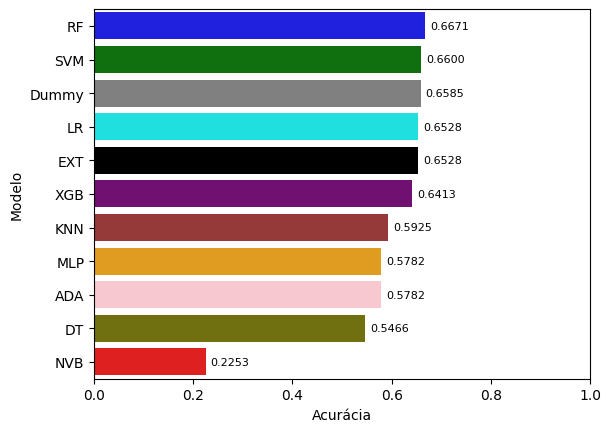

Modelo  Acurácia
1      RF  0.667145
2     SVM  0.659971
0   Dummy  0.658537
8      LR  0.652798
10    EXT  0.652798
4     XGB  0.641320
5     KNN  0.592539
3     MLP  0.578192
6     ADA  0.578192
9      DT  0.546628
7     NVB  0.225251

In [64]:
avalia_dif_modelos_cv(X_train4_norm, y_train4, 5)

### Base 5 - Qualidade de Vida Geral

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.04      0.08       119
           1       0.61      0.18      0.28       119
           2       0.68      0.96      0.79       459

    accuracy                           0.67       697
   macro avg       0.60      0.40      0.38       697
weighted avg       0.63      0.67      0.58       697

-------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


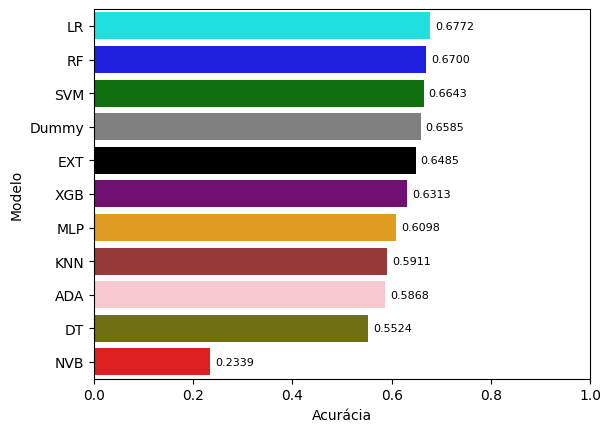

Modelo  Acurácia
8      LR  0.677188
1      RF  0.670014
2     SVM  0.664275
0   Dummy  0.658537
10    EXT  0.648494
4     XGB  0.631277
3     MLP  0.609756
5     KNN  0.591105
6     ADA  0.586801
9      DT  0.552367
7     NVB  0.233859

In [65]:
avalia_dif_modelos_cv(X_train5_norm, y_train5, 5)

### Base 6 - Media dos Domínios

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.17      0.26       119
           1       0.79      0.28      0.41       119
           2       0.70      0.94      0.80       459

    accuracy                           0.70       697
   macro avg       0.68      0.46      0.49       697
weighted avg       0.69      0.70      0.64       697

-------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


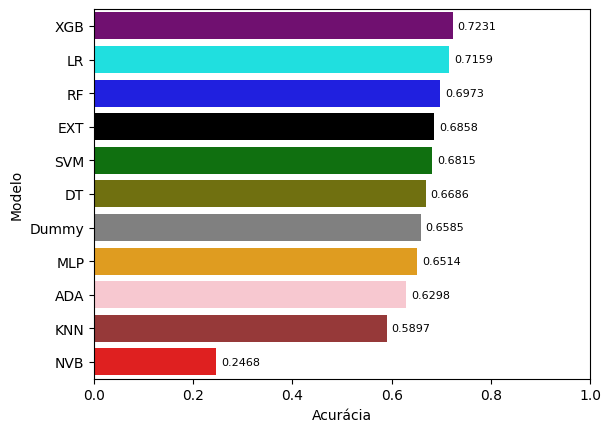

Modelo  Acurácia
4     XGB  0.723099
8      LR  0.715925
1      RF  0.697274
10    EXT  0.685796
2     SVM  0.681492
9      DT  0.668580
0   Dummy  0.658537
3     MLP  0.651363
6     ADA  0.629842
5     KNN  0.589670
7     NVB  0.246772

In [66]:
avalia_dif_modelos_cv(X_train6_norm, y_train6, 5)

## Tunning dos hiperparâmetros GridSearch

### Parametros para grid search

In [24]:
def get_param_grid(X,y):
    import math
    param_grids = [
        {
            'model': 'Random Forest',
            'params': {
                # Vetor linear inteiro, entre log2(numero_de_classes) e numero_de_features/2
                'max_depth': np.unique(np.linspace(math.log2(len(np.unique(y))), len(X.columns) // 2, 20, dtype=int)),
                # Vetor linear inteiro, de ln(numero de objetos no conjunto) -40 até ln(numero de objetos no conjunto) + 45
                'n_estimators': np.unique(np.maximum(np.linspace(math.log(len(X)) - 40, math.log(len(X)) + 45, 20, dtype=int),1)),
                # Vetor linear inteiro, numero features * 0.3 até numero features * 0.8
                'max_features': np.unique(np.linspace(int(len(X.columns) * 0.3), int(len(X.columns) * 0.8), 20, dtype=int)),
                'criterion': ['gini', 'entropy'],
                'bootstrap': [True, False]
            }
        },
        {
            #  C=2^−5,2^−3,…,2^15;γ=2^−15,2^−13,…,2^3
            'model': 'SVM',
            'params': {
                # 'C': np.linspace(2**-5, 2**15, 10),
                # 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                # 'gamma': np.linspace(2**-15, 2**3, 10),
                'C': [0.00001, 0.0001, 0.001,  0.01, 0.1, 1, 10, 100, 1000, 10000],
                'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 'scale', 1/len(X.columns)],
                'degree': np.linspace(2, 6, 6, dtype=int)
            }
        },
        {
            'model': 'MLP',
            'params': {
                'hidden_layer_sizes': [(neurons,) * layers for layers in range(1, 4) for neurons in range(len(X.columns) * 5, len(X.columns) * 10 + 1)],
                'learning_rate_init': np.linspace(0.0001, 1, 10),
                'momentum': np.linspace(0.1, 0.9, 10),
                'max_iter': np.linspace(400, 4000, 20, dtype=int)
            }
        },
        {
            'model': 'XGBoost',
            'params': {
                # Segue o mesmo padrão do Random Forest
                'max_depth': np.linspace(math.log2(len(np.unique(y))), len(X.columns) // 2, 20, dtype=int),
                'n_estimators': np.unique(np.maximum(np.linspace(math.log(len(X)) - 40, math.log(len(X)) + 45, 20, dtype=int),1)),
                'learning_rate': np.linspace(0.0001, 1, 10),
                'subsample': np.linspace(0.1, 1, 10),
                'gamma': np.linspace(0, 1, 10),
                'colsample_bytree': np.linspace(0.5, 1, 10)
            }
        },
        {
                'model': 'KNN',
                'params': {
                    'n_neighbors': np.linspace(1, 30, 15, dtype=int),
                    'weights': ['uniform', 'distance'],
                    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'p': [1, 2, 3, 4],
                    'leaf_size': np.linspace(1, 100, 20, dtype=int)
                }
        },
        {
            'model': 'ADA',
            'params': {
                'n_estimators': np.linspace(50, 500, 30, dtype=int),
                'learning_rate': np.linspace(0.001, 1, 30),
                'algorithm': ['SAMME', 'SAMME.R']
            }
        },
        {
            'model': 'NVB',
            'params': {
                'var_smoothing': np.linspace(1e-10, 1e1, 60)
            }
        },
        {
            'model': 'LR',
            'params': {
                'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                'C': np.linspace(0.001, 1, 15),
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'max_iter': np.linspace(100, 2000, 15, dtype=int)
            }
        },
        {
            'model': 'DT',
            'params': {
                'criterion': ['gini', 'entropy'],
                'splitter': ['best', 'random'],
                'max_depth': np.unique(np.linspace(math.log2(len(np.unique(y))), len(X.columns) // 2, 20, dtype=int)),
                'min_samples_split': np.linspace(0.01, 1, 20),
                'min_samples_leaf': np.linspace(0.01, 0.5, 20)
            }
        },
        {
            'model': 'EXT',
            'params': {
                # Segue o mesmo padrão do Random Forest
                'max_depth': np.unique(np.linspace(math.log2(len(np.unique(y))), len(X.columns) // 2, 15, dtype=int)),
                'n_estimators': np.unique(np.maximum(np.linspace(math.log(len(X)) - 40, math.log(len(X)) + 45, 15, dtype=int),1)),
                'max_features': np.unique(np.linspace(int(len(X.columns) * 0.3), int(len(X.columns) * 0.8), 15, dtype=int)),
                'criterion': ['gini', 'entropy'],
                'bootstrap': [True, False]
            }
        }

    ]


        # Create a list of solver-penalty pairs that are compatible
    compatible_solver_penalty = [
        ('newton-cg', 'l2'),
        ('lbfgs', 'l2'),
        ('liblinear', 'l1'),
        ('liblinear', 'l2'),
        ('sag', 'l2'),
        ('saga', 'l1'),
        ('saga', 'l2'),
        ('saga', 'elasticnet'),
        ('newton-cg', 'none'),
        ('lbfgs', 'none'),
        ('sag', 'none'),
        ('saga', 'none')
    ]

    # Modify the 'LR' dictionary in your param_grid
    for grid in param_grids:
        if grid['model'] == 'LR':
            grid['params']['penalty'] = [penalty for penalty in grid['params']['penalty'] if ('saga', penalty) in compatible_solver_penalty]
            grid['params']['solver'] = [solver for solver in grid['params']['solver'] if (solver, 'elasticnet') in compatible_solver_penalty]
            if 'elasticnet' in grid['params']['penalty']:
                grid['params']['l1_ratio'] = np.linspace(0, 1, 10)
    return param_grids

#### A

In [25]:
#Definindo parametros:
#Definir os modelos e os grids de parâmetros
models = {
    'Random Forest': RandomForestClassifier(n_jobs=n_cpus, random_state=13),
    'SVM': SVC(random_state=13),
    'MLP': MLPClassifier(random_state=13),
    'XGBoost': XGBClassifier(n_jobs=n_cpus, random_state=13),
    'KNN': KNeighborsClassifier(n_jobs=n_cpus),
    'ADA': AdaBoostClassifier(random_state=13),
    'NVB': GaussianNB(),
    'LR': LogisticRegression(random_state=13, n_jobs=n_cpus, max_iter=1000),
    'DT': DecisionTreeClassifier(random_state=13),
    'EXT': ExtraTreesClassifier(random_state=13, n_jobs=n_cpus)
}

param_grids = [
    {
        'model': 'Random Forest',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [2, 5, 10, 15, 20 ],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2'],
            'n_jobs': [n_cpus]
        }
    },
    {
        #  C=2^−5,2^−3,…,2^15;γ=2^−15,2^−13,…,2^3
        # 'model': 'SVM',
        # 'params': {
        #     'C': [2**i for i in range(-5, 16, 2)],
        #     'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        #     'gamma': [2**i for i in range(-15, 4, 2)] + ['scale', 'auto'],
        #     'degree': np.linspace(2, 6, 4, dtype=int)
        # }

        'model': 'SVM',
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto']
        }
    },
    {
        'model': 'MLP',
        'params': {
            'hidden_layer_sizes': [(10,), (50,), (100,), (150,), (200,)],
            'activation': ['logistic', 'tanh', 'relu'],
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
            'learning_rate': ['constant', 'invscaling', 'adaptive']
        }
    },
    {
        'model': 'XGBoost',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [3, 5, 7, 9, 11, 13, 15, ],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'n_jobs': [n_cpus]
        }
    }
    ,
    {
        'model': 'KNN',
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [5,10, 20, 30, 40, 50],
            'p': [1, 2, 3, 4, 5, 6]
        }
    }
    ,
    {
        'model': 'ADA',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'algorithm': ['SAMME', 'SAMME.R']
        }
    }
    ,
    {
        'model': 'NVB',
        'params': {
            'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]
        }
    }
    ,
    {
        'model': 'LR',
        'params': {
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'C': [0.1, 1, 10, 100],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'max_iter': [50, 100, 200, 300, 400, 500],
            'n_jobs': [n_cpus]
        }
    }
    ,
    {
        'model': 'DT',
        'params': {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [None, 5, 10, 15, 20, ],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }
    }
    ,
    {
        'model': 'EXT',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 10, 15, 20, ],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2'],
            'n_jobs': [n_cpus]
        }
    }
]

### Tunning dos modelos sem Random Under-Sampling

#### Base 1 - Sem WHOQOL

========================== Data 1  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [16 17 18 20 21 23 24 25 27 28 30 31 33 34 35 37 38 40 41 43]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 5.62s | Modelo: Random Forest | Acurácia: 0.680453667953668
Parâmetros selecionados: {'n_estimators': 42, 'max_features': 24, 'max_depth': 9, 'criterion': 'entropy', 'bootstrap': False}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.018518518518518517]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Tempo de execução: 18.68s | Modelo: LR | Acurácia: 0.675
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1864, 'l1_ratio': 0.3333333333333333, 'C': 0.42914285714285716}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.24s | Modelo: DT | Acurácia: 0.666071

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


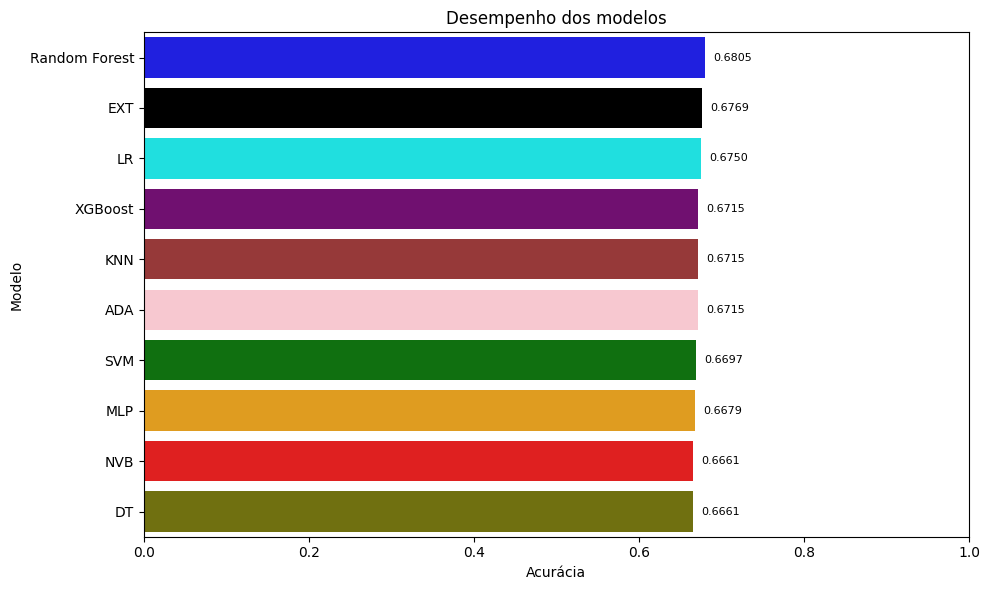



Melhor modelo: Random Forest | Acurácia: 0.680453667953668

Tempo de execução total :1953.49s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3895455190.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [119]:
# Chamando função para cada uma das bases
print("========================== Data 1  =================================")
best_models1_Desb, best1_desb = perform_random_model_tuning(models, get_param_grid(X_train1, y_train1), "data1_desb", X_train1, y_train1)

#### Base 2 - Com WHOQOL Completo

========================== Data 2  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  3  5  7 10 12 14 16 18 20 22 24 27 29 31 33 35 37 39 42]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [25 27 29 31 33 36 38 40 42 44 47 49 51 53 55 58 60 62 64 67]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Tempo de execução: 4.22s | Modelo: Random Forest | Acurácia: 0.7935649935649935
Parâmetros selecionados: {'n_estimators': 51, 'max_features': 29, 'max_depth': 39, 'criterion': 'gini', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.011904761904761904]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 665.38s | Modelo: SVM | Acurácia: 0.7666344916344916
Parâmetros selecionados: {'kernel': 'rbf', 'gamma': 1e-05, 'degree': 2, 'C': 1000}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(420,), (421,), (422,), (423,), (424,), (425,), (426,), (427,), (428,), (429,), (430,), (431,), (432,), (433,), (434,), (435,), (436,), (437,), (438,), (439,), (440,), (441,), (442,), (443,), (444,), (445,), (446,), (447,),

c:\Programs\envs\BIC\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (589) reached and the optimization hasn't converged yet.
  warnings.warn(


Tempo de execução: 1706.10s | Modelo: MLP | Acurácia: 0.7271396396396396
Parâmetros selecionados: {'momentum': 0.8111111111111111, 'max_iter': 589, 'learning_rate_init': 0.0001, 'hidden_layer_sizes': (541,)}

Tuning do modelo XGBoost iniciado...
Paramêtros sendo testados:
max_depth | [ 1  3  5  7 10 12 14 16 18 20 22 24 27 29 31 33 35 37 39 42]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
learning_rate | [1.000e-04 1.112e-01 2.223e-01 3.334e-01 4.445e-01 5.556e-01 6.667e-01
 7.778e-01 8.889e-01 1.000e+00]
subsample | [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
gamma | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
colsample_bytree | [0.5        0.55555556 0.61111111 0.66666667 0.72222222 0.77777778
 0.83333333 0.88888889 0.94444444 1.        ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 10.29s | Modelo: XGBoost | Acurácia: 0.7899131274131272
Parâmetros selecionados: {'subsam

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 28.03s | Modelo: LR | Acurácia: 0.7486969111969112
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1728, 'l1_ratio': 1.0, 'C': 0.1437142857142857}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  3  5  7 10 12 14 16 18 20 22 24 27 29 31 33 35 37 39 42]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.33s | Modelo: DT | Acurácia: 0.777413127

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


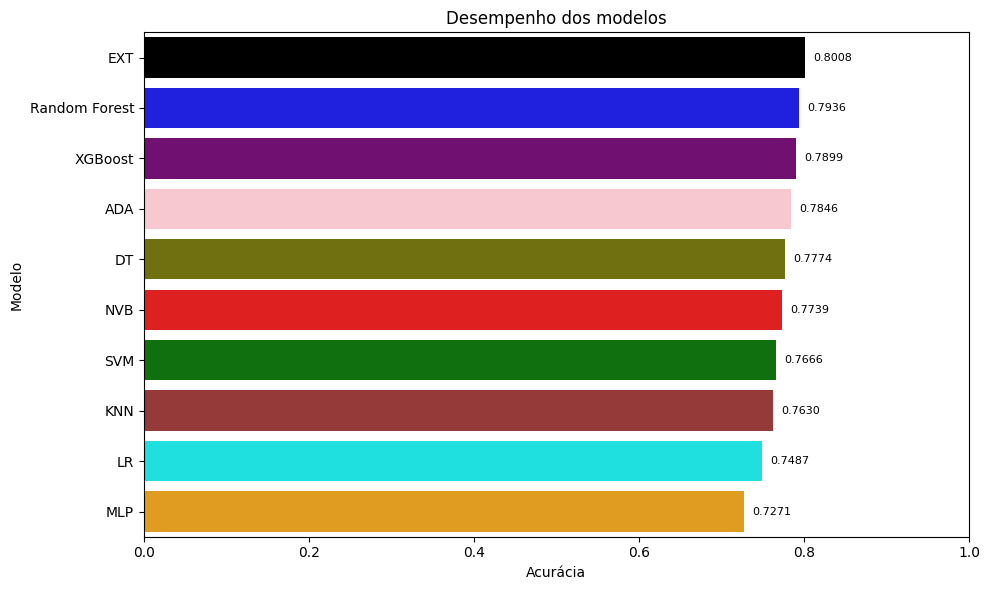



Melhor modelo: EXT | Acurácia: 0.8007561132561133

Tempo de execução total :2441.08s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3895455190.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [120]:
print("========================== Data 2  =================================")
best_models3Desb, best2_desb = perform_random_model_tuning(models, get_param_grid(X_train2, y_train2), "data2_desb", X_train2, y_train2)

#### Base 3 - Com WHOQOL Domínios

========================== Data 3  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  3  4  5  7  8 10 11 13 14 16 17 18 20 21 23 24 26 27 29]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [17 18 20 21 23 24 26 27 29 30 32 33 35 36 38 39 41 42 44 46]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Tempo de execução: 3.59s | Modelo: Random Forest | Acurácia: 0.789993564993565
Parâmetros selecionados: {'n_estimators': 33, 'max_features': 42, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': False}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.017241379310344827]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 490.72s | Modelo: SVM | Acurácia: 0.7558558558558559
Parâmetros selecionados: {'kernel': 'sigmoid', 'gamma': 1e-05, 'degree': 2, 'C': 10000}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(290,), (291,), (292,), (293,), (294,), (295,), (296,), (297,), (298,), (299,), (300,), (301,), (302,), (303,), (304,), (305,), (306,), (307,), (308,), (309,), (310,), (311,), (312,), (313,), (314,), (315,), (316,), 

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de execução: 19.35s | Modelo: LR | Acurácia: 0.728925353925354
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 2000, 'l1_ratio': 1.0, 'C': 0.21507142857142858}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  3  4  5  7  8 10 11 13 14 16 17 18 20 21 23 24 26 27 29]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.24s | Modelo: DT | Acurácia: 0.7

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


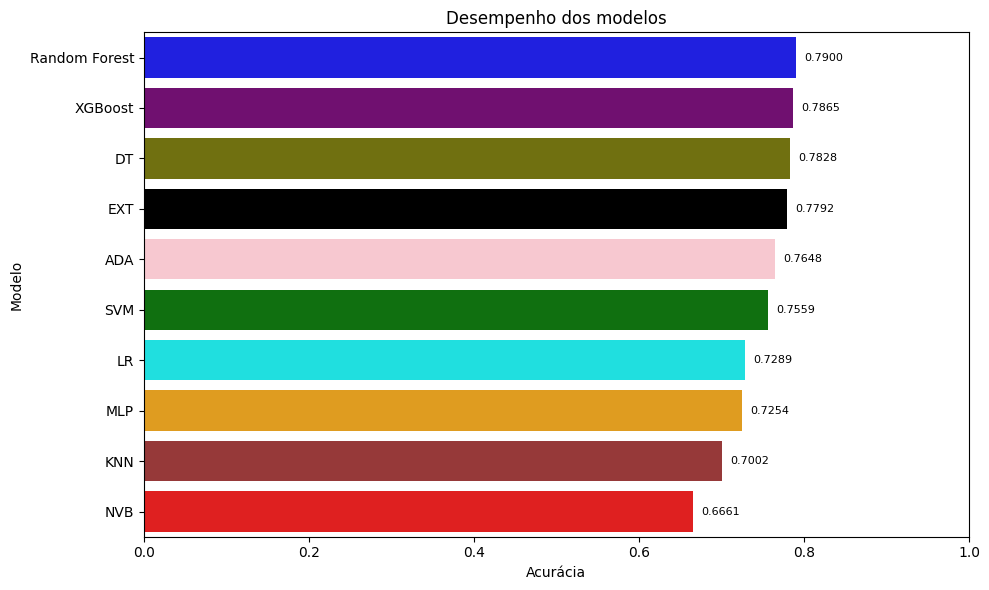



Melhor modelo: Random Forest | Acurácia: 0.789993564993565

Tempo de execução total :1603.58s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3895455190.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [121]:
print("========================== Data 3  =================================")
best_models3Desb, best3_desb = perform_random_model_tuning(models, get_param_grid(X_train3, y_train3), "data3_desb", X_train3, y_train3)

#### Base 4 - Qualidade de Vida

========================== Data 4  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [16 17 18 20 21 23 24 26 27 29 30 32 33 35 36 38 39 41 42 44]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 10.13s | Modelo: Random Forest | Acurácia: 0.6912323037323037
Parâmetros selecionados: {'n_estimators': 42, 'max_features': 30, 'max_depth': 17, 'criterion': 'gini', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.01818181818181818]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 50

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de execução: 18.88s | Modelo: LR | Acurácia: 0.6822715572715572
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 2000, 'l1_ratio': 0.8888888888888888, 'C': 0.21507142857142858}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.24s | Modelo: DT

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


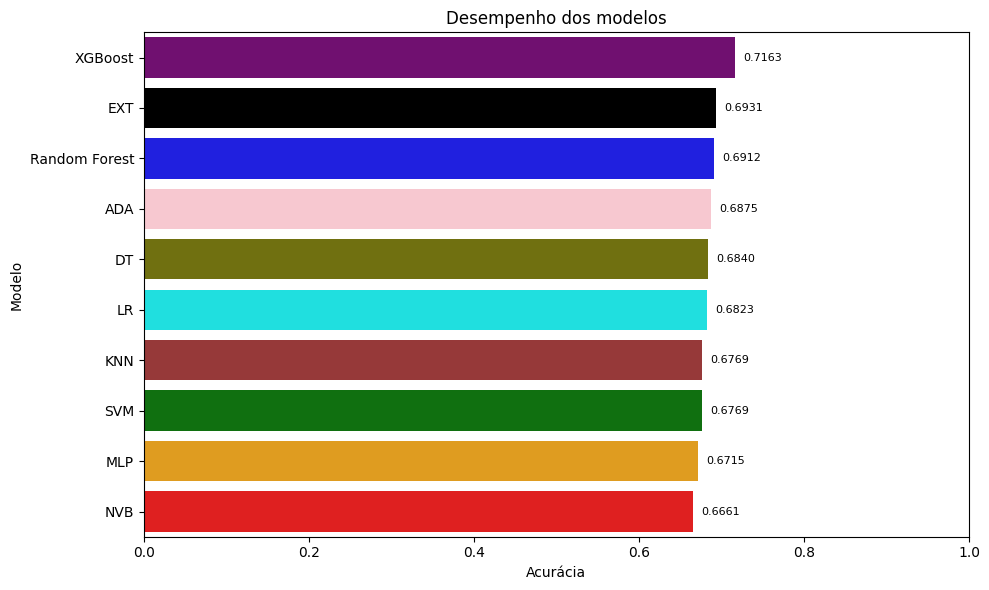



Melhor modelo: XGBoost | Acurácia: 0.7163288288288288

Tempo de execução total :1781.84s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3895455190.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [123]:
print("========================== Data 4  =================================")
best_models4Desb, best4_desb = perform_random_model_tuning(models, get_param_grid(X_train4, y_train4), "data4_desb", X_train4, y_train4)

========================== Data 5  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [16 17 18 20 21 23 24 26 27 29 30 32 33 35 36 38 39 41 42 44]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Tempo de execução: 3.97s | Modelo: Random Forest | Acurácia: 0.703684041184041
Parâmetros selecionados: {'n_estimators': 24, 'max_features': 17, 'max_depth': 10, 'criterion': 'gini', 'bootstrap': False}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.01818181818181818]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 1318.16s | Modelo: SVM | Acurácia: 0.7019465894465895
Parâmetros selecionados: {'kernel': 'linear', 'gamma': 0.0001, 'degree': 2, 'C': 0.1}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(275,), (276,), (277,), (278,), (279,), (280,), (281,), (282,), (283,), (284,), (285,), (286,), (287,), (288,), (289,), (290,), (291,), (292,), (293,), (294,), (295,), (296,), (297,), (298,), (299,), (300,), (301,), (302

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Tempo de execução: 20.68s | Modelo: LR | Acurácia: 0.7002252252252253
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 2000, 'l1_ratio': 0.8888888888888888, 'C': 0.35778571428571426}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.24s | Modelo: DT | Acurá

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


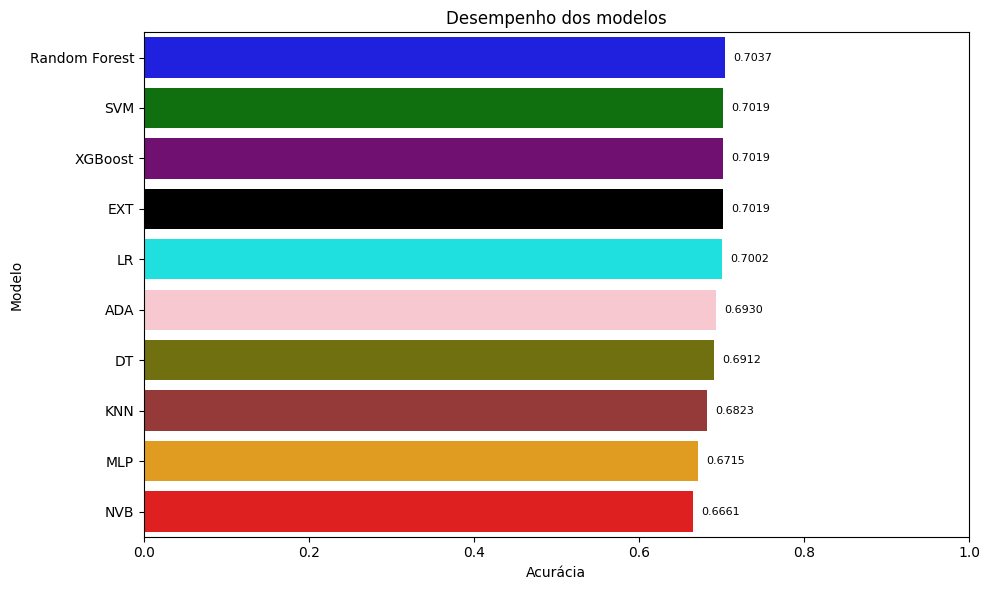



Melhor modelo: Random Forest | Acurácia: 0.703684041184041

Tempo de execução total :2200.88s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3895455190.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [124]:
print("========================== Data 5  =================================")
best_models5Desb, best5_desb = perform_random_model_tuning(models, get_param_grid(X_train5, y_train5), "data5_desb", X_train5, y_train5)

#### Base 6 - Media dos Domínios

========================== Data 6  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [16 17 18 20 21 23 24 26 27 29 30 32 33 35 36 38 39 41 42 44]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Tempo de execução: 4.03s | Modelo: Random Forest | Acurácia: 0.7557432432432432
Parâmetros selecionados: {'n_estimators': 47, 'max_features': 36, 'max_depth': 25, 'criterion': 'entropy', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.01818181818181818]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 400.92s | Modelo: SVM | Acurácia: 0.7378861003861003
Parâmetros selecionados: {'kernel': 'rbf', 'gamma': 0.001, 'degree': 4, 'C': 100}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(275,), (276,), (277,), (278,), (279,), (280,), (281,), (282,), (283,), (284,), (285,), (286,), (287,), (288,), (289,), (290,), (291,), (292,), (293,), (294,), (295,), (296,), (297,), (298,), (299,), (300,), (301,), (302,)

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn

Tempo de execução: 17.72s | Modelo: LR | Acurácia: 0.7253056628056628
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'none', 'max_iter': 2000, 'l1_ratio': 0.2222222222222222, 'C': 0.9286428571428571}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.25s | Modelo: DT | Acur

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


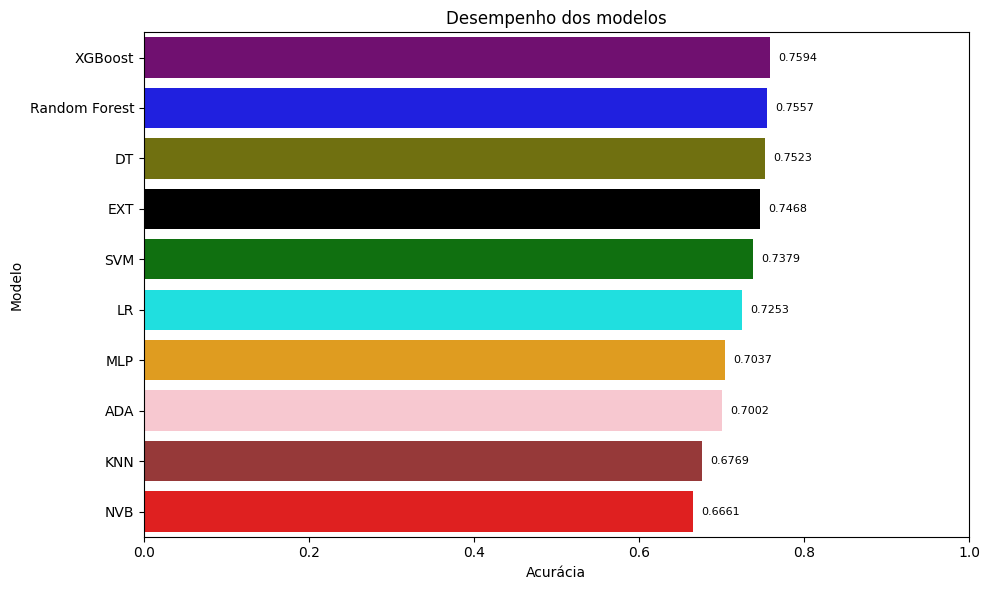



Melhor modelo: XGBoost | Acurácia: 0.759411196911197

Tempo de execução total :1225.24s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3895455190.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [125]:
print("========================== Data 6  =================================")
best_models6Desb, best6_desb = perform_random_model_tuning(models, get_param_grid(X_train6, y_train6), "data6_desb", X_train6, y_train6)

### Tunning dos modelos com Random Under-Sampling

========================== Data 1  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  6 10 15 19 24 28 32 37 41 46 50]
max_features | [16 17 18 20 21 23 24 25 27 28 30 31 33 34 35 37 38 40 41 43]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Tempo de execução: 3.58s | Modelo: Random Forest | Acurácia: 0.5087719298245614
Parâmetros selecionados: {'n_estimators': 24, 'max_features': 16, 'max_depth': 6, 'criterion': 'gini', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.018518518518518517]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 479.65s | Modelo: SVM | Acurácia: 0.5017543859649123
Parâmetros selecionados: {'kernel': 'rbf', 'gamma': 1e-05, 'degree': 4, 'C': 10000}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(270,), (271,), (272,), (273,), (274,), (275,), (276,), (277,), (278,), (279,), (280,), (281,), (282,), (283,), (284,), (285,), (286,), (287,), (288,), (289,), (290,), (291,), (292,), (293,), (294,), (295,), (296,), (297,),

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de execução: 0.38s | Modelo: NVB | Acurácia: 0.39999999999999997
Parâmetros selecionados: {'var_smoothing': 0.33898305094406783}

Tuning do modelo LR iniciado...
Paramêtros sendo testados:
penalty | ['l1', 'l2', 'elasticnet', 'none']
C | [0.001      0.07235714 0.14371429 0.21507143 0.28642857 0.35778571
 0.42914286 0.5005     0.57185714 0.64321429 0.71457143 0.78592857
 0.85728571 0.92864286 1.        ]
solver | ['saga']
max_iter | [ 100  235  371  507  642  778  914 1050 1185 1321 1457 1592 1728 1864
 2000]
l1_ratio | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 10.29s | Modelo: LR | Acurácia: 0.5017543859649123
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1050, 'l1_ratio': 0.3333333333333333, 'C': 0.5718571428571428}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.43s | Modelo: DT | Acurác

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


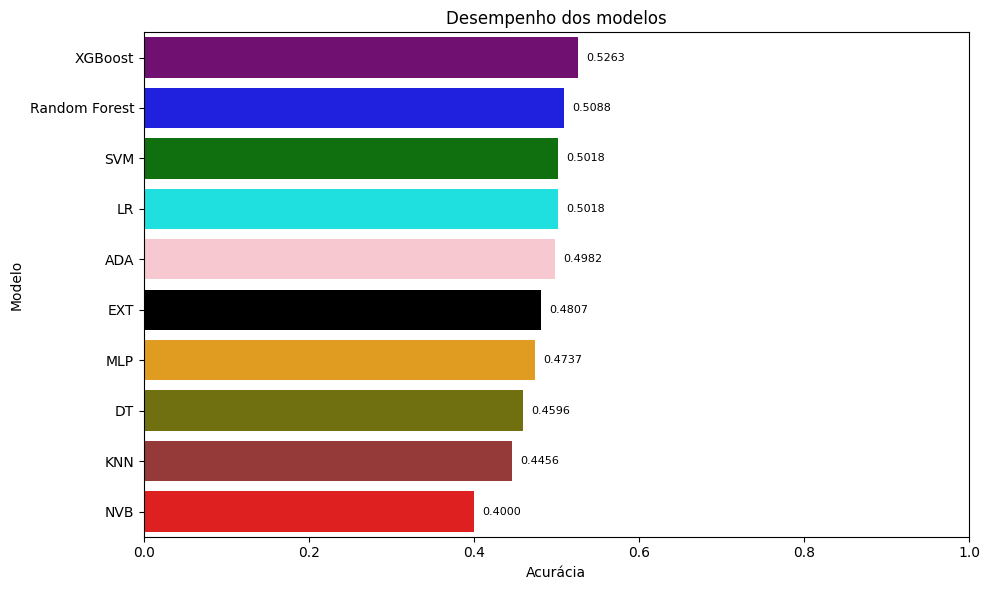



Melhor modelo: XGBoost | Acurácia: 0.5263157894736842

Tempo de execução total :785.58s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3895455190.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [126]:
# Chamando função para cada uma das bases
print("========================== Data 1  =================================")
best_models1, best1 = perform_random_model_tuning(models, get_param_grid(X_train1_re, y_train1_re), "data1", X_train1_re, y_train1_re)

========================== Data 2  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  3  5  7 10 12 14 16 18 20 22 24 27 29 31 33 35 37 39 42]
n_estimators | [ 1  6 10 15 19 24 28 32 37 41 46 50]
max_features | [25 27 29 31 33 36 38 40 42 44 47 49 51 53 55 58 60 62 64 67]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 5.86s | Modelo: Random Forest | Acurácia: 0.7649122807017544
Parâmetros selecionados: {'n_estimators': 41, 'max_features': 36, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.011904761904761904]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 500 f

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de execução: 0.45s | Modelo: NVB | Acurácia: 0.7508771929824561
Parâmetros selecionados: {'var_smoothing': 0.33898305094406783}

Tuning do modelo LR iniciado...
Paramêtros sendo testados:
penalty | ['l1', 'l2', 'elasticnet', 'none']
C | [0.001      0.07235714 0.14371429 0.21507143 0.28642857 0.35778571
 0.42914286 0.5005     0.57185714 0.64321429 0.71457143 0.78592857
 0.85728571 0.92864286 1.        ]
solver | ['saga']
max_iter | [ 100  235  371  507  642  778  914 1050 1185 1321 1457 1592 1728 1864
 2000]
l1_ratio | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 16.26s | Modelo: LR | Acurácia: 0.7052631578947368
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1185, 'l1_ratio': 1.0, 'C': 0.07235714285714286}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  3  5  7 10 12 14 16 18 20 22 24 27 29 31 33 35 37 39 42]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.60s | Modelo: DT | Acurácia: 0.72280701

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


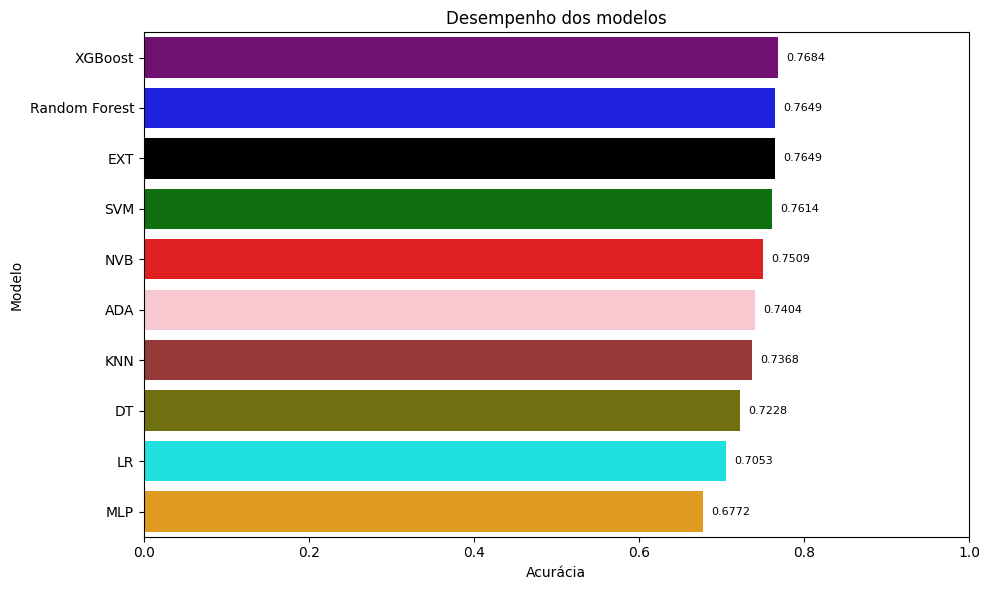



Melhor modelo: XGBoost | Acurácia: 0.7684210526315789

Tempo de execução total :607.61s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3895455190.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [127]:
print("========================== Data 2  =================================")
best_models2, best2 = perform_random_model_tuning(models, get_param_grid(X_train2_re, y_train2_re), "data2", X_train2_re, y_train2_re)

========================== Data 3  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  3  4  5  7  8 10 11 13 14 16 17 18 20 21 23 24 26 27 29]
n_estimators | [ 1  6 10 15 19 24 28 32 37 41 46 50]
max_features | [17 18 20 21 23 24 26 27 29 30 32 33 35 36 38 39 41 42 44 46]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Tempo de execução: 3.74s | Modelo: Random Forest | Acurácia: 0.7543859649122807
Parâmetros selecionados: {'n_estimators': 50, 'max_features': 23, 'max_depth': 26, 'criterion': 'gini', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.017241379310344827]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 143.70s | Modelo: SVM | Acurácia: 0.6982456140350878
Parâmetros selecionados: {'kernel': 'poly', 'gamma': 0.0001, 'degree': 2, 'C': 1000}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(290,), (291,), (292,), (293,), (294,), (295,), (296,), (297,), (298,), (299,), (300,), (301,), (302,), (303,), (304,), (305,), (306,), (307,), (308,), (309,), (310,), (311,), (312,), (313,), (314,), (315,), (316,), (317,

c:\Programs\envs\BIC\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (589) reached and the optimization hasn't converged yet.
  warnings.warn(


Tempo de execução: 327.15s | Modelo: MLP | Acurácia: 0.656140350877193
Parâmetros selecionados: {'momentum': 0.1, 'max_iter': 589, 'learning_rate_init': 0.0001, 'hidden_layer_sizes': (434,)}

Tuning do modelo XGBoost iniciado...
Paramêtros sendo testados:
max_depth | [ 1  3  4  5  7  8 10 11 13 14 16 17 18 20 21 23 24 26 27 29]
n_estimators | [ 1  6 10 15 19 24 28 32 37 41 46 50]
learning_rate | [1.000e-04 1.112e-01 2.223e-01 3.334e-01 4.445e-01 5.556e-01 6.667e-01
 7.778e-01 8.889e-01 1.000e+00]
subsample | [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
gamma | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
colsample_bytree | [0.5        0.55555556 0.61111111 0.66666667 0.72222222 0.77777778
 0.83333333 0.88888889 0.94444444 1.        ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 8.86s | Modelo: XGBoost | Acurácia: 0.7614035087719297
Parâmetros selecionados: {'subsample': 0.5, 'n_estimat

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de execução: 0.38s | Modelo: NVB | Acurácia: 0.5859649122807017
Parâmetros selecionados: {'var_smoothing': 0.16949152552203392}

Tuning do modelo LR iniciado...
Paramêtros sendo testados:
penalty | ['l1', 'l2', 'elasticnet', 'none']
C | [0.001      0.07235714 0.14371429 0.21507143 0.28642857 0.35778571
 0.42914286 0.5005     0.57185714 0.64321429 0.71457143 0.78592857
 0.85728571 0.92864286 1.        ]
solver | ['saga']
max_iter | [ 100  235  371  507  642  778  914 1050 1185 1321 1457 1592 1728 1864
 2000]
l1_ratio | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 9.85s | Modelo: LR | Acurácia: 0.7017543859649122
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 1185, 'l1_ratio': 0.7777777777777777, 'C': 0.07235714285714286}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini',

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


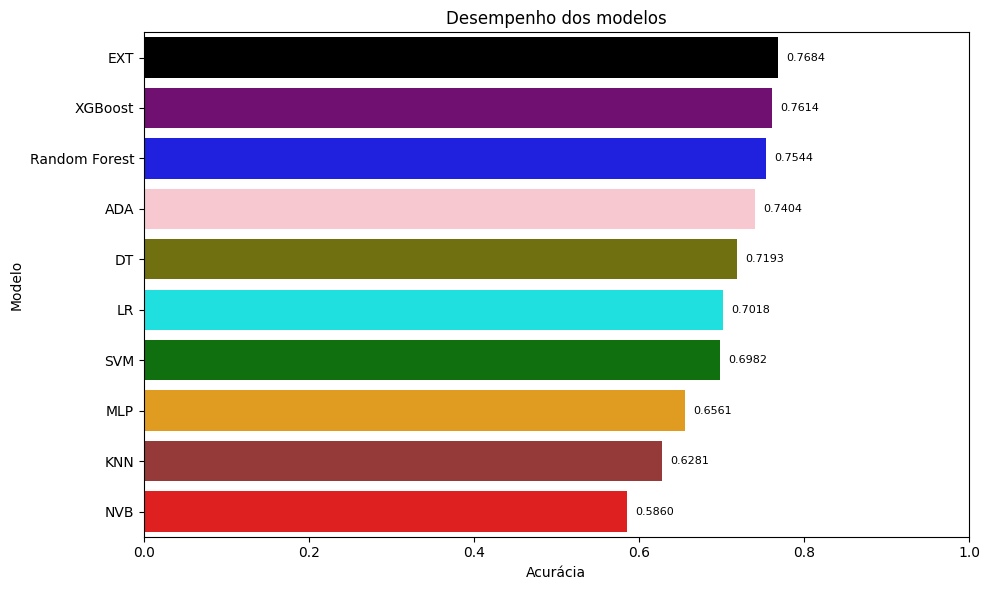



Melhor modelo: EXT | Acurácia: 0.7684210526315789

Tempo de execução total :516.80s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3895455190.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [128]:
print("========================== Data 3  =================================")
best_models3, best3 = perform_random_model_tuning(models, get_param_grid(X_train3_re, y_train3_re), "data3", X_train3_re, y_train3_re)

========================== Data 4  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  6 10 15 19 24 28 32 37 41 46 50]
max_features | [16 17 18 20 21 23 24 26 27 29 30 32 33 35 36 38 39 41 42 44]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Tempo de execução: 3.59s | Modelo: Random Forest | Acurácia: 0.5824561403508771
Parâmetros selecionados: {'n_estimators': 24, 'max_features': 16, 'max_depth': 2, 'criterion': 'gini', 'bootstrap': False}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.01818181818181818]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 260.77s | Modelo: SVM | Acurácia: 0.5614035087719299
Parâmetros selecionados: {'kernel': 'linear', 'gamma': 1e-05, 'degree': 2, 'C': 0.1}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(275,), (276,), (277,), (278,), (279,), (280,), (281,), (282,), (283,), (284,), (285,), (286,), (287,), (288,), (289,), (290,), (291,), (292,), (293,), (294,), (295,), (296,), (297,), (298,), (299,), (300,), (301,), (302,)

c:\Programs\envs\BIC\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1347) reached and the optimization hasn't converged yet.
  warnings.warn(


Tempo de execução: 290.89s | Modelo: MLP | Acurácia: 0.5403508771929824
Parâmetros selecionados: {'momentum': 0.4555555555555556, 'max_iter': 1347, 'learning_rate_init': 0.0001, 'hidden_layer_sizes': (334,)}

Tuning do modelo XGBoost iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  6 10 15 19 24 28 32 37 41 46 50]
learning_rate | [1.000e-04 1.112e-01 2.223e-01 3.334e-01 4.445e-01 5.556e-01 6.667e-01
 7.778e-01 8.889e-01 1.000e+00]
subsample | [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
gamma | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
colsample_bytree | [0.5        0.55555556 0.61111111 0.66666667 0.72222222 0.77777778
 0.83333333 0.88888889 0.94444444 1.        ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 8.70s | Modelo: XGBoost | Acurácia: 0.6140350877192983
Parâmetros selecionados: {'subsample'

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de execução: 0.34s | Modelo: NVB | Acurácia: 0.4631578947368421
Parâmetros selecionados: {'var_smoothing': 0.16949152552203392}

Tuning do modelo LR iniciado...
Paramêtros sendo testados:
penalty | ['l1', 'l2', 'elasticnet', 'none']
C | [0.001      0.07235714 0.14371429 0.21507143 0.28642857 0.35778571
 0.42914286 0.5005     0.57185714 0.64321429 0.71457143 0.78592857
 0.85728571 0.92864286 1.        ]
solver | ['saga']
max_iter | [ 100  235  371  507  642  778  914 1050 1185 1321 1457 1592 1728 1864
 2000]
l1_ratio | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 10.29s | Modelo: LR | Acurácia: 0.5859649122807018
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 1185, 'l1_ratio': 0.8888888888888888, 'C': 0.1437142857142857}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.42s | Modelo: DT 

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


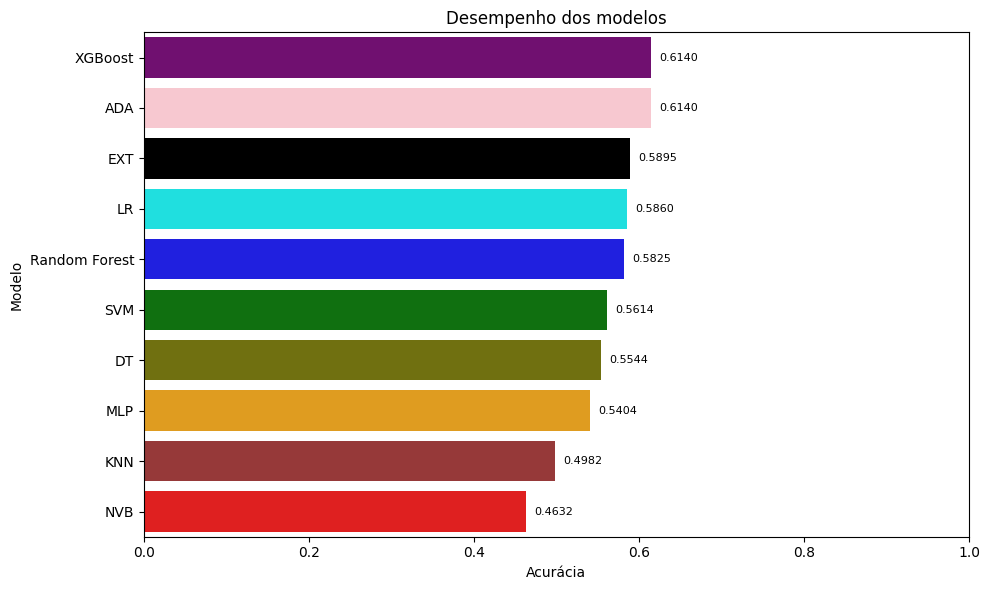



Melhor modelo: XGBoost | Acurácia: 0.6140350877192983

Tempo de execução total :596.89s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3895455190.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [129]:
print("========================== Data 4  =================================")
best_models4, best4 = perform_random_model_tuning(models, get_param_grid(X_train4_re, y_train4_re), "data4", X_train4_re, y_train4_re)

========================== Data 5  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  6 10 15 19 24 28 32 37 41 46 50]
max_features | [16 17 18 20 21 23 24 26 27 29 30 32 33 35 36 38 39 41 42 44]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Tempo de execução: 3.57s | Modelo: Random Forest | Acurácia: 0.6456140350877193
Parâmetros selecionados: {'n_estimators': 46, 'max_features': 26, 'max_depth': 2, 'criterion': 'gini', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.01818181818181818]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 460.81s | Modelo: SVM | Acurácia: 0.5789473684210525
Parâmetros selecionados: {'kernel': 'sigmoid', 'gamma': 1e-05, 'degree': 3, 'C': 10000}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(275,), (276,), (277,), (278,), (279,), (280,), (281,), (282,), (283,), (284,), (285,), (286,), (287,), (288,), (289,), (290,), (291,), (292,), (293,), (294,), (295,), (296,), (297,), (298,), (299,), (300,), (301,), (302

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de execução: 0.33s | Modelo: NVB | Acurácia: 0.47368421052631576
Parâmetros selecionados: {'var_smoothing': 0.16949152552203392}

Tuning do modelo LR iniciado...
Paramêtros sendo testados:
penalty | ['l1', 'l2', 'elasticnet', 'none']
C | [0.001      0.07235714 0.14371429 0.21507143 0.28642857 0.35778571
 0.42914286 0.5005     0.57185714 0.64321429 0.71457143 0.78592857
 0.85728571 0.92864286 1.        ]
solver | ['saga']
max_iter | [ 100  235  371  507  642  778  914 1050 1185 1321 1457 1592 1728 1864
 2000]
l1_ratio | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 9.82s | Modelo: LR | Acurácia: 0.5964912280701754
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 1457, 'l1_ratio': 0.8888888888888888, 'C': 0.1437142857142857}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.42s | Modelo: DT |

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


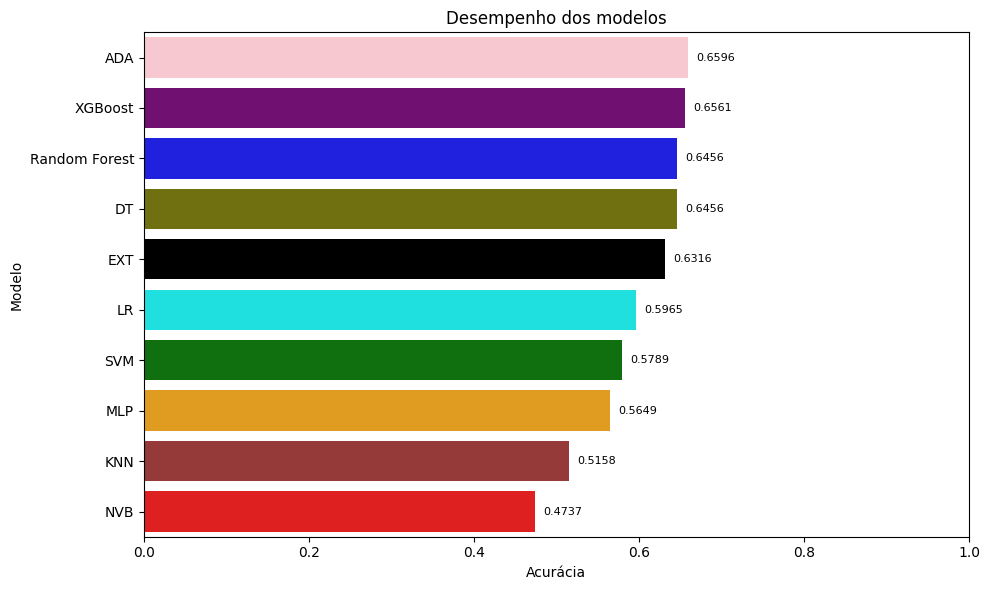



Melhor modelo: ADA | Acurácia: 0.6596491228070175

Tempo de execução total :973.07s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3895455190.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [130]:
print("========================== Data 5  =================================")
best_models5, best5 = perform_random_model_tuning(models, get_param_grid(X_train5_re, y_train5_re), "data5", X_train5_re, y_train5_re)

========================== Data 6  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  6 10 15 19 24 28 32 37 41 46 50]
max_features | [16 17 18 20 21 23 24 26 27 29 30 32 33 35 36 38 39 41 42 44]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Tempo de execução: 3.63s | Modelo: Random Forest | Acurácia: 0.7192982456140351
Parâmetros selecionados: {'n_estimators': 24, 'max_features': 26, 'max_depth': 4, 'criterion': 'entropy', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.01818181818181818]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 79.72s | Modelo: SVM | Acurácia: 0.631578947368421
Parâmetros selecionados: {'kernel': 'linear', 'gamma': 'scale', 'degree': 6, 'C': 0.1}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(275,), (276,), (277,), (278,), (279,), (280,), (281,), (282,), (283,), (284,), (285,), (286,), (287,), (288,), (289,), (290,), (291,), (292,), (293,), (294,), (295,), (296,), (297,), (298,), (299,), (300,), (301,), (302

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de execução: 0.33s | Modelo: NVB | Acurácia: 0.5052631578947369
Parâmetros selecionados: {'var_smoothing': 1e-10}

Tuning do modelo LR iniciado...
Paramêtros sendo testados:
penalty | ['l1', 'l2', 'elasticnet', 'none']
C | [0.001      0.07235714 0.14371429 0.21507143 0.28642857 0.35778571
 0.42914286 0.5005     0.57185714 0.64321429 0.71457143 0.78592857
 0.85728571 0.92864286 1.        ]
solver | ['saga']
max_iter | [ 100  235  371  507  642  778  914 1050 1185 1321 1457 1592 1728 1864
 2000]
l1_ratio | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 10.32s | Modelo: LR | Acurácia: 0.6842105263157894
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 914, 'l1_ratio': 0.0, 'C': 0.07235714285714286}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.42s | Modelo: DT | Acurácia: 0.687719298

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


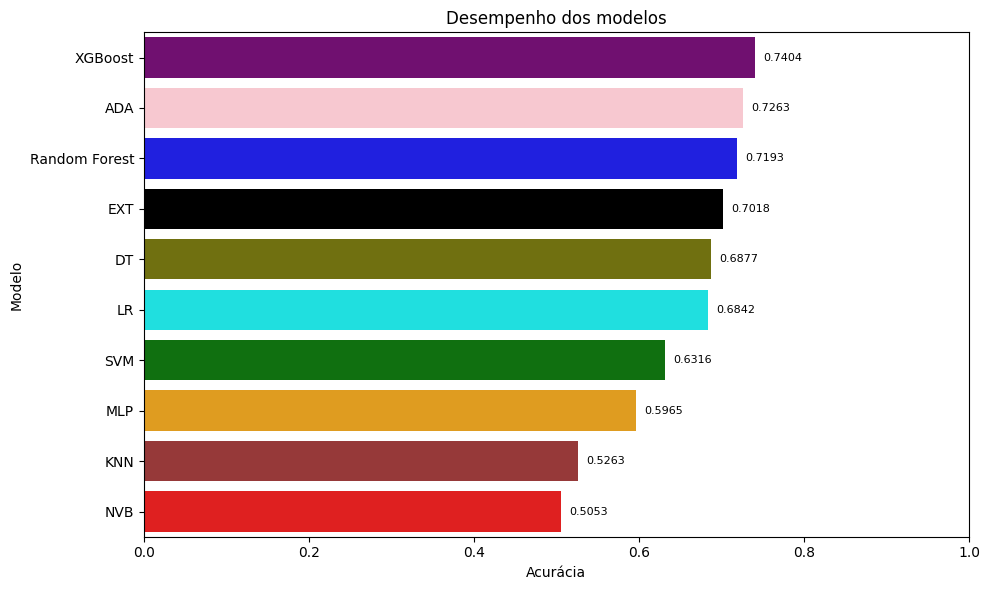



Melhor modelo: XGBoost | Acurácia: 0.7403508771929825

Tempo de execução total :516.75s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_6852\3895455190.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [131]:
print("========================== Data 6  =================================")
best_models6, best6 = perform_random_model_tuning(models, get_param_grid(X_train6_re, y_train6_re), "data6", X_train6_re, y_train6_re)

### Tunning dos modelos com base Normalizada


Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [16 17 18 20 21 23 24 25 27 28 30 31 33 34 35 37 38 40 41 43]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 6.91s | Modelo: Random Forest | Acurácia: 0.6804214929214929
Parâmetros selecionados: {'n_estimators': 51, 'max_features': 35, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': False}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.018518518518518517]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 3149.90s | Modelo: SVM | Acurácia: 0.673

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Tempo de execução: 8.01s | Modelo: LR | Acurácia: 0.6786036036036036
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1457, 'l1_ratio': 0.0, 'C': 0.21507142857142858}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.24s | Modelo: DT | Acurácia: 0.666071428

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_16460\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


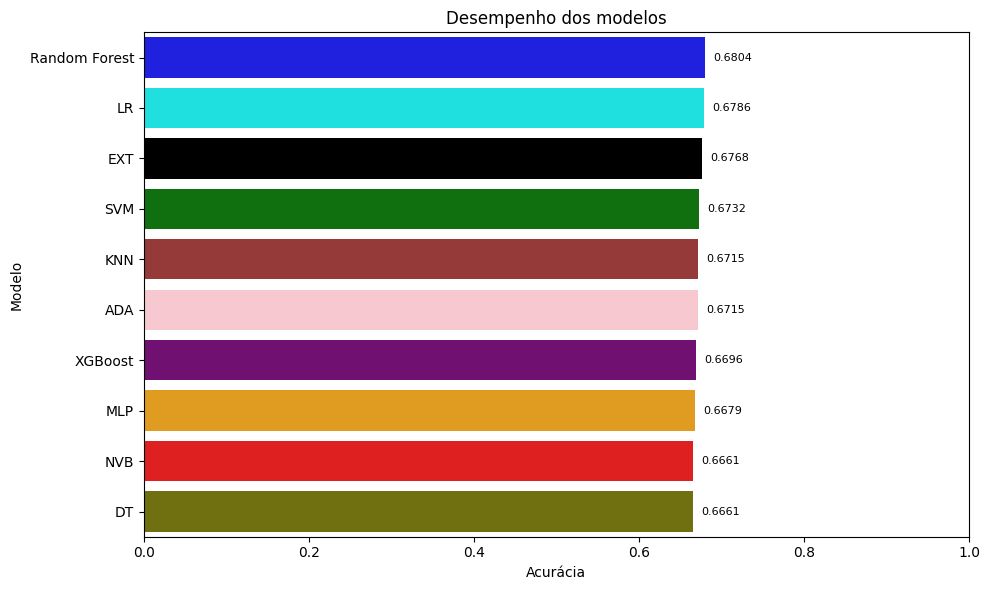



Melhor modelo: Random Forest | Acurácia: 0.6804214929214929

Tempo de execução total :3574.14s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_16460\272180645.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [34]:
best_models1_norm, best1_norm = perform_random_model_tuning(models, get_param_grid(X_train1_norm, y_train1), "data1_norm", X_train1_norm, y_train1)


Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  3  5  7 10 12 14 16 18 20 22 24 27 29 31 33 35 37 39 42]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [25 27 29 31 33 36 38 40 42 44 47 49 51 53 55 58 60 62 64 67]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Tempo de execução: 4.79s | Modelo: Random Forest | Acurácia: 0.7918275418275418
Parâmetros selecionados: {'n_estimators': 42, 'max_features': 42, 'max_depth': 29, 'criterion': 'entropy', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.011904761904761904]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 1041.31s | Modelo: SVM | Acurácia: 0.7594594594594595
Parâmetros selecionados: {'kernel': 'sigmoid', 'gamma': 0.01, 'degree': 5, 'C': 1}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(420,), (421,), (422,), (423,), (424,), (425,), (426,), (427,), (428,), (429,), (430,), (431,), (432,), (433,), (434,), (435,), (436,), (437,), (438,), (439,), (440,), (441,), (442,), (443,), (444,), (445,), (446,), (44

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de execução: 0.21s | Modelo: NVB | Acurácia: 0.7684362934362934
Parâmetros selecionados: {'var_smoothing': 3.3898305085406784}

Tuning do modelo LR iniciado...
Paramêtros sendo testados:
penalty | ['l1', 'l2', 'elasticnet', 'none']
C | [0.001      0.07235714 0.14371429 0.21507143 0.28642857 0.35778571
 0.42914286 0.5005     0.57185714 0.64321429 0.71457143 0.78592857
 0.85728571 0.92864286 1.        ]
solver | ['saga']
max_iter | [ 100  235  371  507  642  778  914 1050 1185 1321 1457 1592 1728 1864
 2000]
l1_ratio | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 18.31s | Modelo: LR | Acurácia: 0.7738095238095238
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 1185, 'l1_ratio': 0.3333333333333333, 'C': 0.07235714285714286}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini',

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_16460\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


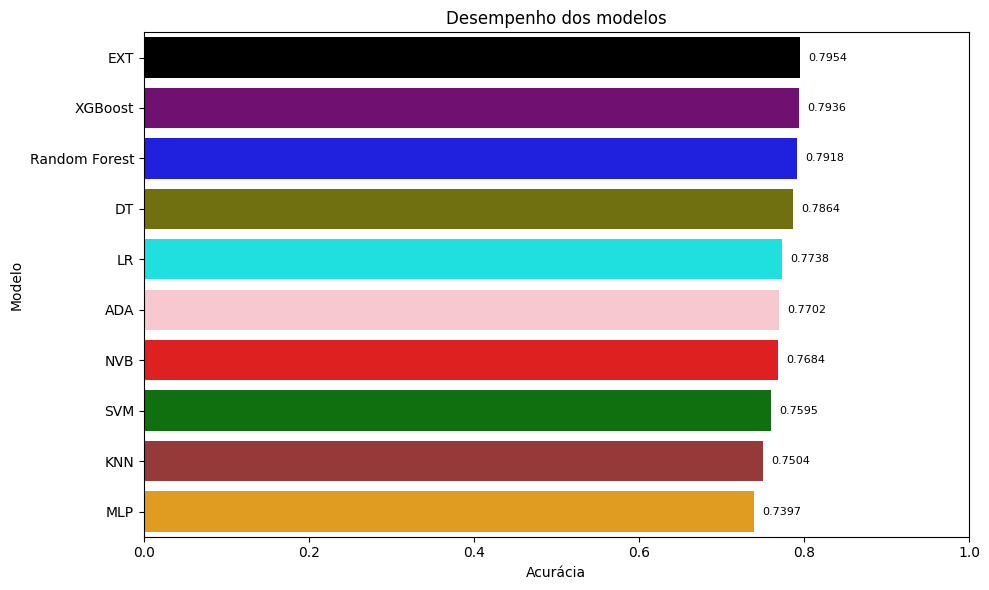



Melhor modelo: EXT | Acurácia: 0.7954472329472329

Tempo de execução total :2028.27s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_16460\272180645.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [35]:
best_models2_norm, best2_norm = perform_random_model_tuning(models, get_param_grid(X_train2_norm, y_train2), "data2_norm", X_train2_norm, y_train2)


Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  3  4  5  7  8 10 11 13 14 16 17 18 20 21 23 24 26 27 29]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [17 18 20 21 23 24 26 27 29 30 32 33 35 36 38 39 41 42 44 46]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Tempo de execução: 3.86s | Modelo: Random Forest | Acurácia: 0.7935649935649935
Parâmetros selecionados: {'n_estimators': 33, 'max_features': 46, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.017241379310344827]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 961.58s | Modelo: SVM | Acurácia: 0.759411196911197
Parâmetros selecionados: {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 4, 'C': 100}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(290,), (291,), (292,), (293,), (294,), (295,), (296,), (297,), (298,), (299,), (300,), (301,), (302,), (303,), (304,), (305,), (306,), (307,), (308,), (309,), (310,), (311,), (312,), (313,), (314,), (315,), (316,), (317,), (

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Tempo de execução: 7.05s | Modelo: LR | Acurácia: 0.7792149292149293
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1864, 'l1_ratio': 0.4444444444444444, 'C': 0.1437142857142857}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  3  4  5  7  8 10 11 13 14 16 17 18 20 21 23 24 26 27 29]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.23s | Modelo: DT | Acuráci

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_16460\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


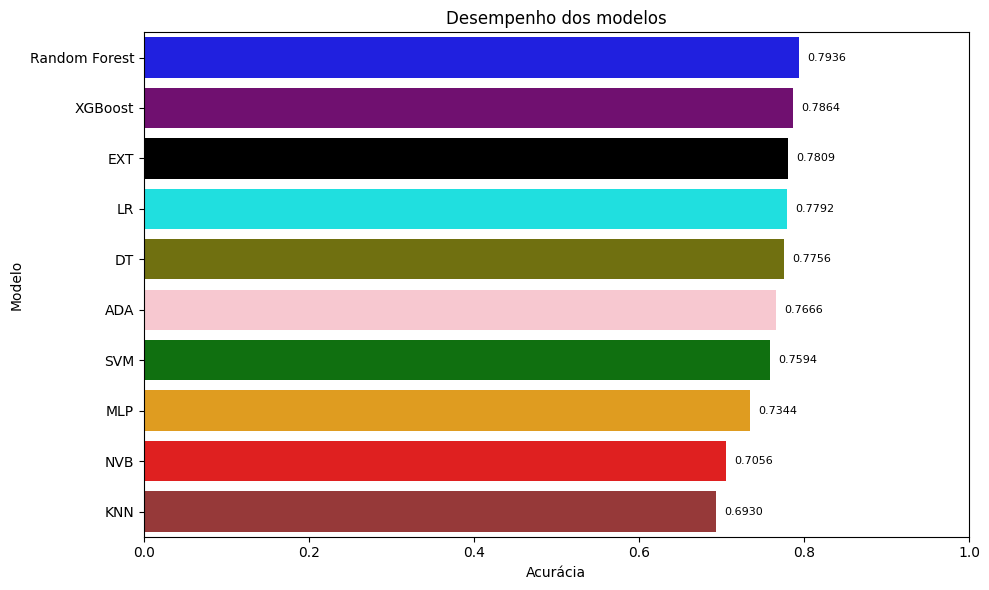



Melhor modelo: Random Forest | Acurácia: 0.7935649935649935

Tempo de execução total :1353.11s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_16460\272180645.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [36]:
best_models3_norm, best3_norm = perform_random_model_tuning(models, get_param_grid(X_train3_norm, y_train3), "data3_norm", X_train3_norm, y_train3)


Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [16 17 18 20 21 23 24 26 27 29 30 32 33 35 36 38 39 41 42 44]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Tempo de execução: 3.78s | Modelo: Random Forest | Acurácia: 0.680518018018018
Parâmetros selecionados: {'n_estimators': 1, 'max_features': 24, 'max_depth': 2, 'criterion': 'gini', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.01818181818181818]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 1064.11s | Modelo: SVM | Acurácia: 0.6786196911196911
Parâmetros selecionados: {'kernel': 'rbf', 'gamma': 0.0001, 'degree': 4, 'C': 100}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(275,), (276,), (277,), (278,), (279,), (280,), (281,), (282,), (283,), (284,), (285,), (286,), (287,), (288,), (289,), (290,), (291,), (292,), (293,), (294,), (295,), (296,), (297,), (298,), (299,), (300,), (301,), (302,), (3

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Tempo de execução: 5.88s | Modelo: LR | Acurácia: 0.6911840411840412
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1864, 'l1_ratio': 0.4444444444444444, 'C': 0.1437142857142857}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.22s | Modelo: DT | Acuráci

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_16460\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


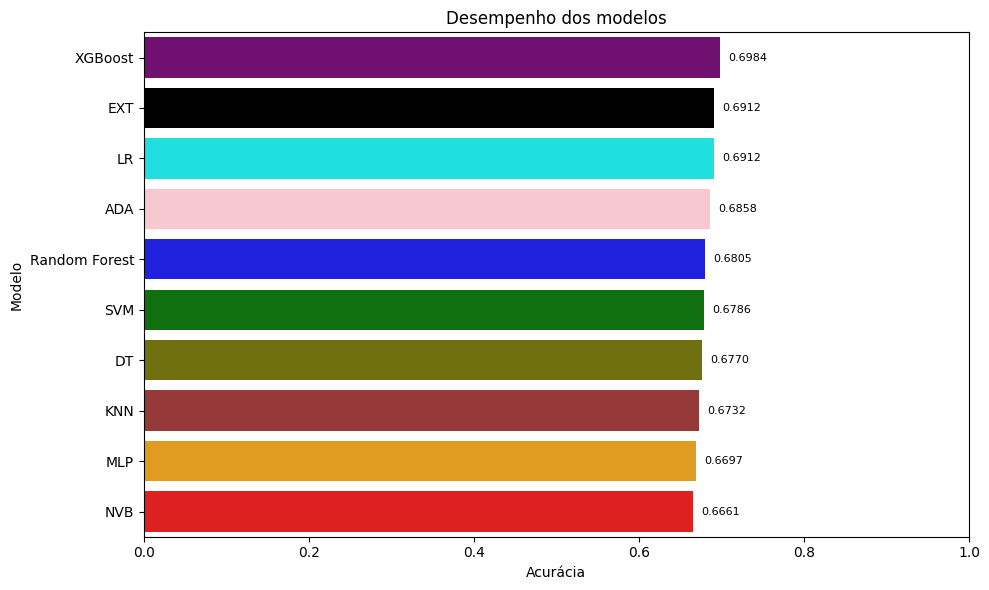



Melhor modelo: XGBoost | Acurácia: 0.6983912483912483

Tempo de execução total :1456.20s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_16460\272180645.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [37]:
best_models4_norm, best4_norm = perform_random_model_tuning(models, get_param_grid(X_train4_norm, y_train4), "data4_norm", X_train4_norm, y_train4)


Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [16 17 18 20 21 23 24 26 27 29 30 32 33 35 36 38 39 41 42 44]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 3.76s | Modelo: Random Forest | Acurácia: 0.7055019305019304
Parâmetros selecionados: {'n_estimators': 15, 'max_features': 17, 'max_depth': 10, 'criterion': 'gini', 'bootstrap': False}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.01818181818181818]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 1087.18s | Modelo: SVM | Acurácia: 0.689366

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Tempo de execução: 5.44s | Modelo: LR | Acurácia: 0.7109555984555985
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1864, 'l1_ratio': 0.4444444444444444, 'C': 0.1437142857142857}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.22s | Modelo: DT | Acuráci

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_16460\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


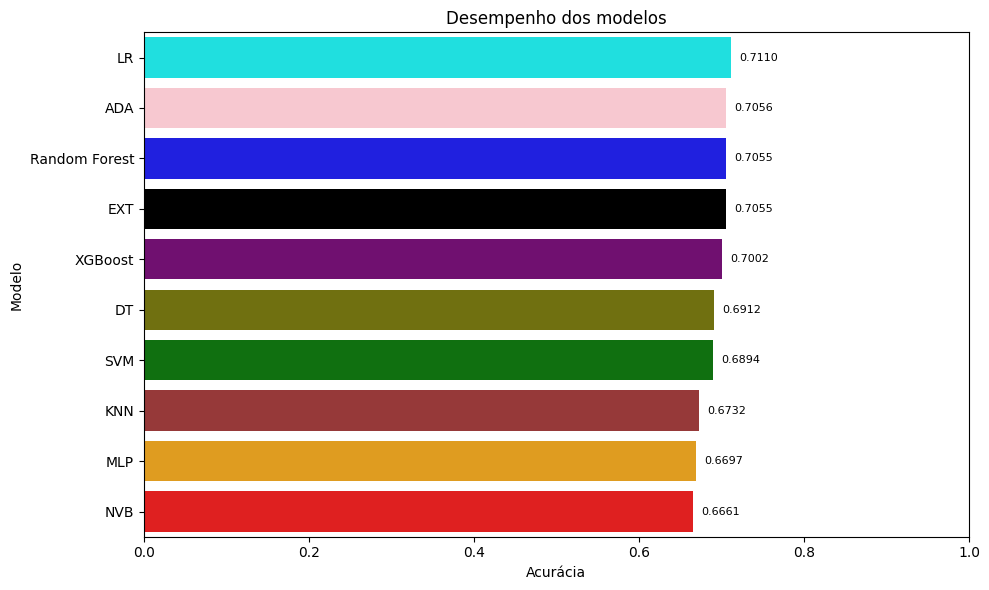



Melhor modelo: LR | Acurácia: 0.7109555984555985

Tempo de execução total :1472.67s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_16460\272180645.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [38]:
best_models5_norm, best5_norm = perform_random_model_tuning(models, get_param_grid(X_train5_norm, y_train5), "data5_norm", X_train5_norm, y_train5)


Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [16 17 18 20 21 23 24 26 27 29 30 32 33 35 36 38 39 41 42 44]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 3.83s | Modelo: Random Forest | Acurácia: 0.763030888030888
Parâmetros selecionados: {'n_estimators': 33, 'max_features': 24, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.01818181818181818]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 637.13s | Modelo: SVM | Acurácia: 0.7342985842

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Tempo de execução: 5.60s | Modelo: LR | Acurácia: 0.7665862290862291
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1864, 'l1_ratio': 0.4444444444444444, 'C': 0.1437142857142857}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 0.23s | Modelo: DT | Acuráci

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_16460\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


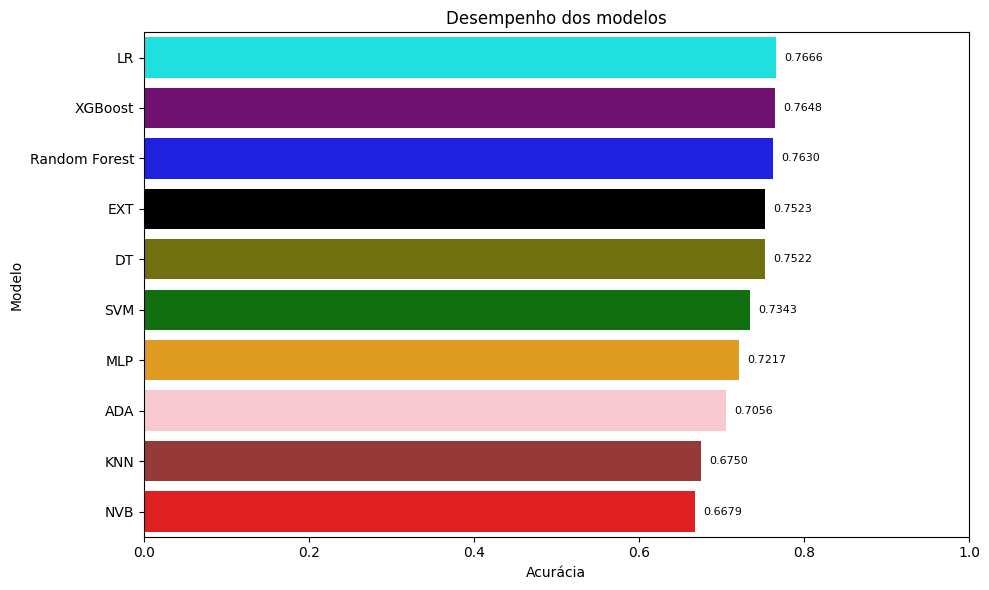



Melhor modelo: LR | Acurácia: 0.7665862290862291

Tempo de execução total :990.28s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_16460\272180645.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [39]:
best_models6_norm, best6_norm = perform_random_model_tuning(models, get_param_grid(X_train6_norm, y_train6), "data6_norm", X_train6_norm, y_train6)

### [Abrir TODOS os modelos treinados com pickle]

#### Sem Random Under-Sampling

In [16]:
# importando best_models1 a 6
print("========================== Data 1  =================================")
with open('data1_desb_best_model.pkl', 'rb') as file:
    best1_desb = pickle.load(file)
print("========================== Data 2  =================================")
with open('data2_desb_best_model.pkl', 'rb') as file:
    best2_desb = pickle.load(file)

print("========================== Data 3  =================================")
with open('data3_desb_best_model.pkl', 'rb') as file:
    best3_desb = pickle.load(file)

print("========================== Data 4  =================================")
with open('data4_desb_best_model.pkl', 'rb') as file:
    best4_desb = pickle.load(file)

print("========================== Data 5  =================================")
with open('data5_desb_best_model.pkl', 'rb') as file:
    best5_desb = pickle.load(file)

print("========================== Data 6  =================================")
with open('data6_desb_best_model.pkl', 'rb') as file:
    best6_desb = pickle.load(file)


========================== Data 1  =================================
========================== Data 2  =================================
========================== Data 3  =================================
========================== Data 4  =================================
========================== Data 5  =================================
========================== Data 6  =================================


#### Com Random Under-Sampling

In [17]:
# importando best_models1 a 6
# print("========================== Data 1  =================================")
# with open('data1_best_model.pkl', 'rb') as file:
#     best1 = pickle.load(file)
print("========================== Data 2  =================================")
with open('data2_best_model.pkl', 'rb') as file:
    best2 = pickle.load(file)

print("========================== Data 3  =================================")
with open('data3_best_model.pkl', 'rb') as file:
    best3 = pickle.load(file)

print("========================== Data 4  =================================")
with open('data4_best_model.pkl', 'rb') as file:
    best4 = pickle.load(file)

print("========================== Data 5  =================================")
with open('data5_best_model.pkl', 'rb') as file:
    best5 = pickle.load(file)

print("========================== Data 6  =================================")
with open('data6_best_model.pkl', 'rb') as file:
    best6 = pickle.load(file)


========================== Data 2  =================================
========================== Data 3  =================================
========================== Data 4  =================================
========================== Data 5  =================================
========================== Data 6  =================================


#### Com base Normalizada

In [18]:
print("========================== Data 1  =================================")
with open('data1_norm_best_model.pkl', 'rb') as file:
    best1_norm = pickle.load(file)

print("========================== Data 2  =================================")
with open('data2_norm_best_model.pkl', 'rb') as file:
    best2_norm = pickle.load(file)

print("========================== Data 3  =================================")
with open('data3_norm_best_model.pkl', 'rb') as file:
    best3_norm = pickle.load(file)

print("========================== Data 4  =================================")
with open('data4_norm_best_model.pkl', 'rb') as file:
    best4_norm = pickle.load(file)

print("========================== Data 5  =================================")
with open('data5_norm_best_model.pkl', 'rb') as file:
    best5_norm = pickle.load(file)

print("========================== Data 6  =================================")
with open('data6_norm_best_model.pkl', 'rb') as file:
    best6_norm = pickle.load(file)

========================== Data 1  =================================
========================== Data 2  =================================
========================== Data 3  =================================
========================== Data 4  =================================
========================== Data 5  =================================
========================== Data 6  =================================


### Selecionando o melhor modelo de cada base

#### Sem Random Under-Sampling

In [19]:
modelo1_desb = best1_desb
modelo1_desb

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=9,
                       max_features=24, n_estimators=42, n_jobs=16,
                       random_state=13)

In [20]:
modelo2_desb = best2_desb
modelo2_desb

ExtraTreesClassifier(bootstrap=True, criterion='entropy', max_depth=10,
                     max_features=49, n_estimators=39, n_jobs=16,
                     random_state=13)

In [21]:
modelo3_desb = best3_desb
modelo3_desb

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=5,
                       max_features=42, n_estimators=33, n_jobs=16,
                       random_state=13)

In [22]:
modelo4_desb = best4_desb
modelo4_desb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7777777777777778, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5555555555555556,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2223, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=24, n_jobs=16,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [23]:
modelo5_desb = best5_desb
modelo5_desb

RandomForestClassifier(bootstrap=False, max_depth=10, max_features=17,
                       n_estimators=24, n_jobs=16, random_state=13)

In [24]:
modelo6_desb = best6_desb
modelo6_desb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7777777777777778, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.4444444444444444,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2223, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=11, n_jobs=16,
              num_parallel_tree=None, objective='multi:softprob', ...)

#### Com Random Under-Sampling

In [25]:
modelo1 = best1
modelo1

NameError: name 'best1' is not defined

In [39]:
modelo2 = best2
modelo2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6111111111111112, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.7777777777777777,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2223, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=24, n_jobs=16,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [26]:
modelo3 = best3
modelo3

ExtraTreesClassifier(criterion='entropy', max_depth=5, max_features=21,
                     n_estimators=38, n_jobs=16, random_state=13)

In [27]:
modelo4 = best4
modelo4

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.7777777777777777, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11120000000000001,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=24, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=19, n_jobs=16,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [28]:
modelo5 = best5
modelo5

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.035448275862068966,
                   n_estimators=282, random_state=13)

In [29]:
modelo6 = best6
modelo6

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6666666666666666, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.6666666666666666,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11120000000000001,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=27, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=37, n_jobs=16,
              num_parallel_tree=None, objective='multi:softprob', ...)

#### Normalizado

In [30]:
modelo1_norm = best1_norm
modelo1_norm

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=5,
                       max_features=25, n_estimators=47, n_jobs=16,
                       random_state=13)

In [31]:

modelo2_norm = best2_norm
modelo2_norm

ExtraTreesClassifier(bootstrap=True, criterion='entropy', max_depth=36,
                     max_features=43, n_estimators=33, n_jobs=16,
                     random_state=13)

In [32]:

modelo3_norm = best3_norm
modelo3_norm

RandomForestClassifier(max_depth=3, max_features=46, n_estimators=33, n_jobs=16,
                       random_state=13)

In [33]:

modelo4_norm = best4_norm
modelo4_norm

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7777777777777778, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.6666666666666666,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.33340000000000003,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=42, n_jobs=16,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [34]:

modelo5_norm = best5_norm
modelo5_norm

LogisticRegression(C=0.1437142857142857, l1_ratio=0.4444444444444444,
                   max_iter=1864, n_jobs=16, penalty='l1', random_state=13,
                   solver='saga')

In [35]:

modelo6_norm = best6_norm
modelo6_norm

LogisticRegression(C=0.1437142857142857, l1_ratio=0.4444444444444444,
                   max_iter=1864, n_jobs=16, penalty='l1', random_state=13,
                   solver='saga')

### Avaliando os modelos com os melhores parâmetros

#### Sem Random Under-Sampling

##### Base 2 - Com WHOQOL Completo

In [65]:
from sklearn.ensemble import RandomForestClassifier
# # Create a RandomForestClassifier model with the given parameters
model__ = RandomForestClassifier(n_estimators=51, max_features=29, max_depth=39, criterion='gini', bootstrap=True)


In [83]:
perform_cross_validation(modelo2_desb, X_train2, y_train2, 5, True)

Cross Validation Scores:
Accuracy: 0.7834 (+/- 0.0466)
Class 0 - Precision: 0.6905, Recall: 0.4874, F1 Score: 0.5714
Class 1 - Precision: 0.8090, Recall: 0.6050, F1 Score: 0.6923
Class 2 - Precision: 0.7939, Recall: 0.9063, F1 Score: 0.8464


{'fit_time': array([0.09302092, 0.08998919, 0.09353232, 0.0900178 , 0.09405899]),
 'score_time': array([0.0195713 , 0.02008939, 0.01881576, 0.0195713 , 0.01880717]),
 'test_score': array([0.75      , 0.78571429, 0.76978417, 0.82014388, 0.79136691])}

##### Base 3 - Com WHOQOL Domínios

In [81]:
perform_cross_validation(modelo3_desb, X_train3, y_train3, 5)

Cross Validation Scores:
Accuracy: 0.7662 (+/- 0.0723)
Class 0 - Precision: 0.6562, Recall: 0.5294, F1 Score: 0.5860
Class 1 - Precision: 0.7143, Recall: 0.6303, F1 Score: 0.6696
Class 2 - Precision: 0.7984, Recall: 0.8627, F1 Score: 0.8293


{'fit_time': array([0.05555034, 0.05455089, 0.05455089, 0.05506301, 0.05757523]),
 'score_time': array([0.01796174, 0.01796174, 0.01796174, 0.01745653, 0.01845574]),
 'test_score': array([0.74285714, 0.75      , 0.73381295, 0.83453237, 0.76978417])}

#### Com Random Under-Sampling

##### Base 2 - Com WHOQOL Completo

In [84]:
perform_cross_validation(modelo2, X_train2_re, y_train2_re, 5)

Cross Validation Scores:
Accuracy: 0.7649 (+/- 0.1313)
Class 0 - Precision: 0.7778, Recall: 0.7647, F1 Score: 0.7712
Class 1 - Precision: 0.8803, Recall: 0.8655, F1 Score: 0.8729
Class 2 - Precision: 0.6423, Recall: 0.6639, F1 Score: 0.6529


{'fit_time': array([0.08161974, 0.07711077, 0.07862735, 0.09314227, 0.09513879]),
 'score_time': array([0.01252294, 0.01503253, 0.01451588, 0.01251316, 0.01352358]),
 'test_score': array([0.65277778, 0.81944444, 0.78873239, 0.83098592, 0.73239437])}

##### Base 3 - Com WHOQOL Domínios

In [85]:
perform_cross_validation(modelo3, X_train3_re, y_train3_re, 5)

Cross Validation Scores:
Accuracy: 0.7647 (+/- 0.1113)
Class 0 - Precision: 0.7724, Recall: 0.7983, F1 Score: 0.7851
Class 1 - Precision: 0.8425, Recall: 0.8992, F1 Score: 0.8699
Class 2 - Precision: 0.6636, Recall: 0.5966, F1 Score: 0.6283


{'fit_time': array([0.049546  , 0.04854703, 0.04906225, 0.05084729, 0.04806876]),
 'score_time': array([0.01881814, 0.02023983, 0.01927185, 0.01900315, 0.01927042]),
 'test_score': array([0.70833333, 0.83333333, 0.71830986, 0.83098592, 0.73239437])}

#### Com base Normalizada

##### Base 2 - Com WHOQOL Completo

In [86]:
perform_cross_validation(modelo2_norm, X_train2_norm, y_train2, 5)

Cross Validation Scores:
Accuracy: 0.7762 (+/- 0.0546)
Class 0 - Precision: 0.7632, Recall: 0.4874, F1 Score: 0.5949
Class 1 - Precision: 0.7143, Recall: 0.5882, F1 Score: 0.6452
Class 2 - Precision: 0.7897, Recall: 0.8998, F1 Score: 0.8411


{'fit_time': array([0.06752348, 0.05798745, 0.06550813, 0.0725584 , 0.06451154]),
 'score_time': array([0.0182991 , 0.01798153, 0.01830292, 0.01787281, 0.01930809]),
 'test_score': array([0.76428571, 0.77857143, 0.74820144, 0.82733813, 0.76258993])}

##### Base 3 - Com WHOQOL Domínios

In [87]:
perform_cross_validation(modelo3_norm, X_train3_norm, y_train3, 5)

Cross Validation Scores:
Accuracy: 0.7647 (+/- 0.0562)
Class 0 - Precision: 0.6633, Recall: 0.5462, F1 Score: 0.5991
Class 1 - Precision: 0.7283, Recall: 0.5630, F1 Score: 0.6351
Class 2 - Precision: 0.7909, Recall: 0.8736, F1 Score: 0.8302


{'fit_time': array([0.05743885, 0.05643272, 0.05743885, 0.0580523 , 0.05543303]),
 'score_time': array([0.02002883, 0.01950526, 0.02002883, 0.01841569, 0.0181427 ]),
 'test_score': array([0.73571429, 0.79285714, 0.72661871, 0.79136691, 0.77697842])}

### Salvando os modelos 

In [75]:
# Salvando modelo1 à 4 em pickle
#with open('modelo1.pkl', 'wb') as f:
#    pickle.dump(modelo1, f)
with open('modelo2.pkl', 'wb') as f:
   pickle.dump(modelo2, f)
with open('modelo3.pkl', 'wb') as f:
   pickle.dump(modelo3, f)
#with open('modelo4.pkl', 'wb') as f:
#    pickle.dump(modelo4, f)
# with open('modelo5.pkl', 'wb') as f:
#     pickle.dump(modelo5, f)
# with open('modelo6.pkl', 'wb') as f:
#     pickle.dump(modelo6, f)

### Avaliando os modelos com cross validation

In [ ]:
# Analisar cross validation para cada um dos modelos
# print("========================== Data 1  =================================")
# c1 = cross_val_score(modelo1, data1_re, target1_re , cv=5)
# print(c1)
# print(c1.mean())

# perform_cross_validation(modelo1, data1_re, target1_re, 5, True)

In [59]:
from sklearn.model_selection import cross_val_score
print("========================== Data 2  =================================")
c2 = cross_val_score(modelo2_desb,  X_test2 , y_test2, cv=5)
print(c2)
print(c2.mean())

perform_cross_validation(modelo2_desb, X_train2 , y_train2, 5, True)

========================== Data 2  =================================
[0.68571429 0.71428571 0.71428571 0.77142857 0.68571429]
0.7142857142857142
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.25      0.36        20
           1       0.76      0.57      0.65        23
           2       0.78      0.93      0.85        96

    accuracy                           0.77       139
   macro avg       0.72      0.58      0.62       139
weighted avg       0.76      0.77      0.74       139

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.52      0.58        25
           1       0.79      0.62      0.70        24
           2       0.79      0.88      0.83        90

    accuracy                           0.77       139
   macro avg       0.74      0.67      0.70       139
weighted avg       0.76      0.77    

In [60]:
print("========================== Data 3  =================================")
c3 = cross_val_score(modelo3_desb,  X_test3 , y_test3, cv=5)
print(c3)
print(c3.mean())

perform_cross_validation(modelo3_desb, X_train3 , y_train3, 5, True)

========================== Data 3  =================================
[0.62857143 0.6        0.65714286 0.71428571 0.65714286]
0.6514285714285715
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.35      0.42        20
           1       0.70      0.61      0.65        23
           2       0.79      0.88      0.83        96

    accuracy                           0.76       139
   macro avg       0.68      0.61      0.64       139
weighted avg       0.74      0.76      0.74       139

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        25
           1       0.64      0.58      0.61        24
           2       0.79      0.81      0.80        90

    accuracy                           0.74       139
   macro avg       0.69      0.68      0.68       139
weighted avg       0.74      0.74    

In [61]:
print("========================== Data 4  =================================")
c4 = cross_val_score(modelo4_desb,  X_test4 , y_test4, cv=5)
print(c4)
print(c4.mean())

perform_cross_validation(modelo4_desb, X_train4 , y_train4, 5, True)

========================== Data 4  =================================
[0.54285714 0.62857143 0.62857143 0.71428571 0.54285714]
0.6114285714285714
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.30      0.39        20
           1       0.64      0.30      0.41        23
           2       0.74      0.91      0.82        96

    accuracy                           0.72       139
   macro avg       0.64      0.50      0.54       139
weighted avg       0.70      0.72      0.69       139

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.16      0.25        25
           1       0.39      0.38      0.38        24
           2       0.68      0.82      0.74        90

    accuracy                           0.63       139
   macro avg       0.55      0.45      0.46       139
weighted avg       0.61      0.63    

In [70]:
print("========================== Data 5  =================================")
c5 = cross_val_score(modelo5_desb,  X_train5 , y_train5, cv=5, scoring='accuracy')
print(c5)
print(c5.mean())

perform_cross_validation(modelo5_desb, X_train5 , y_train5, 5, True)

========================== Data 5  =================================
[0.64285714 0.62142857 0.65467626 0.73381295 0.6618705 ]
0.662929085303186
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.25      0.30        20
           1       0.46      0.26      0.33        23
           2       0.72      0.84      0.78        96

    accuracy                           0.66       139
   macro avg       0.52      0.45      0.47       139
weighted avg       0.63      0.66      0.63       139

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.12      0.18        25
           1       0.45      0.38      0.41        24
           2       0.67      0.82      0.74        90

    accuracy                           0.62       139
   macro avg       0.50      0.44      0.44       139
weighted avg       0.58      0.62     

In [63]:
print("========================== Data 6  =================================")
c6 = cross_val_score(modelo6_desb,  X_test6 , y_test6, cv=5)
print(c6)
print(c6.mean())

perform_cross_validation(modelo6_desb, X_train6 , y_train6, 5, True)

========================== Data 6  =================================
[0.68571429 0.65714286 0.65714286 0.71428571 0.68571429]
0.68
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.25      0.36        20
           1       0.90      0.39      0.55        23
           2       0.76      0.96      0.85        96

    accuracy                           0.76       139
   macro avg       0.76      0.53      0.58       139
weighted avg       0.76      0.76      0.73       139

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.28      0.41        25
           1       0.72      0.54      0.62        24
           2       0.74      0.92      0.82        90

    accuracy                           0.74       139
   macro avg       0.75      0.58      0.62       139
weighted avg       0.74      0.74      0.71       1

## Feature Selection

In [59]:
updt_maxfeature(modelo1_desb)
updt_maxfeature(modelo2_desb)
updt_maxfeature(modelo3_desb)
updt_maxfeature(modelo4_desb)
updt_maxfeature(modelo5_desb)
updt_maxfeature(modelo6_desb)

updt_maxfeature(modelo1)
updt_maxfeature(modelo2)
updt_maxfeature(modelo3)
updt_maxfeature(modelo4)
updt_maxfeature(modelo5)
updt_maxfeature(modelo6)

### Aplicando SBFS e SFFS

#### Feature Selection nas bases sem Random Under-Sampling

========================== Data 1  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    8.6s remaining:    0.4s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    8.8s finished

[2023-12-26 13:25:59] Features: 53/1 -- score: 0.6657348406988695[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    7.6s remaining:    0.5s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    7.8s finished

[2023-12-26 13:26:07] Features: 52/1 -- score: 0.6642857142857143[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done  48 out of  52 | elapsed:    6.7s remaining:    0.5s
[Parallel(n_jobs=16)]: Done  52 out of  52 | elapsed:    6.9s fini

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    4.5s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    4.5s finished

[2023-12-26 13:34:51] Features: 1/54 -- score: 0.658540596094553[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    1.7s finished

[2023-12-26 13:34:53] Features: 2/54 -- score: 0.658540596094553[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  48 out of  52 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  52 out of  52 | elapsed:    1.5s finish

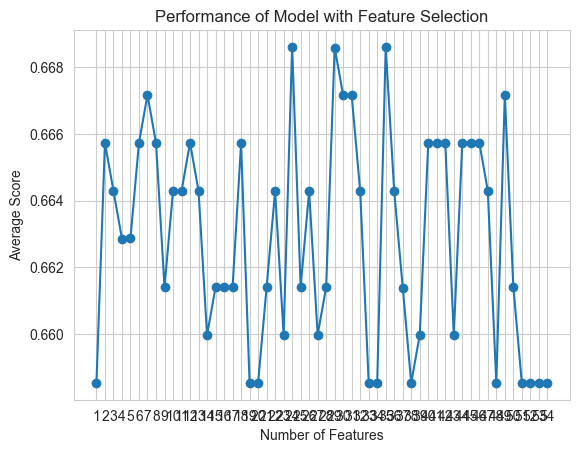

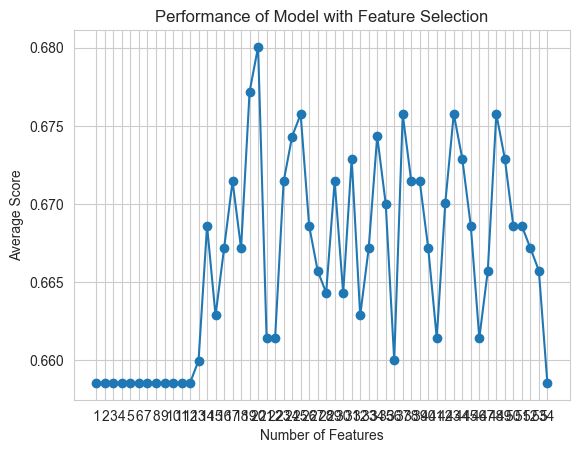

In [32]:
print("========================== Data 1  =================================")
print("SBFS")
slt_sbfs_features1_desb, score1_sbfs_desb = perform_feature_selection(X_train1, y_train1, modelo1_desb, "data1_desb", 'SBFS', 5)
print("SFFS")
slt_sffs_features1_desb, score1_sffs_desb = perform_feature_selection(X_train1, y_train1, modelo1_desb, "data1_desb", 'SFFS', 5)

========================== Data 2  =================================


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done  84 out of  84 | elapsed:    7.1s finished

[2024-01-15 15:49:31] Features: 83/1 -- score: 0.7991675231243577[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  83 out of  83 | elapsed:    5.6s finished

[2024-01-15 15:49:37] Features: 82/1 -- score: 0.7920143884892086[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done  82 out of  82 | elapsed:    5.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.4s finished

[2024-01-15 15:49:44] Features: 81/1 -- score: 0.7977286742034945[Parallel(n_jobs=16)]: Usin

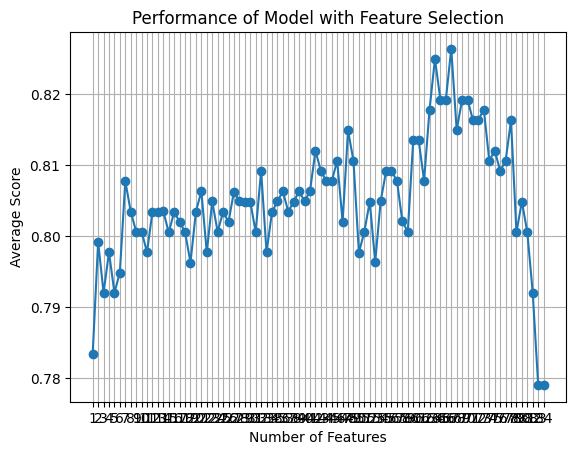

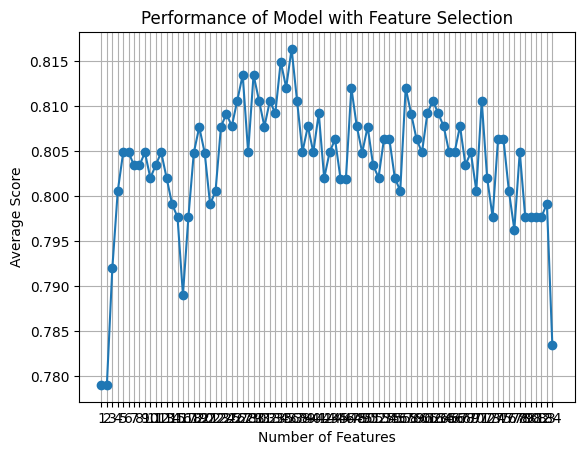

In [36]:
print("========================== Data 2  =================================")
slt_sbfs_features2_desb, score2_sbfs_desb = perform_feature_selection(X_train2, y_train2, modelo2_desb, "data2_desb", 'SBFS', 5)
slt_sffs_features2_desb, score2_sffs_desb = perform_feature_selection(X_train2, y_train2, modelo2_desb, "data2_desb", 'SFFS', 5)

========================== Data 3  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  58 out of  58 | elapsed:    2.6s finished

[2024-01-15 16:22:13] Features: 57/1 -- score: 0.7704727646454266[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  55 out of  57 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  57 out of  57 | elapsed:    2.6s finished

[2024-01-15 16:22:15] Features: 56/1 -- score: 0.7819424460431654[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  54 out of  56 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  56 out of  56 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  58 out of  58 | elapsed:    1.6s finished

[2024-01-15 16:28:43] Features: 1/58 -- score: 0.7790133607399794[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  55 out of  57 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  57 out of  57 | elapsed:    1.6s finished

[2024-01-15 16:28:45] Features: 2/58 -- score: 0.7847687564234327[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  54 out of  56 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  56 out of  56 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[

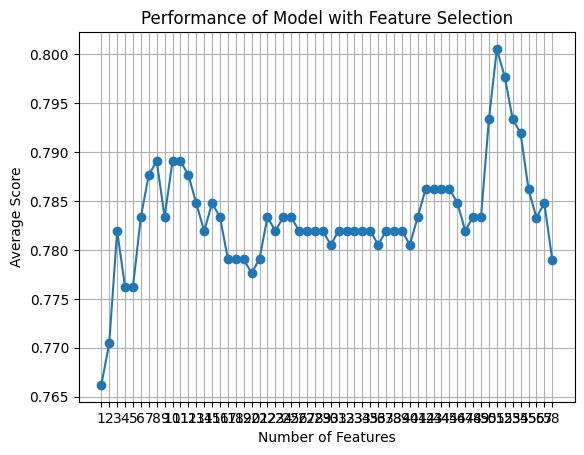

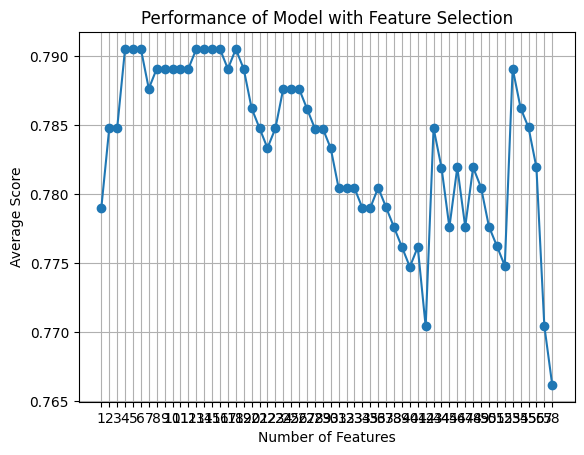

In [37]:
print("========================== Data 3  =================================")
print("SBFS")
slt_sbfs_features3_desb, score3_sbfs_desb = perform_feature_selection(X_train3, y_train3, modelo3_desb, "data3_desb", 'SBFS', 5)
print("SFFS")
slt_sffs_features3_desb, score3_sffs_desb = perform_feature_selection(X_train3, y_train3, modelo3_desb, "data3_desb", 'SFFS', 5)

========================== Data 4  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    0.9s finished

[2023-12-26 13:44:47] Features: 54/1 -- score: 0.6871942446043164[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.6s finished

[2023-12-26 13:44:48] Features: 53/1 -- score: 0.687235354573484[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    0.6s finis

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    0.2s finished

[2023-12-26 13:47:30] Features: 1/55 -- score: 0.658540596094553[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.2s finished

[2023-12-26 13:47:30] Features: 2/55 -- score: 0.658540596094553[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    1.0s finish

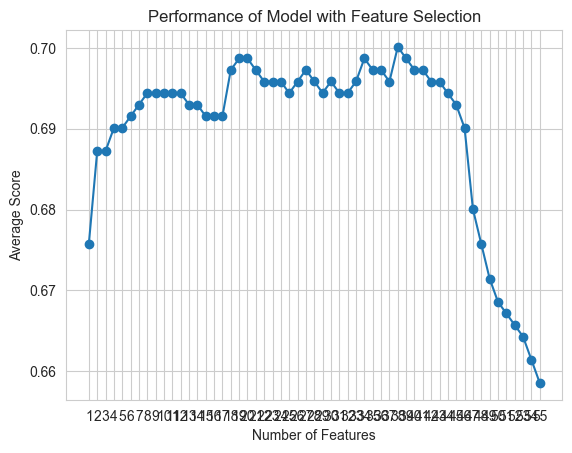

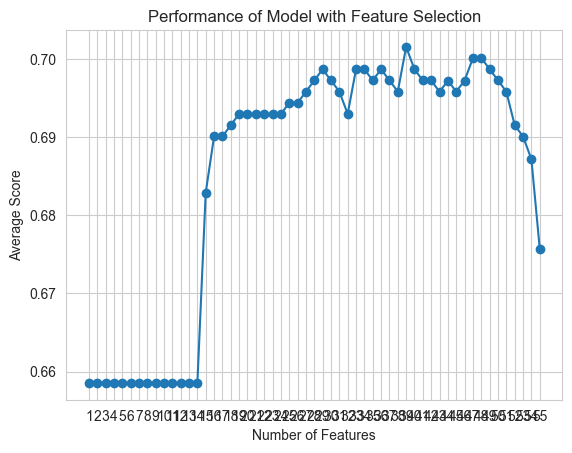

In [33]:
print("========================== Data 4  =================================")
print("SBFS")
slt_sbfs_features4_desb, score4_sbfs_desb = perform_feature_selection(X_train4, y_train4, modelo4_desb, "data4_desb", 'SBFS', 5)
print("SFFS")
slt_sffs_features4_desb, score4_sffs_desb = perform_feature_selection(X_train4, y_train4, modelo4_desb, "data4_desb", 'SFFS', 5)

========================== Data 5  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    0.9s finished

[2023-12-26 13:51:17] Features: 54/1 -- score: 0.6858067831449126[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.9s finished

[2023-12-26 13:51:18] Features: 53/1 -- score: 0.6901130524152107[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    0.9s fini

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    0.0s finished

[2023-12-26 13:53:33] Features: 1/55 -- score: 0.6656834532374101[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.0s finished

[2023-12-26 13:53:33] Features: 2/55 -- score: 0.6872353545734841[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    0.1s fini

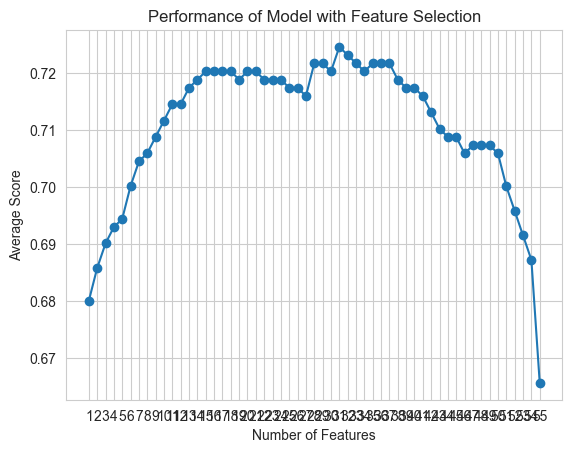

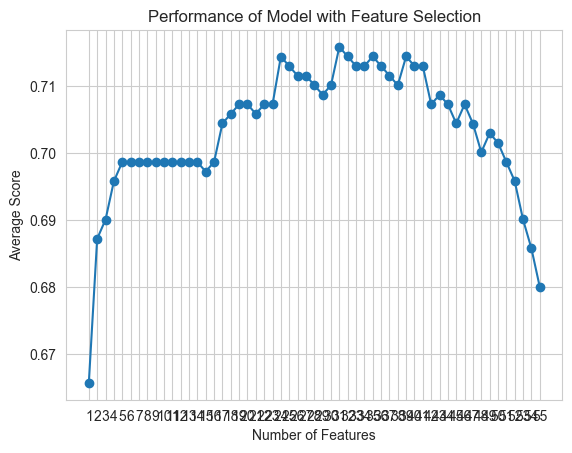

In [34]:
print("========================== Data 5  =================================")
print("SBFS")
slt_sbfs_features5_desb, score5_sbfs_desb = perform_feature_selection(X_train5, y_train5, modelo5_desb, "data5_desb", 'SBFS', 5)
print("SFFS")
slt_sffs_features5_desb, score5_sffs_desb = perform_feature_selection(X_train5, y_train5, modelo5_desb, "data5_desb", 'SFFS', 5)

========================== Data 6  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    5.2s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    5.2s finished

[2024-01-15 20:28:58] Features: 54/1 -- score: 0.7575334018499487[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    1.5s finished

[2024-01-15 20:29:00] Features: 53/1 -- score: 0.754655704008222[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    1.6s finis

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    1.8s finished

[2024-01-15 20:34:10] Features: 1/55 -- score: 0.7561151079136691[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    1.5s finished

[2024-01-15 20:34:12] Features: 2/55 -- score: 0.7158992805755396[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    1.6s fini

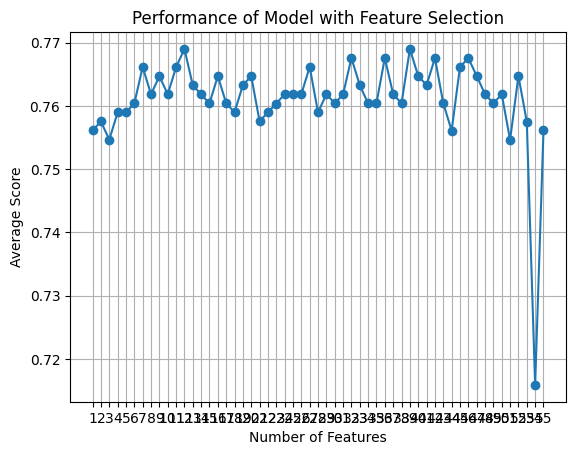

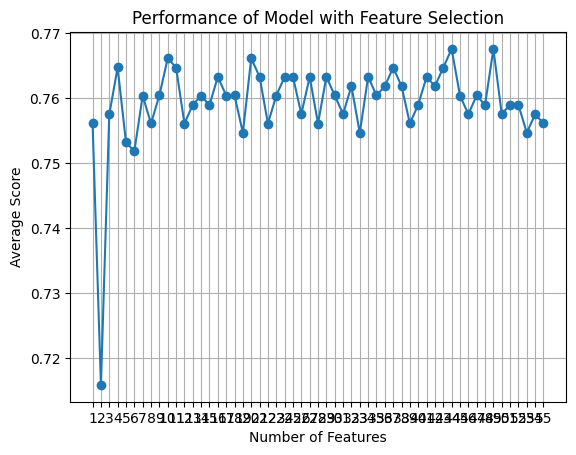

In [45]:
print("========================== Data 6  =================================")
print("SBFS")
slt_sbfs_features6_desb, score6_sbfs_desb = perform_feature_selection(X_train6, y_train6, modelo6_desb, "data6_desb", 'SBFS', 5)
print("SFFS")
slt_sffs_features6_desb, score6_sffs_desb = perform_feature_selection(X_train6, y_train6, modelo6_desb, "data6_desb", 'SFFS', 5)

#### Feature Selection nas bases com Random Under-Sampling

========================== Data 1  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   12.3s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:   39.3s remaining:    2.2s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:   39.4s finished

[2023-12-26 13:56:15] Features: 53/1 -- score: 0.6731494252873562[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   11.2s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:   37.6s remaining:    3.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:   37.7s finished

[2023-12-26 13:56:53] Features: 52/1 -- score: 0.6720065681444992[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   11.1s
[Parallel(n_jobs=16)]: Done  48 out of  52 | elapsed:   34.0s remaining:    2.7s
[Parallel(n_jobs=16)]: Done  52 out of  52 | elapsed:   36.9s fini

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    6.6s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:   23.1s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:   23.2s finished

[2023-12-26 14:49:53] Features: 1/54 -- score: 0.6594022988505748[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:   26.8s remaining:    2.1s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:   27.4s finished

[2023-12-26 14:50:21] Features: 2/54 -- score: 0.6651494252873563[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=16)]: Done  48 out of  52 | elapsed:   23.5s remaining:    1.9s
[Parallel(n_jobs=16)]: Done  52 out of  52 | elapsed:   25.1s fini

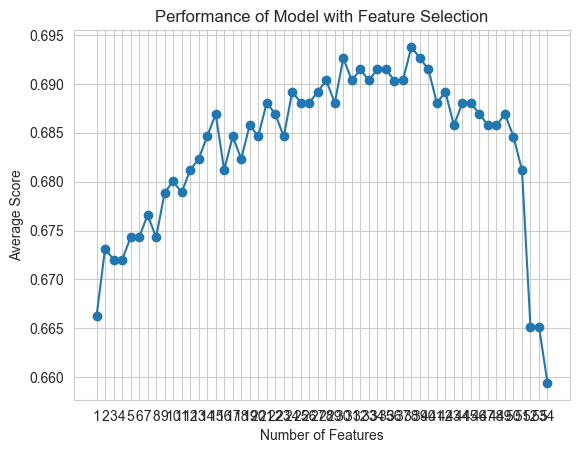

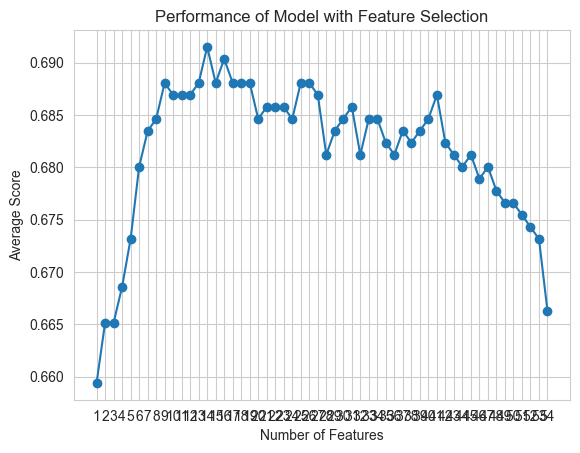

In [35]:
# Chamando a função de feature selection para cada um dos "modelos*"
print("========================== Data 1  =================================")
print("SBFS")
slt_sbfs_features1, score1_sbfs = perform_feature_selection(data1, target1, modelo1, "data1", 'SBFS', 5)
print("SFFS")
slt_sffs_features1, score1_sffs = perform_feature_selection(data1, target1, modelo1, "data1", 'SFFS', 5)

========================== Data 2  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done  84 out of  84 | elapsed:    6.2s finished

[2024-01-15 16:36:46] Features: 83/1 -- score: 0.7843114241001565[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  83 out of  83 | elapsed:    5.2s finished

[2024-01-15 16:36:51] Features: 82/1 -- score: 0.7758607198748043[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  82 out of  82 | elapsed:    5.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.7s finished

[2024-01-15 16:36:58] Features: 81/1 -- score: 0.7787949921752737[Parallel(n_jobs=16)]: Usin

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  84 out of  84 | elapsed:    3.1s finished

[2024-01-15 16:52:53] Features: 1/84 -- score: 0.7534820031298904[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  83 out of  83 | elapsed:    3.4s finished

[2024-01-15 16:52:57] Features: 2/84 -- score: 0.7646322378716746[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  82 out of  82 | elapsed:    3.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.5s finished

[2024-01-15 16:53:02] Features: 3/84 -- score: 0.7842331768388106[Parallel(n_jobs=16)]: Usin

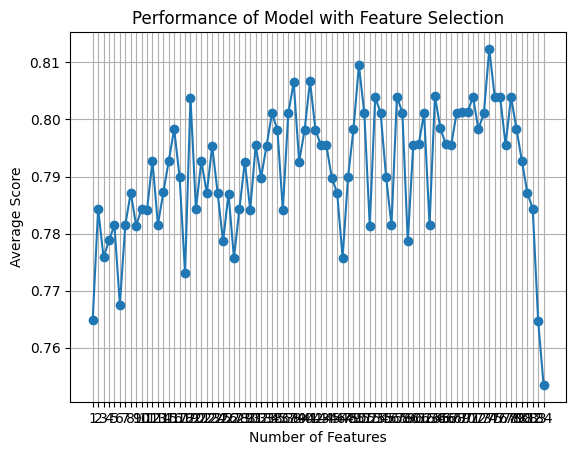

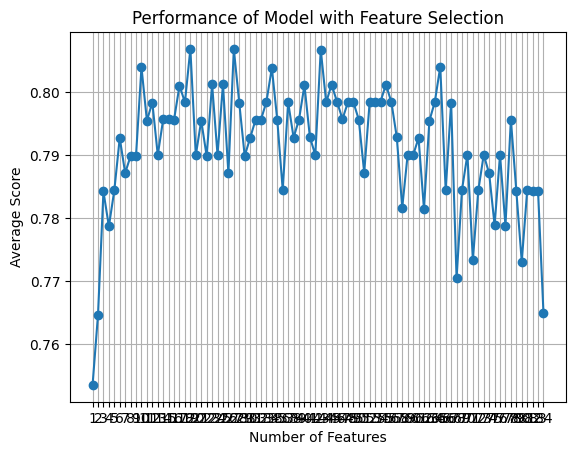

In [40]:
print("========================== Data 2  =================================")
print("SBFS")
slt_sbfs_features2, score2_sbfs = perform_feature_selection(X_train2_re, y_train2_re, modelo2, "data2", 'SBFS', 5)
print("SFFS")
slt_sffs_features2, score2_sffs = perform_feature_selection(X_train2_re, y_train2_re, modelo2, "data2", 'SFFS', 5)

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    5.1s
[Parallel(n_jobs=16)]: Done  58 out of  58 | elapsed:    6.5s finished

[2024-01-15 17:48:30] Features: 1/58 -- score: 0.7393974960876368[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  55 out of  57 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  57 out of  57 | elapsed:    1.7s finished

[2024-01-15 17:48:32] Features: 2/58 -- score: 0.7619718309859155[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  54 out of  56 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  56 out of  56 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[

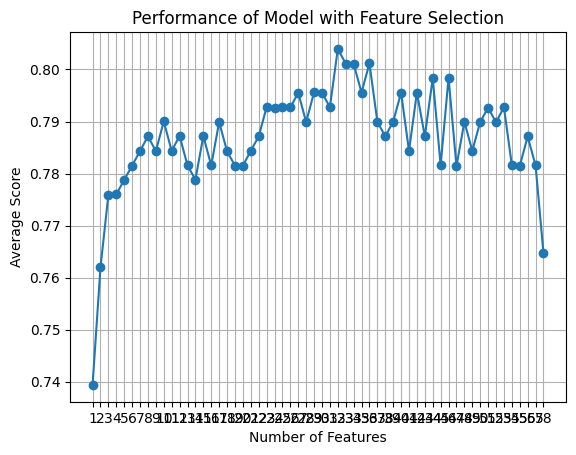

In [42]:
# print("========================== Data 3  =================================")
# print("SBFS")
# slt_sbfs_features3, score3_sbfs = perform_feature_selection(X_train3_re, y_train3_re, modelo3, "data3", 'SBFS', 5)
print("SFFS")
slt_sffs_features3, score3_sffs = perform_feature_selection(X_train3_re, y_train3_re, modelo3, "data3", 'SFFS', 5)

========================== Data 4  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    6.6s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    6.7s finished

[2023-12-26 15:54:33] Features: 54/1 -- score: 0.6766042692939245[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    6.3s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    6.4s finished

[2023-12-26 15:54:39] Features: 53/1 -- score: 0.6788834154351395[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    6.1s remaining:    0.4s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    6.2s fini

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    4.8s finished

[2023-12-26 16:08:00] Features: 1/55 -- score: 0.6870016420361248[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    4.9s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    5.0s finished

[2023-12-26 16:08:05] Features: 2/55 -- score: 0.6915927750410509[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    4.8s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    4.9s fini

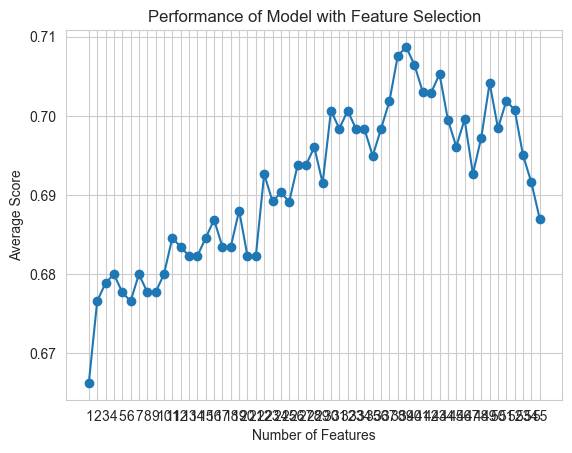

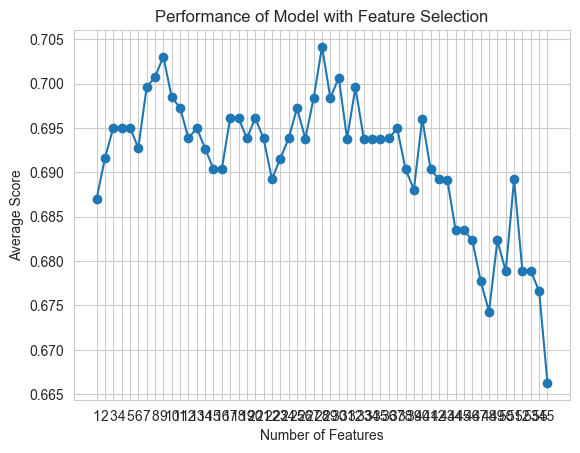

In [36]:
print("========================== Data 4  =================================")
print("SBFS")
slt_sbfs_features4, score4_sbfs = perform_feature_selection(data4, target4, modelo4,"data4", 'SBFS', 5)
print("SFFS")
slt_sffs_features4, score4_sffs = perform_feature_selection(data4, target4, modelo4, "data4", 'SFFS', 5)

In [37]:
print("========================== Data 5  =================================")
print("SBFS")
slt_sbfs_features5, score5_sbfs = perform_feature_selection(data5, target5, modelo5, "data5", 'SBFS', 5)
print("SFFS")
slt_sffs_features5, score5_sffs = perform_feature_selection(data5, target5, modelo5, "data5", 'SFFS', 5)

========================== Data 5  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    5.3s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    5.3s finished

[2023-12-26 16:19:53] Features: 54/1 -- score: 0.6628505747126436[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    5.2s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    5.3s finished

[2023-12-26 16:19:58] Features: 53/1 -- score: 0.6720065681444991[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    5.0s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    5.1s fini

TypeError: sequence item 3: expected str instance, int found

========================== Data 6  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    6.7s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    6.7s finished

[2024-01-15 20:55:59] Features: 54/1 -- score: 0.7591549295774647[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    4.4s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    4.4s finished

[2024-01-15 20:56:03] Features: 53/1 -- score: 0.7479655712050077[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    4.2s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    4.3s fini

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    2.7s finished

[2024-01-15 21:05:20] Features: 1/55 -- score: 0.7200312989045383[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    2.9s finished

[2024-01-15 21:05:23] Features: 2/55 -- score: 0.7368153364632237[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    3.0s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    3.0s fini

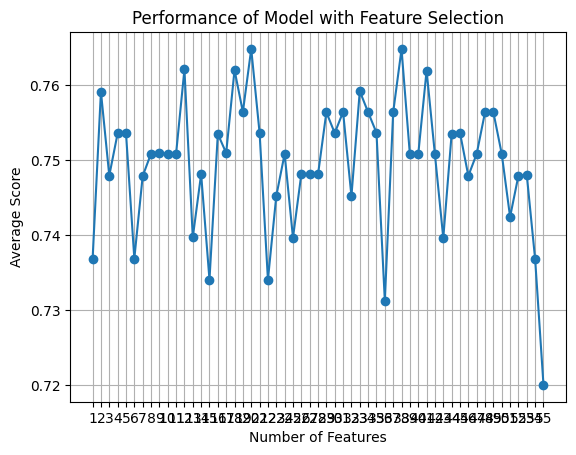

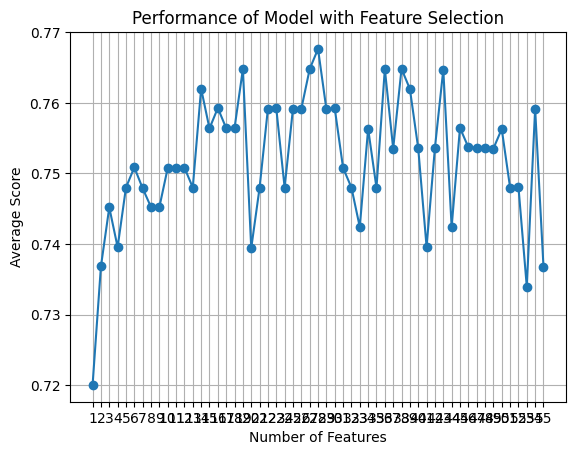

In [46]:
print("========================== Data 6  =================================")
print("SBFS")
slt_sbfs_features6, score6_sbfs = perform_feature_selection(X_train6_re, y_train6_re, modelo6, "data6", 'SBFS', 5)
print("SFFS")
slt_sffs_features6, score6_sffs = perform_feature_selection(X_train6_re, y_train6_re, modelo6, "data6", 'SFFS', 5)

#### Feature Selection nas bases com base Normalizada

In [ ]:
print("========================== Data 1  =================================")
print("SBFS")
slt_sbfs_features1_norm, score1_sbfs_norm = perform_feature_selection(data1_norm, target1, modelo1_norm, "data1_norm", 'SBFS', 5)
print("SFFS")
slt_sffs_features1_norm, score1_sffs_norm = perform_feature_selection(data1_norm, target1, modelo1_norm, "data1_norm", 'SFFS', 5)

========================== Data 2  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  84 out of  84 | elapsed:    4.8s finished

[2024-01-15 17:54:01] Features: 83/1 -- score: 0.7977286742034944[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  83 out of  83 | elapsed:    4.7s finished

[2024-01-15 17:54:06] Features: 82/1 -- score: 0.787677286742035[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  82 out of  82 | elapsed:    4.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.3s finished

[2024-01-15 17:54:12] Features: 81/1 -- score: 0.7962795477903393[Parallel(n_jobs=16)]: Using

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  84 out of  84 | elapsed:    2.7s finished

[2024-01-15 18:08:12] Features: 1/84 -- score: 0.7790133607399794[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  83 out of  83 | elapsed:    2.9s finished

[2024-01-15 18:08:15] Features: 2/84 -- score: 0.7818705035971224[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  82 out of  82 | elapsed:    2.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.3s finished

[2024-01-15 18:08:19] Features: 3/84 -- score: 0.7818807810894143[Parallel(n_jobs=16)]: Usin

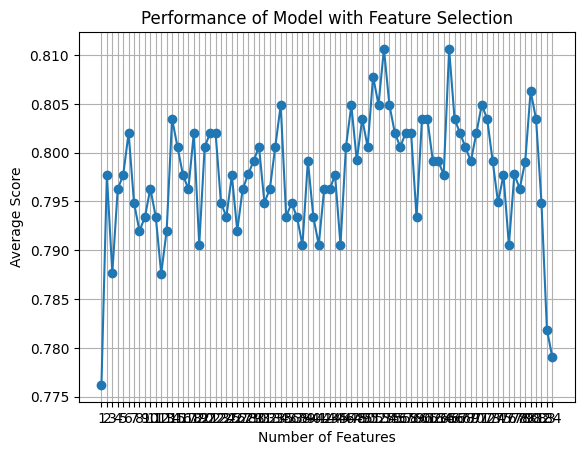

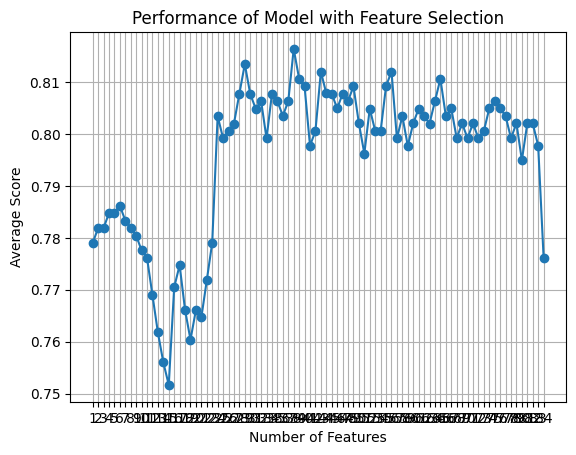

In [43]:
print("========================== Data 2  =================================")
print("SBFS")
slt_sbfs_features2_norm, score2_sbfs_norm = perform_feature_selection(X_train2_norm, y_train2, modelo2_norm,"data2_norm", 'SBFS', 5)
print("SFFS")
slt_sffs_features2_norm, score2_sffs_norm = perform_feature_selection(X_train2_norm, y_train2, modelo2_norm, "data2_norm", 'SFFS', 5)

========================== Data 3  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  58 out of  58 | elapsed:    2.3s finished

[2024-01-15 18:23:03] Features: 57/1 -- score: 0.7733196300102775[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  55 out of  57 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  57 out of  57 | elapsed:    2.3s finished

[2024-01-15 18:23:06] Features: 56/1 -- score: 0.780513874614594[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  54 out of  56 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  56 out of  56 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[P

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  58 out of  58 | elapsed:    1.9s finished

[2024-01-15 18:28:01] Features: 1/58 -- score: 0.7790133607399794[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  55 out of  57 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  57 out of  57 | elapsed:    1.9s finished

[2024-01-15 18:28:03] Features: 2/58 -- score: 0.7847584789311408[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  54 out of  56 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  56 out of  56 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[

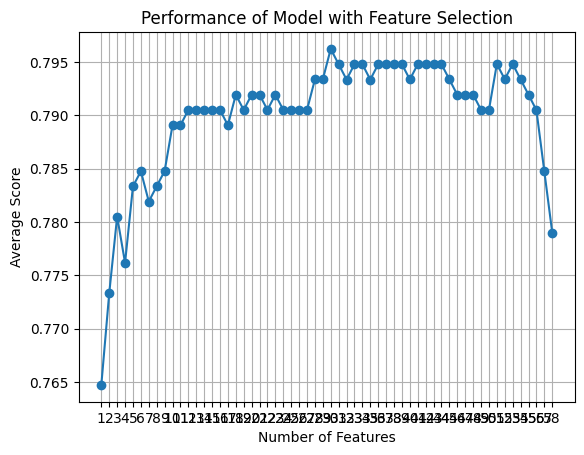

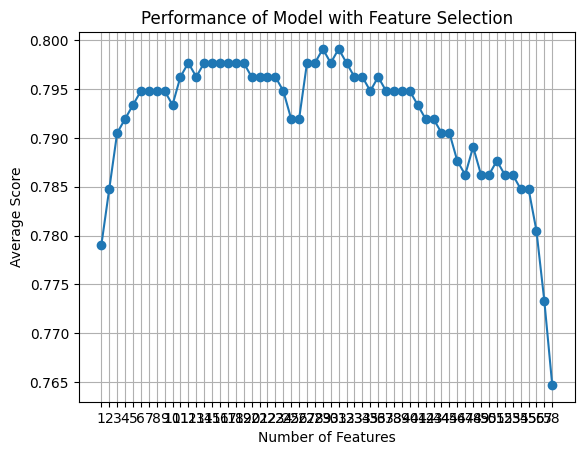

In [44]:
print("========================== Data 3  =================================")
print("SBFS")
slt_sbfs_features3_norm, score3_sbfs_norm = perform_feature_selection(X_train3_norm, y_train3, modelo3_norm, "data3_norm", 'SBFS', 5)
print("SFFS")
slt_sffs_features3_norm, score3_sffs_norm = perform_feature_selection(X_train3_norm, y_train3, modelo3_norm, "data3_norm", 'SFFS', 5)

========================== Data 6  =================================
SBFS


c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 con

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    0.3s finished

[2024-01-15 21:26:39] Features: 1/55 -- score: 0.7589311408016444[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.3s finished

[2024-01-15 21:26:39] Features: 2/55 -- score: 0.7661459403905447[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    0.3s fini

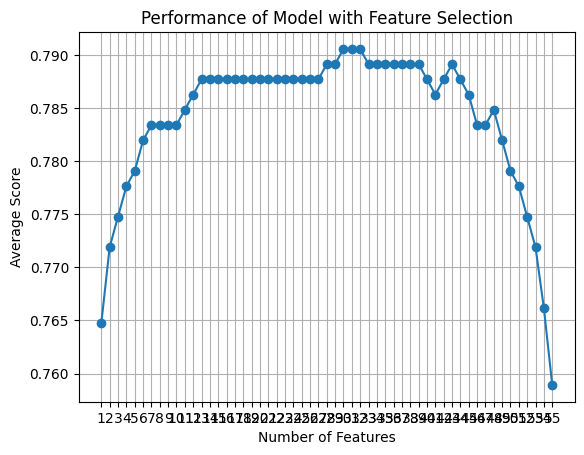

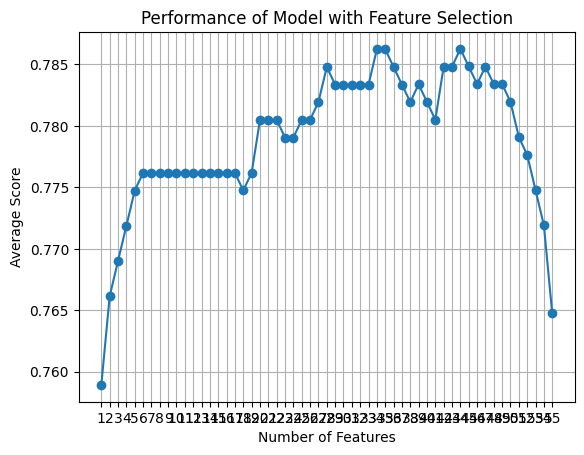

In [47]:
print("========================== Data 6  =================================")
print("SBFS")
slt_sbfs_features6_norm, score6_sbfs_norm = perform_feature_selection(X_train6_norm, y_train6, modelo6_norm, "data6_norm", 'SBFS', 5)
print("SFFS")
slt_sffs_features6_norm, score6_sffs_norm = perform_feature_selection(X_train6_norm, y_train6, modelo6_norm, "data6_norm", 'SFFS', 5)

### Avaliando os modelos com as features selecionadas

In [88]:
# Avaliando base 2 com sbfs
perform_cross_validation(modelo2_desb, X_train2.loc[:,slt_sbfs_features2_desb], y_train2, 5, True)

Cross Validation Scores:
Accuracy: 0.8264 (+/- 0.0566)
Class 0 - Precision: 0.7556, Recall: 0.5714, F1 Score: 0.6507
Class 1 - Precision: 0.8381, Recall: 0.7395, F1 Score: 0.7857
Class 2 - Precision: 0.8367, Recall: 0.9150, F1 Score: 0.8741


{'fit_time': array([0.06939411, 0.07090616, 0.06839323, 0.06839323, 0.07742143]),
 'score_time': array([0.01857781, 0.01857901, 0.01857781, 0.01857781, 0.01709771]),
 'test_score': array([0.83571429, 0.82857143, 0.78417266, 0.8705036 , 0.81294964])}

In [89]:
perform_cross_validation(modelo2_desb, X_train2.loc[:,slt_sffs_features2_desb], y_train2, 5, True)

Cross Validation Scores:
Accuracy: 0.8164 (+/- 0.0517)
Class 0 - Precision: 0.7356, Recall: 0.5378, F1 Score: 0.6214
Class 1 - Precision: 0.8632, Recall: 0.6891, F1 Score: 0.7664
Class 2 - Precision: 0.8214, Recall: 0.9216, F1 Score: 0.8686


{'fit_time': array([0.07291317, 0.07849789, 0.07749796, 0.07901478, 0.06874752]),
 'score_time': array([0.01764202, 0.01857805, 0.01857805, 0.01825213, 0.01778507]),
 'test_score': array([0.81428571, 0.80714286, 0.77697842, 0.85611511, 0.82733813])}

In [75]:
perform_cross_validation(modelo3_desb, X_train3.loc[:,slt_sbfs_features3_desb], y_train3, 5, True)

Cross Validation Scores:
fit_time: 0.0538 (+/- 0.0040)
score_time: 0.0224 (+/- 0.0018)
test_precision: 0.7986 (+/- 0.0587)
test_recall: 0.8006 (+/- 0.0521)
test_f1_score: 0.7939 (+/- 0.0622)
test_accuracy: 0.8006 (+/- 0.0521)


{'fit_time': array([0.05532193, 0.05532193, 0.05532193, 0.05029368, 0.05279899]),
 'score_time': array([0.02277875, 0.02127576, 0.02277875, 0.02155638, 0.02379918]),
 'test_precision': array([0.80805188, 0.80348843, 0.76628767, 0.84628022, 0.76888393]),
 'test_recall': array([0.81428571, 0.8       , 0.76978417, 0.84172662, 0.77697842]),
 'test_f1_score': array([0.80710502, 0.80039994, 0.75198376, 0.84108338, 0.76868738]),
 'test_accuracy': array([0.81428571, 0.8       , 0.76978417, 0.84172662, 0.77697842])}

In [92]:
perform_cross_validation(modelo3_desb, X_train3.loc[:,slt_sffs_features3_desb], y_train3, 5, True)

Cross Validation Scores:
Accuracy: 0.7905 (+/- 0.0667)
Class 0 - Precision: 0.6789, Recall: 0.6218, F1 Score: 0.6491
Class 1 - Precision: 0.7624, Recall: 0.6471, F1 Score: 0.7000
Class 2 - Precision: 0.8214, Recall: 0.8715, F1 Score: 0.8457


{'fit_time': array([0.0495069 , 0.0505271 , 0.0505271 , 0.04750586, 0.05123186]),
 'score_time': array([0.01875806, 0.01924682, 0.01823831, 0.01875806, 0.01805234]),
 'test_score': array([0.80714286, 0.78571429, 0.74100719, 0.84172662, 0.77697842])}

In [93]:
perform_cross_validation(modelo2, X_train2_re.loc[:,slt_sbfs_features2], y_train2_re, 5, True)

Cross Validation Scores:
Accuracy: 0.8124 (+/- 0.0945)
Class 0 - Precision: 0.7953, Recall: 0.8487, F1 Score: 0.8211
Class 1 - Precision: 0.9211, Recall: 0.8824, F1 Score: 0.9013
Class 2 - Precision: 0.7241, Recall: 0.7059, F1 Score: 0.7149


{'fit_time': array([0.06008434, 0.0625267 , 0.06051803, 0.06759477, 0.06759477]),
 'score_time': array([0.00551319, 0.00499916, 0.00600863, 0.00451493, 0.00451493]),
 'test_score': array([0.76388889, 0.84722222, 0.78873239, 0.88732394, 0.77464789])}

In [94]:
perform_cross_validation(modelo2, X_train2_re.loc[:,slt_sffs_features2], y_train2_re, 5, True)

Cross Validation Scores:
Accuracy: 0.8069 (+/- 0.0992)
Class 0 - Precision: 0.8421, Recall: 0.8067, F1 Score: 0.8240
Class 1 - Precision: 0.8889, Recall: 0.8739, F1 Score: 0.8814
Class 2 - Precision: 0.6984, Recall: 0.7395, F1 Score: 0.7184


{'fit_time': array([0.0801158 , 0.09063125, 0.09113598, 0.07811308, 0.09714317]),
 'score_time': array([0.0065167 , 0.00551677, 0.00600839, 0.00751662, 0.00651312]),
 'test_score': array([0.72222222, 0.83333333, 0.8028169 , 0.87323944, 0.8028169 ])}

In [96]:
perform_cross_validation(modelo3, X_train3_re.loc[:,slt_sbfs_features3], y_train3_re, 5, True)

Cross Validation Scores:
Accuracy: 0.7955 (+/- 0.1206)
Class 0 - Precision: 0.7851, Recall: 0.7983, F1 Score: 0.7917
Class 1 - Precision: 0.8852, Recall: 0.9076, F1 Score: 0.8963
Class 2 - Precision: 0.7105, Recall: 0.6807, F1 Score: 0.6953


{'fit_time': array([0.04748821, 0.04851604, 0.04648709, 0.04548693, 0.0460012 ]),
 'score_time': array([0.018574  , 0.01864433, 0.018574  , 0.018574  , 0.01807332]),
 'test_score': array([0.72222222, 0.875     , 0.8028169 , 0.84507042, 0.73239437])}

In [97]:
perform_cross_validation(modelo3, X_train3_re.loc[:,slt_sffs_features3], y_train3_re, 5, True)

Cross Validation Scores:
Accuracy: 0.8040 (+/- 0.1012)
Class 0 - Precision: 0.8205, Recall: 0.8067, F1 Score: 0.8136
Class 1 - Precision: 0.8780, Recall: 0.9076, F1 Score: 0.8926
Class 2 - Precision: 0.7094, Recall: 0.6975, F1 Score: 0.7034


{'fit_time': array([0.04830599, 0.04873562, 0.05526876, 0.04873633, 0.04925346]),
 'score_time': array([0.02053833, 0.02019477, 0.01972413, 0.01921821, 0.02022123]),
 'test_score': array([0.73611111, 0.86111111, 0.8028169 , 0.85915493, 0.76056338])}

In [98]:
perform_cross_validation(modelo2_norm, X_train2_norm.loc[:,slt_sbfs_features2_norm], y_train2, 5, True)

Cross Validation Scores:
Accuracy: 0.8106 (+/- 0.0665)
Class 0 - Precision: 0.7765, Recall: 0.5546, F1 Score: 0.6471
Class 1 - Precision: 0.7980, Recall: 0.6639, F1 Score: 0.7248
Class 2 - Precision: 0.8187, Recall: 0.9150, F1 Score: 0.8642


{'fit_time': array([0.06595635, 0.0714922 , 0.07301235, 0.06847644, 0.07351995]),
 'score_time': array([0.02238393, 0.02138662, 0.02037072, 0.02188349, 0.01987386]),
 'test_score': array([0.79285714, 0.82142857, 0.76258993, 0.86330935, 0.81294964])}

In [99]:
perform_cross_validation(modelo2_norm, X_train2_norm.loc[:,slt_sffs_features2_norm], y_train2, 5, True)

Cross Validation Scores:
Accuracy: 0.8163 (+/- 0.0462)
Class 0 - Precision: 0.7527, Recall: 0.5882, F1 Score: 0.6604
Class 1 - Precision: 0.8058, Recall: 0.6975, F1 Score: 0.7477
Class 2 - Precision: 0.8303, Recall: 0.9063, F1 Score: 0.8667


{'fit_time': array([0.06690168, 0.06641579, 0.06641579, 0.06692791, 0.06692791]),
 'score_time': array([0.0191431 , 0.0186286 , 0.01811314, 0.0181253 , 0.01711702]),
 'test_score': array([0.83571429, 0.80714286, 0.78417266, 0.84892086, 0.8057554 ])}

In [100]:
perform_cross_validation(modelo3_norm, X_train3_norm.loc[:,slt_sbfs_features3_norm], y_train3, 5, True)

Cross Validation Scores:
Accuracy: 0.7962 (+/- 0.0538)
Class 0 - Precision: 0.6792, Recall: 0.6050, F1 Score: 0.6400
Class 1 - Precision: 0.8021, Recall: 0.6471, F1 Score: 0.7163
Class 2 - Precision: 0.8202, Recall: 0.8845, F1 Score: 0.8512


{'fit_time': array([0.0602417 , 0.05819988, 0.05819988, 0.057199  , 0.05824208]),
 'score_time': array([0.01917362, 0.01911759, 0.01811099, 0.01911759, 0.01807451]),
 'test_score': array([0.79285714, 0.81428571, 0.75539568, 0.83453237, 0.78417266])}

In [101]:
perform_cross_validation(modelo3_norm, X_train3_norm.loc[:,slt_sffs_features3_norm], y_train3, 5, True)

Cross Validation Scores:
Accuracy: 0.7991 (+/- 0.0549)
Class 0 - Precision: 0.6727, Recall: 0.6218, F1 Score: 0.6463
Class 1 - Precision: 0.8261, Recall: 0.6387, F1 Score: 0.7204
Class 2 - Precision: 0.8222, Recall: 0.8867, F1 Score: 0.8532


{'fit_time': array([0.0572474 , 0.05834866, 0.05624509, 0.05834866, 0.06847668]),
 'score_time': array([0.02022171, 0.01912427, 0.02022171, 0.01912427, 0.01922727]),
 'test_score': array([0.81428571, 0.8       , 0.76978417, 0.84172662, 0.76978417])}

### Salvando as features selecionadas

#### Sem Random Under-Sampling

In [40]:
# Criando um arquivo txt com a feature selecionadas
with open(f"results/SBFS_data1_desb.txt", "w") as f:
    f.write(str(slt_sbfs_features1_desb))
with open(f"results/SFFS_data1_desb.txt", "w") as f:
    f.write(str(slt_sffs_features1_desb))


# with open(f"results/SBFS_data2_desb.txt", "w") as f:
#     f.write(str(slt_sbfs_features2_desb))
# with open(f"results/SFFS_data2_desb.txt", "w") as f:
#     f.write(str(slt_sffs_features2_desb))
# with open(f"results/SBFS_data3_desb.txt", "w") as f:
#     f.write(str(slt_sbfs_features3_desb))
# with open(f"results/SFFS_data3_desb.txt", "w") as f:
#     f.write(str(slt_sffs_features3_desb))

with open(f"results/SBFS_data4_desb.txt", "w") as f:
    f.write(str(slt_sbfs_features4_desb))
with open(f"results/SFFS_data4_desb.txt", "w") as f:
    f.write(str(slt_sffs_features4_desb))
with open(f"results/SBFS_data5_desb.txt", "w") as f:
    f.write(str(slt_sbfs_features5_desb))
with open(f"results/SFFS_data5_desb.txt", "w") as f:
    f.write(str(slt_sffs_features5_desb))



# with open(f"results/SBFS_data6_desb.txt", "w") as f:
#     f.write(str(slt_sbfs_features6_desb))
# with open(f"results/SFFS_data6_desb.txt", "w") as f:
#     f.write(str(slt_sffs_features6_desb))

#### Com Random Under-Sampling

In [41]:
# Criando um arquivo txt com a feature selecionadas
with open(f"results/SBFS_data1.txt", "w") as f:
    f.write(str(slt_sbfs_features1))
with open(f"results/SFFS_data1.txt", "w") as f:
    f.write(str(slt_sffs_features1))

# with open(f"results/SBFS_data2.txt", "w") as f:
#     f.write(str(slt_sbfs_features2))
# with open(f"results/SFFS_data2.txt", "w") as f:
#     f.write(str(slt_sffs_features2))
# with open(f"results/SBFS_data3.txt", "w") as f:
#     f.write(str(slt_sbfs_features3))
# with open(f"results/SFFS_data3.txt", "w") as f:
#     f.write(str(slt_sffs_features3))
    
with open(f"results/SBFS_data4.txt", "w") as f:
    f.write(str(slt_sbfs_features4))
with open(f"results/SFFS_data4.txt", "w") as f:
    f.write(str(slt_sffs_features4))
with open(f"results/SBFS_data5.txt", "w") as f:
    f.write(str(slt_sbfs_features5))
with open(f"results/SFFS_data5.txt", "w") as f:
    f.write(str(slt_sffs_features5))
# 
# with open(f"results/SBFS_data6.txt", "w") as f:
#     f.write(str(slt_sbfs_features6))
# with open(f"results/SFFS_data6.txt", "w") as f:
#     f.write(str(slt_sffs_features6))

NameError: name 'slt_sbfs_features5' is not defined

### [Abrir features selecionadas]

In [ ]:
# Lendo os arquivos txt com as features selecionadas
slt_sbfs_features1 = ler_arquivo_txt('results/SBFS_data1.txt')[0]
slt_sffs_features1 = ler_arquivo_txt('results/SFFS_data1.txt')[0]
slt_sbfs_features2 = ler_arquivo_txt('results/SBFS_data2.txt')[0]
slt_sffs_features2 = ler_arquivo_txt('results/SFFS_data2.txt')[0]
slt_sbfs_features3 = ler_arquivo_txt('results/SBFS_data3.txt')[0]
slt_sffs_features3 = ler_arquivo_txt('results/SFFS_data3.txt')[0]
slt_sbfs_features4 = ler_arquivo_txt('results/SBFS_data4.txt')[0]
slt_sffs_features4 = ler_arquivo_txt('results/SFFS_data4.txt')[0]
slt_sbfs_features5 = ler_arquivo_txt('results/SBFS_data5.txt')[0]
slt_sffs_features5 = ler_arquivo_txt('results/SFFS_data5.txt')[0]
slt_sbfs_features6 = ler_arquivo_txt('results/SBFS_data6.txt')[0]
slt_sffs_features6 = ler_arquivo_txt('results/SFFS_data6.txt')[0]

### Avaliando os modelos com as features selecionadas

In [71]:
# Função para pegar as features selecionadas do csv. Essa função retorna uma lista com as features selecionadas.
def get_features_selected(file):
    df = pd.read_csv(file)
    # Seleciona a linha da coluna avg_score que possui o maior valor
    df = df.loc[df['avg_score'] == df['avg_score'].max()]
    
    # Agora pega as features na coluna feature_idx
    features = df['feature_idx'].values[0]
    
    # Transforma a string em lista
    features = features.replace(' ', '').replace('(', '').replace(')', '').split(',')
    
    # Transforma os elementos da lista em inteiros
    features = [int(i) for i in features]
    
    return features

In [86]:
get_features_selected(r'results/SBFS_data2_desb.csv')

[11, 38, 45, 46, 52, 55, 60, 62, 66, 72, 74, 79, 81]

#### Sem Random Under-Sampling

In [ ]:
# # Testando os modelos com as features selecionadas
# print("========================== Data 1  - SBFS =================================")
# perform_cross_validation(modelo1_desb, X_train1.loc[:,slt_sbfs_features1], x, 5, False)
# 
# print("========================== Data 1  - SFFS =================================")
# perform_cross_validation(modelo1, data1_re.loc[:,slt_sffs_features1], target1_re, 5, False)

In [90]:
print("========================== Data 2  - SBFS =================================")
slt_sbfs_features2_desb = get_features_selected(r'results/SBFS_data2_desb.csv')
perform_cross_validation(modelo2_desb, X_train2.iloc[:,slt_sbfs_features2_desb], y_train2, 5, False)

# Acuracaria com dados de teste
modelo2_desb.fit(X_train2.iloc[:,slt_sbfs_features2_desb], y_train2)
pred = modelo2_desb.predict(X_test2.iloc[:,slt_sbfs_features2_desb])
print(f'Acurácia: {accuracy_score(y_test2, pred)}')

print("========================== Data 2  - SFFS =================================")
slt_sffs_features2_desb = get_features_selected(r'results/SFFS_data2_desb.csv')
perform_cross_validation(modelo2_desb, X_train2.iloc[:,slt_sffs_features2_desb], y_train2, 5, False)

# Acuracaria com dados de teste
modelo2_desb.fit(X_train2.iloc[:,slt_sffs_features2_desb], y_train2)
pred = modelo2_desb.predict(X_test2.iloc[:,slt_sffs_features2_desb])
print(f'Acurácia: {accuracy_score(y_test2, pred)}')

========================== Data 2  - SBFS =================================
Average Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.57      0.69       119
           1       0.85      0.66      0.75       119
           2       0.83      0.95      0.88       459

    accuracy                           0.83       697
   macro avg       0.85      0.73      0.77       697
weighted avg       0.84      0.83      0.83       697

--------------------------------------------------
Accuracy: 0.83
Acurácia: 0.7371428571428571
========================== Data 2  - SFFS =================================
Average Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.50      0.63       119
           1       0.84      0.63      0.72       119
           2       0.81      0.95      0.87       459

    accuracy                           0.82       697
   macro avg       0.83      0.69     

In [91]:
print("========================== Data 3  - SBFS =================================")
slt_sbfs_features3_desb = get_features_selected(r'results/SBFS_data3_desb.csv')
perform_cross_validation(modelo3_desb, X_train3.iloc[:,slt_sbfs_features3_desb], y_train3, 5, False)

# Acuracaria com dados de teste
modelo3_desb.fit(X_train3.iloc[:,slt_sbfs_features3_desb], y_train3)
pred = modelo3_desb.predict(X_test3.iloc[:,slt_sbfs_features3_desb])
print(f'Acurácia: {accuracy_score(y_test3, pred)}')

print("========================== Data 3  - SFFS =================================")
slt_sffs_features3_desb = get_features_selected(r'results/SFFS_data3_desb.csv')
perform_cross_validation(modelo3_desb, X_train3.iloc[:,slt_sffs_features3_desb], y_train3, 5, False)

# Acuracaria com dados de teste
modelo3_desb.fit(X_train3.iloc[:,slt_sffs_features3_desb], y_train3)
pred = modelo3_desb.predict(X_test3.iloc[:,slt_sffs_features3_desb])
print(f'Acurácia: {accuracy_score(y_test3, pred)}')


========================== Data 3  - SBFS =================================
Average Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.51      0.63       119
           1       0.83      0.57      0.68       119
           2       0.80      0.94      0.86       459

    accuracy                           0.80       697
   macro avg       0.81      0.67      0.72       697
weighted avg       0.81      0.80      0.79       697

--------------------------------------------------
Accuracy: 0.80
Acurácia: 0.7485714285714286
========================== Data 3  - SFFS =================================
Average Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.43      0.57       119
           1       0.83      0.59      0.69       119
           2       0.79      0.95      0.86       459

    accuracy                           0.80       697
   macro avg       0.82      0.66     

In [ ]:
print("========================== Data 4  - SBFS =================================")
perform_cross_validation(modelo4, data4_re.loc[:,slt_sbfs_features4], target4_re, 5, False)

print("========================== Data 4  - SFFS =================================")
perform_cross_validation(modelo4, data4_re.loc[:,slt_sffs_features4], target4_re, 5, False)

In [ ]:
print("========================== Data 5  - SBFS =================================")
perform_cross_validation(modelo5, data5_re.loc[:,slt_sbfs_features5], target5_re, 5, False)

print("========================== Data 5  - SFFS =================================")
perform_cross_validation(modelo5, data5_re.loc[:,slt_sffs_features5], target5_re, 5, False)

In [ ]:
print("========================== Data 6  - SBFS =================================")
perform_cross_validation(modelo6, data6_re.loc[:,slt_sbfs_features6], target6_re, 5, False)

print("========================== Data 6  - SFFS =================================")
perform_cross_validation(modelo6, data6_re.loc[:,slt_sffs_features6], target6_re, 5, False)

#### Com Random Under-Sampling

## Matriz de Confusão

In [ ]:


# Definindo as classes
classes = ["Baixo", "Médio", "Alto"]

# Sua matriz de confusão de três classes
conf_matrix = np.array([[20, 0, 2],
                        [0, 30, 1],
                        [12, 3, 27]])

# Calculando precisão, recall e f1 score para cada classe
precision = []
recall = []
f1 = []

for i in range(len(conf_matrix)):
    TP = conf_matrix[i][i]
    FP = sum(conf_matrix[r][i] for r in range(len(conf_matrix)) if r != i)
    FN = sum(conf_matrix[i][c] for c in range(len(conf_matrix)) if c != i)

    precision.append(TP / (TP + FP))
    recall.append(TP / (TP + FN))
    f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))

# Criando um DataFrame com os resultados
df = pd.DataFrame({'Classe': classes, 'Precisão': precision, 'Recall': recall, 'F1 Score': f1})

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6), dpi=300)
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, annot_kws={"size": 14})
plt.xlabel('Classe Prevista', size=12, fontweight='bold')
plt.ylabel('Classe Real', size=12, fontweight='bold')
plt.title('Matriz de Confusão - SBFS - DATA 2', size=14, fontweight='bold')
plt.savefig('confusion_matrix_sbfs_data2.png', dpi=300, transparent=True)
plt.show()

# Exibindo a tabela com os resultados
print("Tabela de Resultados:")
df




In [17]:
# Decode the labels
decoded_labels = le.inverse_transform([0, 1, 2])

print(decoded_labels)


['Alto' 'Baixo' 'Medio']
